### Settings and imports

In [1]:
%matplotlib notebook

In [2]:
import sys
mypath = "/home/basia/Documents/spectroscopy/wassersteinms"
sys.path.insert(0, mypath)
import masserstein 

In [3]:
import os

from masserstein import NMRSpectrum, Spectrum, estimate_proportions

from matplotlib import pyplot as plt

import numpy as np

import pulp

import pickle

import seaborn as sns

from textwrap import wrap

import pandas as pd

### Ground truth

In [4]:
official_names = ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride']
protons = [4, 4, 5, 5, 13]
molar_proportions = [0.3022, 0.2240, 0.1253, 0.2028, 0.1457]

In [5]:
real_visible_proportions = [prop*prot for prop, prot in zip(molar_proportions, protons)]
real_visible_proportions = [p/sum(real_visible_proportions) for p in real_visible_proportions]
real_visible_proportions

[0.2143490442245629,
 0.1588821505833954,
 0.11109337872823348,
 0.1798063623789765,
 0.3358690640848317]

### Loading the data

In [6]:
official_names = ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride']

In [7]:
components = np.loadtxt('metabolity.csv', delimiter=',', skiprows=1)
ppm_components = components[:,0]
components = components[:,1:]

mix = np.loadtxt('metabolity_shimy.csv', delimiter=',', skiprows=1)
ppm = mix[:,0]
mix = mix[:,2]

In [8]:
# ppm = #np.array with shape (number_of_points on frequency axis for mixture,)
# mix = #np.array with shape (number_of_points on frequency axis,)
# ppm_comp = #np.array with shape (number_of_points on frequency axis for components, )
# components = #np.array with shape (number_of_points on frequency axis for components, number of components)
# real_visible_proportions = #np.array with shape (number of components,)

In [9]:
components_ints = []
names = []
for i in range(components.shape[1]):
    components_ints.append(components[:,i])
    names.append('comp'+str(i))

In [10]:
spectra = []
for comp_ints in components_ints:
    spectra.append(NMRSpectrum(confs=list(zip(ppm_components, comp_ints))))

In [11]:
mix = NMRSpectrum(confs=list(zip(ppm,mix)))

In [12]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

<IPython.core.display.Javascript object>


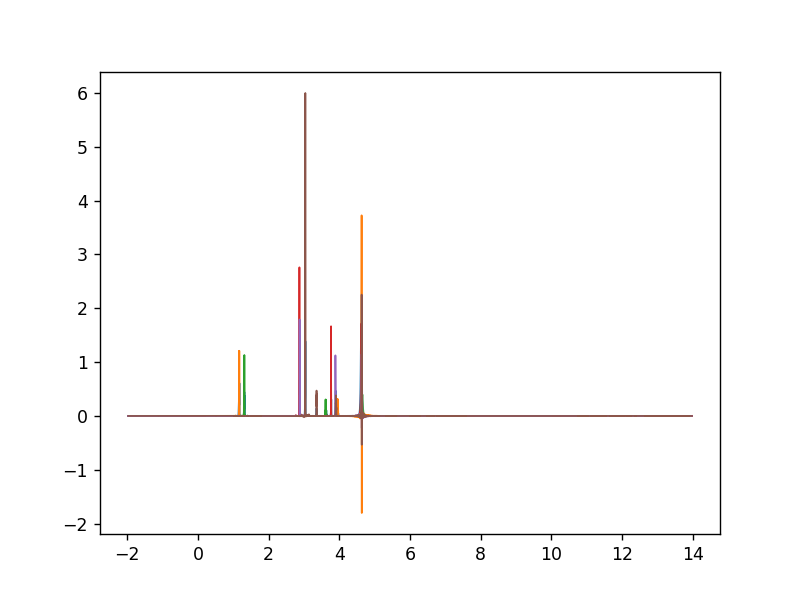

In [13]:
mix.plot(profile=True)
comp0.plot(profile=True)
comp1.plot(profile=True) 
comp2.plot(profile=True)
comp3.plot(profile=True)
comp4.plot(profile=True)

### Additional preprocessing: removing peak from solvent

In [14]:
def remove_peak_from_region(spectrum, region):
    
    lower_bound = region[0]
    upper_bound = region[1]
    
    new_confs = np.array(spectrum.confs)
    in_region = np.logical_and(lower_bound < new_confs[:,0], new_confs[:,0] < upper_bound)
    new_confs[in_region, 1] = 0
    
    return Spectrum(confs=list(zip(new_confs[:,0], new_confs[:,1])))

In [15]:
preprocessed_spectra = []
for sp in [mix] + spectra:
    no_solvent_peak = remove_peak_from_region(sp, (4.4, 4.8))
    no_solvent_peak.normalize()
    preprocessed_spectra.append(no_solvent_peak)
mix = preprocessed_spectra[0]
spectra = preprocessed_spectra[1:]
del(preprocessed_spectra)

### Optional step: shifting one spectrum

In [16]:
def shift_one_spectrum(sp, how_much):
    res = sp
    old_confs = np.array(sp.confs)

    new_ppm_non_unique = old_confs[:,0] + how_much
    resampled = sp.resample(np.unique(new_ppm_non_unique) + how_much)
    new_ppm_unique = np.array(resampled.confs)[:,0]
    new_ints = np.array(resampled.confs)[:,1]
    res = Spectrum(confs=list(zip(new_ppm_unique + how_much, new_ints)))
    return(res)

#shift_right = [0.14, 0.15, 0.14, 0.14, 0.14] #equivalently, we can shift mixture 0.14 to the left
#mix = shift_one_spectrum(mix, -0.14)

### Preprocessing

In [17]:
def shift(list_of_spectra, epsilon=0.001):
    res = list_of_spectra
    shifted_unique = []
    old_confs = [np.array(sp.confs) for sp in list_of_spectra]
    min_of_min = min([min(old_conf[:,0]) for old_conf in old_confs])
    if min_of_min<0:
        return (min_of_min - epsilon)*(-1)
    else:
        return(0)

In [18]:
def make_nonnegative(spectrum):
    confs = np.array(spectrum.confs)
    neg = confs[:,1]<0
    confs[:,1][neg]=0
    new_confs = list(zip(confs[:,0],confs[:,1]))
    result = NMRSpectrum(confs=new_confs)
    return(result)

In [19]:
def common_mass_axis(list_of_spectra):
    all_mz = set()
    for sp in list_of_spectra:
        mz_set = set(np.array(sp.confs, np.dtype('float'))[:,0])
        all_mz = all_mz.union(mz_set)
    all_mz = np.array(sorted(all_mz))
    return all_mz

In [20]:
spectra_and_mixture = spectra + [mix]

In [21]:
shift_coef = shift(spectra_and_mixture)

In [22]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [23]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [24]:
cma = common_mass_axis(spectra_and_mixture)

In [25]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    preprocessed_spectra.append(sp.resample(cma))

In [26]:
spectra_and_mixture = preprocessed_spectra
del(preprocessed_spectra)

In [27]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp = make_nonnegative(sp)
    sp.sort_confs()
    sp.merge_confs()
    sp.normalize()
    preprocessed_spectra.append(sp)

In [28]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [29]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

<IPython.core.display.Javascript object>


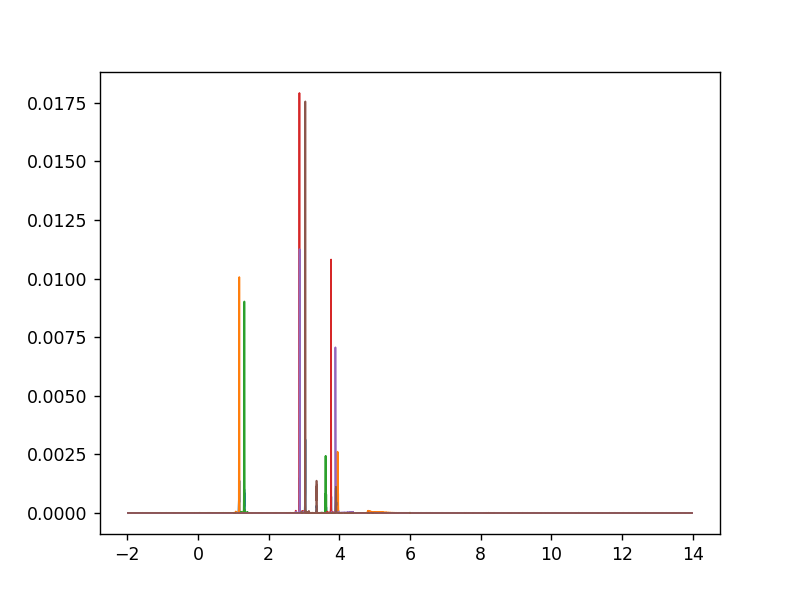

In [30]:
mix.plot(profile=True)
comp0.plot(profile=True)
comp1.plot(profile=True) 
comp2.plot(profile=True)
comp3.plot(profile=True)
comp4.plot(profile=True)

### Removing unnecessary data points

In [31]:
def cut_spectra_to_region(list_of_spectra, lower_bound, upper_bound):
    res = []
    for sp in list_of_spectra:
        ppm = np.array(sp.confs)[:,0]
        ints = np.array(sp.confs)[:,1]
        ppm_in_region = np.logical_and(ppm>lower_bound, ppm<upper_bound)
        new_ppm = ppm[ppm_in_region]
        new_ints = ints[ppm_in_region]
        res.append(masserstein.Spectrum(confs=list(zip(new_ppm, new_ints))))
    return res

In [32]:
#2.8, 6.1
preprocessed_spectra = cut_spectra_to_region(spectra_and_mixture, 2.8-shift_coef, 6.1-shift_coef)

In [33]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [34]:
preprocessed_spectra = []
for sp in spectra_and_mixture:
    sp2 = make_nonnegative(sp)
    sp2.sort_confs()
    sp2.merge_confs()
    sp2.normalize()
    preprocessed_spectra.append(sp2)

In [35]:
spectra_and_mixture = preprocessed_spectra
spectra = spectra_and_mixture[:-1]
mix = preprocessed_spectra[-1]
del(preprocessed_spectra)

In [36]:
for i, sp in enumerate(spectra):
    sp.protons = protons[i]

In [37]:
for i, name in enumerate(names):
    globals()[name] = spectra[i]

In [38]:
components_ints = []
for spectrum in spectra:
    components_ints.append(np.array(spectrum.confs)[:,1])#.reshape(-1,1))

In [39]:
ppm = np.array(mix.confs)[:,0]
mix_ints = np.array(mix.confs)[:,1]

In [40]:
labels = ['Lactate', 'Alanine', 'Creatine', 'Creatinine', 'Choline chloride', 'Mixture']
for i, sp in enumerate(spectra_and_mixture):
    sp.label = labels[i]

<IPython.core.display.Javascript object>


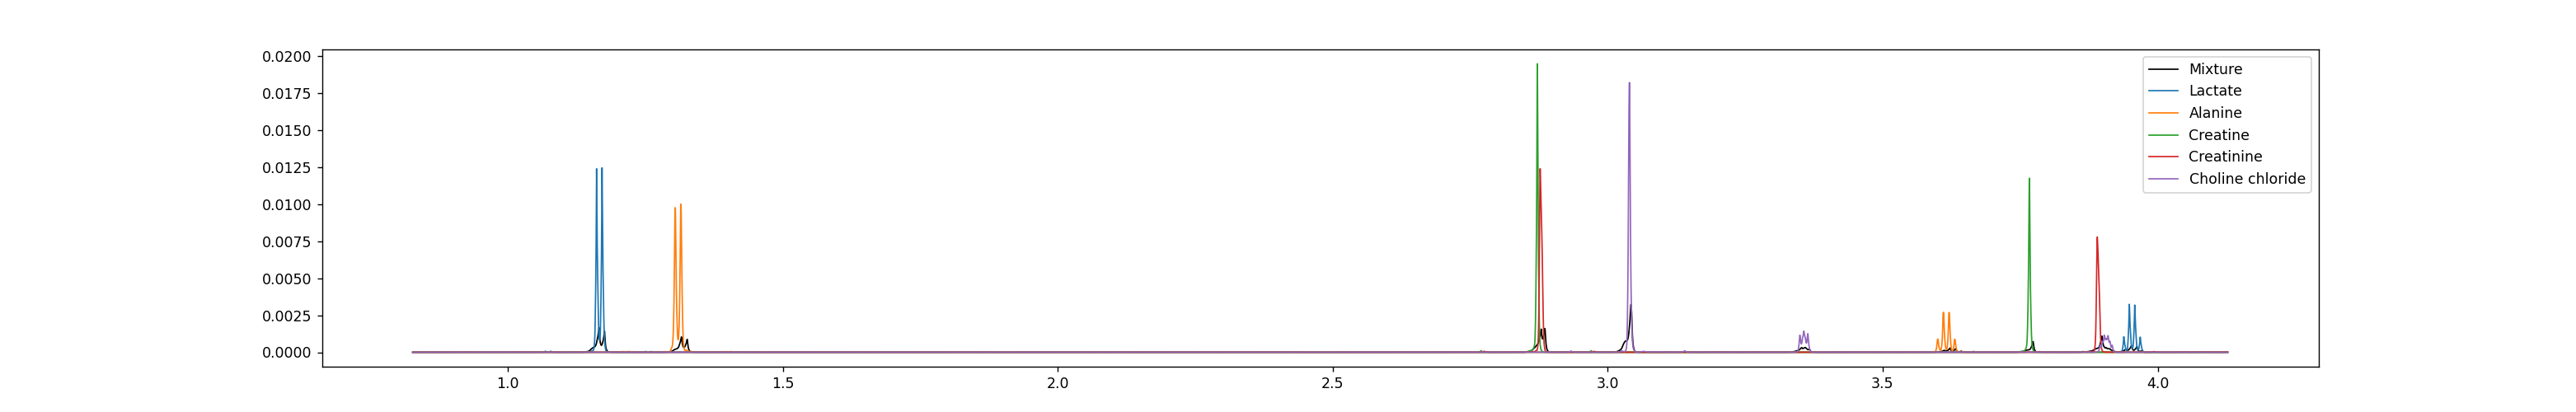

In [41]:
fig, ax = plt.subplots()
fig.set_size_inches(25, 4, forward=True)
mix.plot(profile=True, color='black')
comp0.plot(profile=True)
comp1.plot(profile=True) 
comp2.plot(profile=True)
comp3.plot(profile=True)
comp4.plot(profile=True)
ax.legend()
#plt.savefig('aligned_spectra.png', dpi=300)

### Finding best values of parameters

In [42]:
import time
import pandas as pd
import pulp

In [43]:
lower_limit = 0.01
upper_limit = 0.31
step = 0.01

In [42]:
# list_of_estimation_results = []
# for kappa in np.arange(start=lower_limit, stop=upper_limit, step=step):
#     fixed_kappa = []
#     for kappa_prime in np.arange(start=lower_limit, stop=upper_limit, step=step):
#         start = time.time()
#         estimation = estimate_proportions(mix, [comp0, comp1, comp2, comp3, comp4], 
#                                    MTD=kappa, MTD_th=kappa_prime, verbose=False, solver=pulp.GUROBI(msg=False))
#         end = time.time()
#         fixed_kappa.append(estimation['proportions'])
#         print('Estimation for '+str(kappa)+' and '+str(kappa_prime)+' done')
#         print('It took: '+str(end-start)+' seconds.')
#         print(estimation['proportions'])
#     list_of_estimation_results.append(fixed_kappa)

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108100.62it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2941151.60it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.69s/it]


Estimation for 0.01 and 0.01 done
It took: 15.761370182037354 seconds.
[0.21782828235600038, 0.1072664502150002, 0.08990541382900016, 0.16433171704800031, 0.30697910620200053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 94042.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1760785.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.25s/it]


Estimation for 0.01 and 0.02 done
It took: 18.32724094390869 seconds.
[0.21801610572500038, 0.09822014234700017, 0.08655157322000015, 0.1660750981570003, 0.30727334401700057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 77101.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2741928.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.31s/it]


Estimation for 0.01 and 0.03 done
It took: 21.379127502441406 seconds.
[0.2170916709110004, 0.09756956844100016, 0.08300795097800015, 0.16615098840600032, 0.30587643208200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 61680.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1990366.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.76s/it]


Estimation for 0.01 and 0.04 done
It took: 17.858447551727295 seconds.
[0.2166052672540004, 0.09689268276000017, 0.08096499128800014, 0.1662695587080003, 0.30491405777400055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 177724.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2723943.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.13s/it]


Estimation for 0.01 and 0.05 done
It took: 15.194602727890015 seconds.
[0.2159428119440004, 0.09658078617900016, 0.07922077861000014, 0.1660007882550003, 0.3039689504740006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 179243.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2771513.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.16s/it]


Estimation for 0.01 and 0.060000000000000005 done
It took: 17.234321355819702 seconds.
[0.2152580657590004, 0.09584946021600016, 0.07733004892100014, 0.1659777934670003, 0.30320756991700054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 113359.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2830951.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.13s/it]


Estimation for 0.01 and 0.06999999999999999 done
It took: 20.2018404006958 seconds.
[0.2148653458030004, 0.09511222724400016, 0.07693621650500014, 0.1657772835280003, 0.3022051944510006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 55188.21it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2021160.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.00s/it]


Estimation for 0.01 and 0.08 done
It took: 19.09222936630249 seconds.
[0.2141982630100004, 0.09478039113200017, 0.07505331349800014, 0.1657419561890003, 0.30091500540400057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2753539.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.84s/it]


Estimation for 0.01 and 0.09 done
It took: 15.908880949020386 seconds.
[0.2137176991460004, 0.09407023598600017, 0.07478749084600014, 0.1651866081470003, 0.2998876108760006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 187245.71it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2775434.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.04s/it]


Estimation for 0.01 and 0.09999999999999999 done
It took: 18.10905385017395 seconds.
[0.21343126967300038, 0.09371674843900017, 0.07309556224200013, 0.1645340162300003, 0.29889885554100054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 98457.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2540801.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.61s/it]


Estimation for 0.01 and 0.11 done
It took: 23.68070912361145 seconds.
[0.2125092043490004, 0.09296517765300016, 0.07279135071500012, 0.1642161660050003, 0.29813239614400056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 24077.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1672284.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:35<00:00, 35.52s/it]


Estimation for 0.01 and 0.12 done
It took: 35.67763590812683 seconds.
[0.21193003932100038, 0.09263772622100017, 0.07162828380700012, 0.16312492721000027, 0.29807213205500055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 62230.03it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1343923.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.57s/it]


Estimation for 0.01 and 0.13 done
It took: 19.6889910697937 seconds.
[0.21128157954600038, 0.09229150247400017, 0.07126036444100012, 0.16259528784900026, 0.29735234360900054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 48657.82it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1069027.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.73s/it]


Estimation for 0.01 and 0.14 done
It took: 23.895562171936035 seconds.
[0.21057723117000035, 0.09193044237200017, 0.07092754823700012, 0.16117902516000027, 0.29718058348600057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 24328.91it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1428501.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.37s/it]


Estimation for 0.01 and 0.15000000000000002 done
It took: 22.523253440856934 seconds.
[0.20996955848700036, 0.09151147327200017, 0.07071809271500012, 0.16110608250800026, 0.29725371775000053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 46500.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1393597.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.64s/it]


Estimation for 0.01 and 0.16 done
It took: 25.76420497894287 seconds.
[0.20932386826900037, 0.09110201768900017, 0.06974463104900012, 0.15986968893300027, 0.29733748453000053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 84904.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1967650.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.94s/it]


Estimation for 0.01 and 0.17 done
It took: 18.04267978668213 seconds.
[0.20880423433200035, 0.09068132409800017, 0.06934607077100012, 0.15927485454700027, 0.29732177605000054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2719451.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.62s/it]


Estimation for 0.01 and 0.18000000000000002 done
It took: 15.691619873046875 seconds.
[0.20857109573500035, 0.09023890699900017, 0.06880955836700013, 0.1582680948690003, 0.29701089386500057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 201649.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2729038.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.82s/it]


Estimation for 0.01 and 0.19 done
It took: 17.8827383518219 seconds.
[0.20775480495800036, 0.08978412937400015, 0.06853662643600013, 0.1583163066050003, 0.2967397373870005]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2665306.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.26s/it]


Estimation for 0.01 and 0.2 done
It took: 20.33486819267273 seconds.
[0.20702080034300036, 0.08931599839600016, 0.06816823608800013, 0.1572078947630003, 0.2967807061610005]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 140748.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2287457.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.79s/it]


Estimation for 0.01 and 0.21000000000000002 done
It took: 15.872406721115112 seconds.
[0.20600746628400035, 0.08898444272500015, 0.06711391649900013, 0.15695814586700027, 0.2967446241730005]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 27999.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2709220.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.46s/it]


Estimation for 0.01 and 0.22 done
It took: 15.521741151809692 seconds.
[0.20491118250900037, 0.08884119946000016, 0.06693685706900013, 0.15701842447300027, 0.2967852088260005]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 179243.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2780317.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.06s/it]


Estimation for 0.01 and 0.23 done
It took: 19.1265971660614 seconds.
[0.20411272251400037, 0.08833550370800015, 0.06691143438600013, 0.1560650568230003, 0.2968242671670005]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 128659.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2428031.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.89s/it]


Estimation for 0.01 and 0.24000000000000002 done
It took: 21.97376537322998 seconds.
[0.20357033999800037, 0.08780889143100015, 0.06669675696200013, 0.15482193178700027, 0.2968610565580005]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 87018.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2283326.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.61s/it]


Estimation for 0.01 and 0.25 done
It took: 16.697869062423706 seconds.
[0.20224151145700037, 0.08747880492800016, 0.06644676571400013, 0.15489997388100027, 0.2965280837890005]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 99391.09it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2819377.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.46s/it]


Estimation for 0.01 and 0.26 done
It took: 15.52583622932434 seconds.
[0.20162251913300036, 0.08726908130500015, 0.06582220406100012, 0.15490212800300027, 0.2960739189150005]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2516693.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.24s/it]


Estimation for 0.01 and 0.27 done
It took: 18.310059070587158 seconds.
[0.20075149976700035, 0.08669001525800016, 0.06568960921500011, 0.15354353595200027, 0.2961130635690005]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 91578.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1744507.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.66s/it]


Estimation for 0.01 and 0.28 done
It took: 21.77020835876465 seconds.
[0.20016055019900036, 0.08607852022600015, 0.06549302362800011, 0.15309042215500027, 0.2961474510120005]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 29454.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1687287.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.35s/it]


Estimation for 0.01 and 0.29000000000000004 done
It took: 19.459548473358154 seconds.
[0.19907585209100037, 0.08582920231300015, 0.06529720280800011, 0.15233041906300027, 0.2961853682830005]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 137068.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1418263.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.67s/it]


Estimation for 0.01 and 0.3 done
It took: 18.756579637527466 seconds.
[0.19767806615900035, 0.08540660790300016, 0.06507669609000011, 0.15199333712200028, 0.2962226239600005]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 29831.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1046387.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.82s/it]


Estimation for 0.02 and 0.01 done
It took: 25.97788691520691 seconds.
[0.2199447810540004, 0.1705542733090003, 0.11392710870300021, 0.1717568295970003, 0.31590984595700056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 39346.19it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1802170.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.38s/it]


Estimation for 0.02 and 0.02 done
It took: 29.512523889541626 seconds.
[0.2260676314760004, 0.14716708379300025, 0.11847149922600021, 0.1695127704570003, 0.3231526990310006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 34323.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1210490.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:33<00:00, 33.46s/it]


Estimation for 0.02 and 0.03 done
It took: 33.64229345321655 seconds.
[0.2244831232120004, 0.14230133797800024, 0.11856121061900021, 0.1685973731040003, 0.32354131902100053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 49344.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1082173.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.63s/it]


Estimation for 0.02 and 0.04 done
It took: 19.770297050476074 seconds.
[0.2243485765230004, 0.14186273845300024, 0.11857074922400021, 0.16905859804600032, 0.3228473305930006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 84562.58it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2277248.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.39s/it]


Estimation for 0.02 and 0.05 done
It took: 20.482953548431396 seconds.
[0.22380659438900039, 0.14132444473000025, 0.1187217706220002, 0.1693860678550003, 0.32242776716300053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 95760.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1079012.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.13s/it]


Estimation for 0.02 and 0.060000000000000005 done
It took: 20.232710361480713 seconds.
[0.2235167483180004, 0.14065386311000025, 0.11880032137300021, 0.1696246276210003, 0.3220943598970006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 85250.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2305906.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.63s/it]


Estimation for 0.02 and 0.06999999999999999 done
It took: 24.72423005104065 seconds.
[0.2232543264820004, 0.13998362784200025, 0.11892175197700021, 0.1698076212830003, 0.32188566091200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 21055.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1179106.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.71s/it]


Estimation for 0.02 and 0.08 done
It took: 32.903157234191895 seconds.
[0.22298730817700038, 0.13920408428200026, 0.11900615209800021, 0.1701853591840003, 0.32134706354700054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 40485.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1934993.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.65s/it]


Estimation for 0.02 and 0.09 done
It took: 19.760534286499023 seconds.
[0.22308454408800038, 0.13844584948800026, 0.1191450296770002, 0.17075118388900032, 0.3204548102940006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 121222.66it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2641914.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.28s/it]


Estimation for 0.02 and 0.09999999999999999 done
It took: 20.36561393737793 seconds.
[0.2227465592540004, 0.13792899552000024, 0.1192180946550002, 0.17109577058700032, 0.31975419918600057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 72817.78it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2252722.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.42s/it]


Estimation for 0.02 and 0.11 done
It took: 22.504567623138428 seconds.
[0.22256290910700038, 0.13756505228300026, 0.11930583169700021, 0.17154026276600032, 0.3187198781700006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97997.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2500324.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 22.00s/it]


Estimation for 0.02 and 0.12 done
It took: 22.08046531677246 seconds.
[0.2227972298900004, 0.13665120153800026, 0.1194119975400002, 0.1718735511860003, 0.31769866734700053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 43151.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1182217.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.46s/it]


Estimation for 0.02 and 0.13 done
It took: 31.616140604019165 seconds.
[0.22267166280200038, 0.13579381911900024, 0.1195006560710002, 0.1721406305910003, 0.3169123236840006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 82891.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1194265.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.33s/it]


Estimation for 0.02 and 0.14 done
It took: 19.424049854278564 seconds.
[0.2224748216620004, 0.13533227105400025, 0.1195937286630002, 0.1724288408530003, 0.31605909912600055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2497854.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.48s/it]


Estimation for 0.02 and 0.15000000000000002 done
It took: 19.565019369125366 seconds.
[0.2221069199200004, 0.13497922944200025, 0.1196270227160002, 0.1724762700510003, 0.31599696020900053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2152615.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.46s/it]


Estimation for 0.02 and 0.16 done
It took: 19.54384422302246 seconds.
[0.2215014562590004, 0.13463847849000024, 0.11964237958300021, 0.1724875614230003, 0.3161242737700006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 126334.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2288423.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.59s/it]


Estimation for 0.02 and 0.17 done
It took: 25.681225061416626 seconds.
[0.22083102581300038, 0.13453844624300024, 0.11965856931400021, 0.1725143519390003, 0.31623934360000056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 22525.80it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1020742.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.00s/it]


Estimation for 0.02 and 0.18000000000000002 done
It took: 23.198779582977295 seconds.
[0.2202803650630004, 0.13415864490200025, 0.11968489103200021, 0.1725555022540003, 0.31636148541200054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 49932.19it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2433483.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.76s/it]


Estimation for 0.02 and 0.19 done
It took: 19.850653886795044 seconds.
[0.21959718504700038, 0.13375976199200024, 0.11970716438100021, 0.1725822658530003, 0.31649847788200053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90394.48it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2324323.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.99s/it]


Estimation for 0.02 and 0.2 done
It took: 19.081478118896484 seconds.
[0.2196057518450004, 0.13359811998900026, 0.11969597341700021, 0.1725950837580003, 0.31658177246600055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 134432.82it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2509478.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.14s/it]


Estimation for 0.02 and 0.21000000000000002 done
It took: 23.211860418319702 seconds.
[0.21961204006700039, 0.13346701133000025, 0.1196711925220002, 0.17260634648600032, 0.31662658431800056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 56073.58it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1609643.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.72s/it]


Estimation for 0.02 and 0.22 done
It took: 25.835496425628662 seconds.
[0.2196109135700004, 0.13297325975900026, 0.11968123762000021, 0.1726401289360003, 0.3167029031160006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 46091.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1330425.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.30s/it]


Estimation for 0.02 and 0.23 done
It took: 21.417935371398926 seconds.
[0.2195542218700004, 0.13261386722300023, 0.11968396904500021, 0.1727023858700003, 0.31675639314400056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 94042.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1681427.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.65s/it]


Estimation for 0.02 and 0.24000000000000002 done
It took: 19.73486018180847 seconds.
[0.2195067177620004, 0.13248131594000023, 0.11967615293000021, 0.1727558045480003, 0.31682650063600054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2412740.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.21s/it]


Estimation for 0.02 and 0.25 done
It took: 21.295425176620483 seconds.
[0.21952412853300038, 0.13224096643500022, 0.1196784661850002, 0.1727672769280003, 0.31687942179800055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 40880.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1191851.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.01s/it]


Estimation for 0.02 and 0.26 done
It took: 25.177173376083374 seconds.
[0.2195085541510004, 0.13161023847100023, 0.1196678583090002, 0.17278474525500032, 0.31694429125100054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 160087.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1560225.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.07s/it]


Estimation for 0.02 and 0.27 done
It took: 20.154925107955933 seconds.
[0.21953134943900038, 0.13135190979900022, 0.11966227599400021, 0.1728039788080003, 0.31700018343100056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 17520.07it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1503849.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.65s/it]


Estimation for 0.02 and 0.28 done
It took: 21.776201725006104 seconds.
[0.2194879131820004, 0.13136554155500021, 0.1196515784980002, 0.1728617599210003, 0.3170407962830006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2292896.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.41s/it]


Estimation for 0.02 and 0.29000000000000004 done
It took: 19.492594480514526 seconds.
[0.2194790617340004, 0.13091140244200022, 0.1196311025360002, 0.1728746700980003, 0.31710635821700056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 124830.48it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2422448.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.71s/it]


Estimation for 0.02 and 0.3 done
It took: 26.793625354766846 seconds.
[0.2194553873860004, 0.13024263348500023, 0.1196331667160002, 0.1729106440180003, 0.31716805169000056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 33934.50it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2241053.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.14s/it]


Estimation for 0.03 and 0.01 done
It took: 21.24519395828247 seconds.
[0.21932207754400038, 0.1784222874400003, 0.1139123904150002, 0.17071277133000032, 0.31717392738600053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 53227.21it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2340579.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.09s/it]


Estimation for 0.03 and 0.02 done
It took: 24.173556327819824 seconds.
[0.22709890448200043, 0.15058238007000027, 0.1180812026600002, 0.1765611626590003, 0.32650978905300054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 64927.31it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1535922.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.40s/it]


Estimation for 0.03 and 0.03 done
It took: 18.53487777709961 seconds.
[0.22736610255900042, 0.15060898873200027, 0.11834989638300021, 0.1761293916510003, 0.32527240022700055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2750610.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.63s/it]


Estimation for 0.03 and 0.04 done
It took: 18.699904441833496 seconds.
[0.2281756274640004, 0.15104996985400027, 0.11868072390400021, 0.16831831145600032, 0.32546512149900053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 88862.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1854451.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.73s/it]


Estimation for 0.03 and 0.05 done
It took: 18.82239055633545 seconds.
[0.2268279338200004, 0.14925198343300028, 0.1185732299400002, 0.16704262280000032, 0.32537949998200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 68985.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2066867.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.44s/it]


Estimation for 0.03 and 0.060000000000000005 done
It took: 16.510549068450928 seconds.
[0.22680128783600043, 0.14821281944800024, 0.1186829864000002, 0.1672260647670003, 0.32482586831300053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 176231.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2747622.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.65s/it]


Estimation for 0.03 and 0.06999999999999999 done
It took: 19.72169065475464 seconds.
[0.2264769742280004, 0.14820626852800026, 0.11879730671900021, 0.1673407639610003, 0.32403508885200055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 122640.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2197980.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.83s/it]


Estimation for 0.03 and 0.08 done
It took: 18.915607929229736 seconds.
[0.2265176062540004, 0.14824297454200025, 0.11891949841500021, 0.1677262378660003, 0.3232802521290006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90006.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1716326.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.75s/it]


Estimation for 0.03 and 0.09 done
It took: 19.876485347747803 seconds.
[0.22639083288700038, 0.14797049979700025, 0.1190161392200002, 0.16791162501000031, 0.32257472115600055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 171897.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2879014.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.07s/it]


Estimation for 0.03 and 0.09999999999999999 done
It took: 16.12908411026001 seconds.
[0.2262762371160004, 0.14773849023900024, 0.1191030432080002, 0.1682284667980003, 0.32191965675800055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 91578.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2487914.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.83s/it]


Estimation for 0.03 and 0.11 done
It took: 17.903109550476074 seconds.
[0.2263198551520004, 0.14739773734200026, 0.1191966200680002, 0.1686068677390003, 0.32115291064600054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2377949.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.39s/it]


Estimation for 0.03 and 0.12 done
It took: 17.46263098716736 seconds.
[0.2261157098500004, 0.14716825894400026, 0.1192827079870002, 0.16900822209800032, 0.32026608020400055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 95325.09it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2638423.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.26s/it]


Estimation for 0.03 and 0.13 done
It took: 20.328136920928955 seconds.
[0.2258619023850004, 0.14708733623900025, 0.1193706005820002, 0.1694000239450003, 0.31944989220000053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 117817.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2274289.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.01s/it]


Estimation for 0.03 and 0.14 done
It took: 17.08990454673767 seconds.
[0.22582380023600038, 0.14669263433400026, 0.11945615921800021, 0.1698307243110003, 0.3185282141460006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 165130.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2889101.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.08s/it]


Estimation for 0.03 and 0.15000000000000002 done
It took: 15.142038583755493 seconds.
[0.2255998385000004, 0.14619070008500026, 0.11954034217100021, 0.1703093448120003, 0.31766011706700054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 121222.66it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2417045.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.50s/it]


Estimation for 0.03 and 0.16 done
It took: 23.590858221054077 seconds.
[0.2252549813430004, 0.14574249185100024, 0.11960776698800021, 0.1703993412080003, 0.31743852054900057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 42366.71it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1216637.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.34s/it]


Estimation for 0.03 and 0.17 done
It took: 29.504498720169067 seconds.
[0.2249021928890004, 0.14564323325800024, 0.11965238504000021, 0.1704607999990003, 0.31737898657800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 29916.58it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1538164.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.38s/it]


Estimation for 0.03 and 0.18000000000000002 done
It took: 20.504124641418457 seconds.
[0.2245551845630004, 0.14568040010200026, 0.1196908199790002, 0.1704460545030003, 0.31746819742700055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 45294.86it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2073609.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.08s/it]


Estimation for 0.03 and 0.19 done
It took: 17.170626163482666 seconds.
[0.22385614111000038, 0.14572819582100024, 0.11973673317800021, 0.1704955920370003, 0.31759714272800055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 44337.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2480214.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.71s/it]


Estimation for 0.03 and 0.2 done
It took: 17.788574934005737 seconds.
[0.22328833259400038, 0.14576991504900025, 0.1197767701310002, 0.1705310661540003, 0.31771255624100053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 109798.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2520149.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.90s/it]


Estimation for 0.03 and 0.21000000000000002 done
It took: 17.979345321655273 seconds.
[0.2227858727460004, 0.14580591197300025, 0.11981683902800021, 0.17055396489300031, 0.3178474820400006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1561832.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.56s/it]


Estimation for 0.03 and 0.22 done
It took: 25.66118574142456 seconds.
[0.22238971605500038, 0.14583358401500024, 0.1198402545990002, 0.1705870317620003, 0.31792944264800055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 23885.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1105374.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.43s/it]


Estimation for 0.03 and 0.23 done
It took: 27.644505977630615 seconds.
[0.2223675592430004, 0.14585040092900026, 0.1198594770820002, 0.17064677356800032, 0.31797539910700057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 124830.48it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2222320.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.37s/it]


Estimation for 0.03 and 0.24000000000000002 done
It took: 19.452332019805908 seconds.
[0.2223662145520004, 0.14586370012400024, 0.11987559027600021, 0.1706899381310003, 0.31802069562100055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90006.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1257415.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.14s/it]


Estimation for 0.03 and 0.25 done
It took: 19.232763290405273 seconds.
[0.22224343051200038, 0.14587064499900024, 0.11988801104900021, 0.1708012228890003, 0.31805475791800053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2136850.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.94s/it]


Estimation for 0.03 and 0.26 done
It took: 19.022515058517456 seconds.
[0.2222400556860004, 0.14587172897000025, 0.1198995688520002, 0.17083250660400032, 0.31812277938800054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90394.48it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2181044.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.23s/it]


Estimation for 0.03 and 0.27 done
It took: 25.30996346473694 seconds.
[0.2221472276060004, 0.14587404975000026, 0.11991264777400021, 0.1709201174280003, 0.31817294393400053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 37516.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1315596.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.88s/it]


Estimation for 0.03 and 0.28 done
It took: 27.0125789642334 seconds.
[0.2219669317150004, 0.14588960225700026, 0.1199245696550002, 0.1710732747340003, 0.31820922852200056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 87018.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2418021.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.24s/it]


Estimation for 0.03 and 0.29000000000000004 done
It took: 17.31272292137146 seconds.
[0.2219411292680004, 0.14590383999800025, 0.11993890368500021, 0.1711268731990003, 0.3182538617330006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1222204.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.19s/it]


Estimation for 0.03 and 0.3 done
It took: 17.279730081558228 seconds.
[0.2219015212000004, 0.14591234002900025, 0.11994480537000021, 0.17118057665700032, 0.31830440328900056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60963.72it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2395571.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.48s/it]


Estimation for 0.04 and 0.01 done
It took: 18.566078186035156 seconds.
[0.2188685260090004, 0.18015503239400033, 0.11367722674600021, 0.1703610272180003, 0.31658049079200057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 24701.44it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1666187.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.26s/it]


Estimation for 0.04 and 0.02 done
It took: 25.367988348007202 seconds.
[0.22709675793900042, 0.15064059114100029, 0.11806003604300021, 0.1765317376200003, 0.32694977122700053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1338516.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.55s/it]


Estimation for 0.04 and 0.03 done
It took: 21.66547393798828 seconds.
[0.22726476004900042, 0.15083563648700027, 0.1182658532100002, 0.1765037797620003, 0.3263750711050006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71331.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2277157.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.04s/it]


Estimation for 0.04 and 0.04 done
It took: 18.111713409423828 seconds.
[0.2271559766760004, 0.15104273866900028, 0.11846837944400021, 0.1766632942530003, 0.32579587833500057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 91980.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2348308.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.45s/it]


Estimation for 0.04 and 0.05 done
It took: 18.519975900650024 seconds.
[0.2276507895310004, 0.1517135476070003, 0.11908588770500021, 0.16854239002900032, 0.32646006089500057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 54330.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1650957.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.06s/it]


Estimation for 0.04 and 0.060000000000000005 done
It took: 20.154471397399902 seconds.
[0.22786062765800041, 0.15164739165600027, 0.11862716836900021, 0.1676685645310003, 0.3260277280350006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 59747.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1647729.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.92s/it]


Estimation for 0.04 and 0.06999999999999999 done
It took: 30.04816508293152 seconds.
[0.22806399324000043, 0.15139107283500028, 0.1185871879140002, 0.1661121620270003, 0.32570300751100056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 35910.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1414895.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.25s/it]


Estimation for 0.04 and 0.08 done
It took: 20.383511543273926 seconds.
[0.22836406169400042, 0.1489240568100003, 0.11877055037200021, 0.1663817361930003, 0.32520738487700057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 117159.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2393153.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.23s/it]


Estimation for 0.04 and 0.09 done
It took: 17.30688238143921 seconds.
[0.2283285310530004, 0.14861498749100027, 0.1188741834540002, 0.1664153163090003, 0.32454620354600056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 148734.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2675962.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.51s/it]


Estimation for 0.04 and 0.09999999999999999 done
It took: 17.579370737075806 seconds.
[0.2282892643110004, 0.14858608948800028, 0.11896359919000021, 0.16661054435200032, 0.32391952842200056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2370321.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.16s/it]


Estimation for 0.04 and 0.11 done
It took: 23.24197816848755 seconds.
[0.22819479941800042, 0.14852609672900027, 0.11904649628900021, 0.1667812238940003, 0.32329037649000053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 41943.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1310369.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.07s/it]


Estimation for 0.04 and 0.12 done
It took: 21.20838499069214 seconds.
[0.22810718069700042, 0.14823526076500024, 0.1191400616830002, 0.16710386519100032, 0.32266347824200053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1876655.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.49s/it]


Estimation for 0.04 and 0.13 done
It took: 17.56794786453247 seconds.
[0.22797680617900043, 0.14799551015700024, 0.11922355441200021, 0.1675296384670003, 0.32181410233700053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2462927.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.54s/it]


Estimation for 0.04 and 0.14 done
It took: 17.62407636642456 seconds.
[0.2278202585760004, 0.14766458741300026, 0.1193037324750002, 0.1679269141500003, 0.32112670910600055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 138884.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2280260.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.89s/it]


Estimation for 0.04 and 0.15000000000000002 done
It took: 18.970929384231567 seconds.
[0.2274657195290004, 0.14743800508600025, 0.11939062632100021, 0.16838694438900031, 0.32031776681000057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2327890.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.46s/it]


Estimation for 0.04 and 0.16 done
It took: 24.547207832336426 seconds.
[0.2272844976330004, 0.14734649576900025, 0.11944955657200021, 0.1686833874050003, 0.31965291875000057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 26647.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1902447.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.49s/it]


Estimation for 0.04 and 0.17 done
It took: 23.589378833770752 seconds.
[0.22726054576900043, 0.14686544331100024, 0.1195118684070002, 0.1689067784230003, 0.31909946470600054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 115864.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2545861.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.98s/it]


Estimation for 0.04 and 0.18000000000000002 done
It took: 17.049833059310913 seconds.
[0.2270138146070004, 0.14634637626200026, 0.11958179900800021, 0.16896858186800032, 0.31884613790200056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 120525.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2649974.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.40s/it]


Estimation for 0.04 and 0.19 done
It took: 17.473372220993042 seconds.
[0.22667355807600043, 0.14589318178600025, 0.11964426445400021, 0.1691078291980003, 0.3186304751830005]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 62601.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1617537.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.07s/it]


Estimation for 0.04 and 0.2 done
It took: 18.14966869354248 seconds.
[0.2264622322460004, 0.14591067745600025, 0.11968378406900021, 0.1690726211400003, 0.31863103748300053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 74631.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2373733.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.48s/it]


Estimation for 0.04 and 0.21000000000000002 done
It took: 23.56856918334961 seconds.
[0.22600520143800037, 0.14595396315400025, 0.11972638516500021, 0.1690135263120003, 0.31873656324200056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 49695.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1206280.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.24s/it]


Estimation for 0.04 and 0.22 done
It took: 26.398524045944214 seconds.
[0.22546792775900037, 0.14600245489100025, 0.11976886684500021, 0.1689877678600003, 0.31885598799200054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 24818.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2040697.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.34s/it]


Estimation for 0.04 and 0.23 done
It took: 19.4601411819458 seconds.
[0.2249983124520004, 0.14604251896200024, 0.11980360360700021, 0.1690154865730003, 0.3189518974250006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 120525.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2604841.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.91s/it]


Estimation for 0.04 and 0.24000000000000002 done
It took: 17.988357543945312 seconds.
[0.2244488906930004, 0.14608007042600024, 0.11984069144700021, 0.1689506713930003, 0.31907580820100057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 80350.65it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1882212.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.65s/it]


Estimation for 0.04 and 0.25 done
It took: 17.730233669281006 seconds.
[0.2243013613650004, 0.14608574476200026, 0.1198550904920002, 0.1690799343520003, 0.31913226030300057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 34663.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2440844.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.89s/it]


Estimation for 0.04 and 0.26 done
It took: 23.973636150360107 seconds.
[0.22430736302600038, 0.14609064711400024, 0.11986732733400021, 0.1691025675930003, 0.3191809741950006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 94893.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1767761.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.82s/it]


Estimation for 0.04 and 0.27 done
It took: 28.910167694091797 seconds.
[0.2242038873330004, 0.14609337156800026, 0.1198801742300002, 0.1691981018900003, 0.3192371818640006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 103307.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2225189.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.28s/it]


Estimation for 0.04 and 0.28 done
It took: 19.3594172000885 seconds.
[0.2242237649920004, 0.14609183062300024, 0.1198946041300002, 0.1692095069400003, 0.3193149299990006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 117817.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2353018.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.16s/it]


Estimation for 0.04 and 0.29000000000000004 done
It took: 19.25389552116394 seconds.
[0.2241001886170004, 0.14609988081100025, 0.11990413172700021, 0.1693203888050003, 0.31935659600500055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 103307.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2336494.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.09s/it]


Estimation for 0.04 and 0.3 done
It took: 17.16947913169861 seconds.
[0.22410622025600038, 0.14610628117900026, 0.11991230856100021, 0.1693347488220003, 0.31937569007000055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 54050.31it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2191630.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 22.00s/it]


Estimation for 0.05 and 0.01 done
It took: 22.080037593841553 seconds.
[0.2183253176420004, 0.18216720292200034, 0.11339705739600021, 0.1699537369770003, 0.31582128802900056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 36856.80it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1546926.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.83s/it]


Estimation for 0.05 and 0.02 done
It took: 24.950517892837524 seconds.
[0.22711456000200042, 0.15070427296100028, 0.11805715727400021, 0.1765277213280003, 0.32694216410800053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 166440.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1654510.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.11s/it]


Estimation for 0.05 and 0.03 done
It took: 19.182653665542603 seconds.
[0.2272866432970004, 0.15090757843100028, 0.1182624483160002, 0.1764990471640003, 0.32636615291400056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 124830.48it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2322236.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.47s/it]


Estimation for 0.05 and 0.04 done
It took: 19.551523208618164 seconds.
[0.22717766930700042, 0.15111302096600027, 0.11845884211900021, 0.17665317821500032, 0.32589912248100056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60611.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2313219.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.49s/it]


Estimation for 0.05 and 0.05 done
It took: 18.57028317451477 seconds.
[0.2268123607790004, 0.1512141876670003, 0.1185840871020002, 0.1765525725670003, 0.32611063192600054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2342941.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.42s/it]


Estimation for 0.05 and 0.060000000000000005 done
It took: 24.508500814437866 seconds.
[0.2268586025020004, 0.1513310549000003, 0.1187097140720002, 0.1760593717330003, 0.32592610798000055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 22453.45it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1836255.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.14s/it]


Estimation for 0.05 and 0.06999999999999999 done
It took: 26.28420901298523 seconds.
[0.22780769570400042, 0.1520474142400003, 0.1189320240540002, 0.1685339238500003, 0.32625588557100055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2206334.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.40s/it]


Estimation for 0.05 and 0.08 done
It took: 19.488847017288208 seconds.
[0.2279428369880004, 0.15222706722100027, 0.11868219037600021, 0.1667050629220003, 0.3262257784590006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 73843.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2419204.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.03s/it]


Estimation for 0.05 and 0.09 done
It took: 19.11438536643982 seconds.
[0.2279551806380004, 0.15205203935600028, 0.1187003480100002, 0.1664128442810003, 0.32587062981700055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 47127.01it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2193997.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.04s/it]


Estimation for 0.05 and 0.09999999999999999 done
It took: 17.12041211128235 seconds.
[0.22799692150400042, 0.15150571235500027, 0.11880109284800021, 0.1662138028350003, 0.32550424100300057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2645784.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.34s/it]


Estimation for 0.05 and 0.11 done
It took: 29.418930292129517 seconds.
[0.2282323333720004, 0.1488805268910003, 0.1189466216610002, 0.1665037603240003, 0.32512511782600056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 42625.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1304496.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.35s/it]


Estimation for 0.05 and 0.12 done
It took: 21.503087043762207 seconds.
[0.2282715869000004, 0.1488925079610003, 0.1190286864510002, 0.1665296540300003, 0.32453809605700057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 121927.44it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1588697.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.79s/it]


Estimation for 0.05 and 0.13 done
It took: 18.879173517227173 seconds.
[0.22829776502900043, 0.14886889235000028, 0.11911091423500021, 0.1666386387710003, 0.32399810281300057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 66576.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2548655.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.32s/it]


Estimation for 0.05 and 0.14 done
It took: 18.402366876602173 seconds.
[0.2283443551220004, 0.14873809867400029, 0.1191843862300002, 0.1669062989090003, 0.32328861617000054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 68534.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2139059.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.28s/it]


Estimation for 0.05 and 0.15000000000000002 done
It took: 21.371848344802856 seconds.
[0.22836530094400043, 0.14846754945700028, 0.11925366665500022, 0.1671584966680003, 0.32270477072100057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 22844.79it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1215598.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.39s/it]


Estimation for 0.05 and 0.16 done
It took: 30.554378509521484 seconds.
[0.22840605128700042, 0.14818246326600024, 0.1193363442580002, 0.1673666278030003, 0.3219560671400006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 36921.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1345178.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.31s/it]


Estimation for 0.05 and 0.17 done
It took: 20.463980197906494 seconds.
[0.22838285074100043, 0.14784917598000025, 0.11940036246500021, 0.16733455305700032, 0.32164526914100056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 51527.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1661006.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.82s/it]


Estimation for 0.05 and 0.18000000000000002 done
It took: 17.904273509979248 seconds.
[0.22834236798700042, 0.14761004589500026, 0.11945529175400021, 0.1674544247140003, 0.3212390019560006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 27271.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1673465.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.81s/it]


Estimation for 0.05 and 0.19 done
It took: 15.892621517181396 seconds.
[0.22831770155700043, 0.14747815593300026, 0.11951549877700021, 0.1676506345250003, 0.32066309185100056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 112147.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2673196.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.44s/it]


Estimation for 0.05 and 0.2 done
It took: 21.508617639541626 seconds.
[0.22828349916900043, 0.14697839338700025, 0.11958118201600021, 0.1676824638530003, 0.32023718996300055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 36727.71it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2046239.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.94s/it]


Estimation for 0.05 and 0.21000000000000002 done
It took: 20.040080785751343 seconds.
[0.2282303634580004, 0.14646823977000026, 0.11964708671000021, 0.1677107067860003, 0.31999751842300056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 50778.50it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2081956.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.46s/it]


Estimation for 0.05 and 0.22 done
It took: 17.57288098335266 seconds.
[0.2280687835910004, 0.14610147990000025, 0.11970031590400021, 0.1678192080240003, 0.31977501849300055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 157680.60it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2739617.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.88s/it]


Estimation for 0.05 and 0.23 done
It took: 14.946618795394897 seconds.
[0.22774363720700042, 0.14613029207700026, 0.11972821640200021, 0.1678066109310003, 0.31985971934500057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 179243.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2678418.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.16s/it]


Estimation for 0.05 and 0.24000000000000002 done
It took: 19.226066827774048 seconds.
[0.22720402438500042, 0.14617263065300026, 0.11977030001100021, 0.1677789817970003, 0.31996107074300056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 69212.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1703963.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.65s/it]


Estimation for 0.05 and 0.25 done
It took: 21.76224398612976 seconds.
[0.22705342768000042, 0.14621060883100026, 0.11980697042700021, 0.1675249110050003, 0.32006586438300055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 129453.83it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2259387.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.81s/it]


Estimation for 0.05 and 0.26 done
It took: 15.880212545394897 seconds.
[0.2266489090550004, 0.14624925549400025, 0.11984349186800021, 0.1674798701460003, 0.32015349753300054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2785762.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.38s/it]


Estimation for 0.05 and 0.27 done
It took: 15.444161891937256 seconds.
[0.22636991947600038, 0.14628096621800024, 0.1198740816380002, 0.1674313314150003, 0.32024446669300055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 154202.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2631406.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.06s/it]


Estimation for 0.05 and 0.28 done
It took: 18.129786491394043 seconds.
[0.2263102804540004, 0.14628069822400025, 0.1198859013710002, 0.1674939004280003, 0.32030139630800053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 86302.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2213803.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.14s/it]


Estimation for 0.05 and 0.29000000000000004 done
It took: 24.24010157585144 seconds.
[0.2262155545790004, 0.14628408954300026, 0.11989461871300021, 0.16757401516100032, 0.32032391620800055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 197844.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2716464.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.51s/it]


Estimation for 0.05 and 0.3 done
It took: 15.573628425598145 seconds.
[0.2261145403260004, 0.14629474900900025, 0.11990295831000021, 0.1676641918840003, 0.32034915008900056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 99391.09it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2584371.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.67s/it]


Estimation for 0.060000000000000005 and 0.01 done
It took: 14.744956731796265 seconds.
[0.2182006471050004, 0.18264345355000033, 0.1133341411620002, 0.1698611290830003, 0.31564811950500055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 140748.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2628002.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.53s/it]


Estimation for 0.060000000000000005 and 0.02 done
It took: 15.591477155685425 seconds.
[0.22713475107000042, 0.15081301773900027, 0.1180521308510002, 0.1765223607150003, 0.32692890355900056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 105384.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2510142.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.67s/it]


Estimation for 0.060000000000000005 and 0.03 done
It took: 26.740200996398926 seconds.
[0.2272948972060004, 0.15098723883100026, 0.1182572101960002, 0.1764917216770003, 0.32636904979700054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 28926.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1500933.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.12s/it]


Estimation for 0.060000000000000005 and 0.04 done
It took: 27.231282949447632 seconds.
[0.2271935787110004, 0.15117070251700027, 0.11845653025600021, 0.1766500092350003, 0.32589313578500057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 120525.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2066079.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.74s/it]


Estimation for 0.060000000000000005 and 0.05 done
It took: 17.83387517929077 seconds.
[0.22683067691100042, 0.15127726056600027, 0.1185812582540002, 0.1765486443290003, 0.32610324105500055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 59409.41it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1837175.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.80s/it]


Estimation for 0.060000000000000005 and 0.060000000000000005 done
It took: 20.90698266029358 seconds.
[0.2268268854500004, 0.15136587749900027, 0.1186745057610002, 0.1766144778430003, 0.3258414594130006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 113359.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2075728.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.43s/it]


Estimation for 0.060000000000000005 and 0.06999999999999999 done
It took: 18.517985820770264 seconds.
[0.2269559679390004, 0.15154788634900027, 0.11885676868300021, 0.17668177822200032, 0.32526182769000056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 143640.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2388331.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.76s/it]


Estimation for 0.060000000000000005 and 0.08 done
It took: 27.849451780319214 seconds.
[0.22762141539100042, 0.15210170965500028, 0.11932091816900021, 0.1690395576930003, 0.32637336620000057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 18961.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1316235.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.32s/it]


Estimation for 0.060000000000000005 and 0.09 done
It took: 31.484439611434937 seconds.
[0.2277118932300004, 0.15229239567300026, 0.11885413117800021, 0.1679414668590003, 0.32645989383500057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 23431.87it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1342860.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.62s/it]


Estimation for 0.060000000000000005 and 0.09999999999999999 done
It took: 20.721638917922974 seconds.
[0.22782277332900042, 0.15246127687500027, 0.11877452550000021, 0.1666321068900003, 0.32641631645700053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 55480.21it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1521993.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.50s/it]


Estimation for 0.060000000000000005 and 0.11 done
It took: 19.632686138153076 seconds.
[0.22791003080100042, 0.15247662407400028, 0.11881349236100021, 0.1664253191290003, 0.32603374992000056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 58908.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2123530.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.39s/it]


Estimation for 0.060000000000000005 and 0.12 done
It took: 19.478432178497314 seconds.
[0.2279708659310004, 0.15226353548700028, 0.1188665954390002, 0.1663137777290003, 0.32569845953200055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 106454.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1556597.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.59s/it]


Estimation for 0.060000000000000005 and 0.13 done
It took: 23.688318729400635 seconds.
[0.2280594961360004, 0.15147184410100029, 0.11895256139300021, 0.16636162567000032, 0.32532367187700056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 40021.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1340992.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.28s/it]


Estimation for 0.060000000000000005 and 0.14 done
It took: 27.425540924072266 seconds.
[0.22824279551400042, 0.14916082697200028, 0.1190933490410002, 0.1664514792120003, 0.32508490826600056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1953999.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.14s/it]


Estimation for 0.060000000000000005 and 0.15000000000000002 done
It took: 18.22514796257019 seconds.
[0.2282439639450004, 0.1491314328430003, 0.11915428595700021, 0.1666043163490003, 0.32458815945800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 48657.82it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2688227.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.27s/it]


Estimation for 0.060000000000000005 and 0.16 done
It took: 18.34777593612671 seconds.
[0.2282500392810004, 0.14911230089500027, 0.11922375394100021, 0.1667719637990003, 0.32406184030000057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 53911.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2330035.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.41s/it]


Estimation for 0.060000000000000005 and 0.17 done
It took: 17.492232084274292 seconds.
[0.22824097091000042, 0.14892029411700028, 0.11927623646400021, 0.1669490770880003, 0.3236141405960006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 55775.32it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1322984.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.77s/it]


Estimation for 0.060000000000000005 and 0.18000000000000002 done
It took: 24.87319302558899 seconds.
[0.22825292815000042, 0.14864667792100028, 0.11934094924900021, 0.1668830901350003, 0.32335271730200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 20846.44it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1259726.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.63s/it]


Estimation for 0.060000000000000005 and 0.19 done
It took: 28.80006504058838 seconds.
[0.22825119351900042, 0.14831706289800026, 0.11940199188500021, 0.1668752118390003, 0.32305629933400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 157680.60it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2382530.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.14s/it]


Estimation for 0.060000000000000005 and 0.2 done
It took: 23.21259617805481 seconds.
[0.22825710354000042, 0.14799597209300025, 0.11945351894800021, 0.1669767123160003, 0.32270118360100053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 69905.07it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2260554.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.49s/it]


Estimation for 0.060000000000000005 and 0.21000000000000002 done
It took: 19.597626447677612 seconds.
[0.22827787258900042, 0.14775922518500026, 0.1195196195250002, 0.1670801084810003, 0.32207925399400056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 141699.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2191082.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.63s/it]


Estimation for 0.060000000000000005 and 0.22 done
It took: 18.71249032020569 seconds.
[0.2282840281220004, 0.14756244467100024, 0.1195765269300002, 0.1671567501400003, 0.3215251975730006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 120525.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2402907.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.74s/it]


Estimation for 0.060000000000000005 and 0.23 done
It took: 23.829063177108765 seconds.
[0.22829491796400042, 0.14697841129300024, 0.11964178469000021, 0.1672505259790003, 0.32120340204000053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 26445.80it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1305004.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.97s/it]


Estimation for 0.060000000000000005 and 0.24000000000000002 done
It took: 18.10114288330078 seconds.
[0.22832212699400042, 0.14654677971400024, 0.11969807784100021, 0.1672281670500003, 0.32088805004000054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 56987.83it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2639341.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.34s/it]


Estimation for 0.060000000000000005 and 0.25 done
It took: 20.40905737876892 seconds.
[0.22832721641500042, 0.14628120411900025, 0.11975120237700021, 0.1669956428700003, 0.3208436613630006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 105384.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2806097.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.95s/it]


Estimation for 0.060000000000000005 and 0.26 done
It took: 17.020399808883667 seconds.
[0.22832203799000042, 0.14632782137100026, 0.11979294067500021, 0.1666227534720003, 0.32094801398200057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 103819.41it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2450199.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.57s/it]


Estimation for 0.060000000000000005 and 0.27 done
It took: 16.654229164123535 seconds.
[0.22825550579400042, 0.14636596762100024, 0.1198283853890002, 0.1663934343100003, 0.32103480101900056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1705572.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.43s/it]


Estimation for 0.060000000000000005 and 0.28 done
It took: 25.572854042053223 seconds.
[0.22828136413200042, 0.14640761134900024, 0.1198653947780002, 0.1659705642630003, 0.32112803356400055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 41527.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1671056.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.29s/it]


Estimation for 0.060000000000000005 and 0.29000000000000004 done
It took: 17.437283515930176 seconds.
[0.22828753337300042, 0.14642295268600025, 0.1198797443080002, 0.1659227227590003, 0.32116403780300057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1973349.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.59s/it]


Estimation for 0.060000000000000005 and 0.3 done
It took: 16.664283990859985 seconds.
[0.2282944723730004, 0.14643253142900026, 0.1198881187850002, 0.1659399481240003, 0.32118774918900056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 106454.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2759683.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.02s/it]


Estimation for 0.06999999999999999 and 0.01 done
It took: 18.092228651046753 seconds.
[0.21751041607000038, 0.18521932916400033, 0.11298862110600019, 0.1693526394570003, 0.3146877174170006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 75166.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2210835.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.57s/it]


Estimation for 0.06999999999999999 and 0.02 done
It took: 21.647123336791992 seconds.
[0.2271295577990004, 0.15092945183000028, 0.11804828257800021, 0.1765172699730003, 0.32691900265800056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 50171.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1469417.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.02s/it]


Estimation for 0.06999999999999999 and 0.03 done
It took: 22.16823649406433 seconds.
[0.22730675144800042, 0.1511009676670003, 0.11825284391500021, 0.1764858429190003, 0.3263577888690006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 68534.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1697633.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.85s/it]


Estimation for 0.06999999999999999 and 0.04 done
It took: 16.946258068084717 seconds.
[0.2272070096010004, 0.15132614413700027, 0.11845047753300021, 0.1766414929250003, 0.32587715211800056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 117817.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2360340.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.13s/it]


Estimation for 0.06999999999999999 and 0.05 done
It took: 16.20754909515381 seconds.
[0.22684729388300043, 0.15137983609000027, 0.11857736280200021, 0.1765454744700003, 0.32609176637700055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60436.66it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2629885.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.03s/it]


Estimation for 0.06999999999999999 and 0.060000000000000005 done
It took: 17.11216449737549 seconds.
[0.2268397805230004, 0.15144696597700028, 0.11867176209100021, 0.1766107790240003, 0.3258343006170005]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 82891.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1628696.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.10s/it]


Estimation for 0.06999999999999999 and 0.06999999999999999 done
It took: 27.186655521392822 seconds.
[0.22697405171000043, 0.15160424827400026, 0.11885418500100021, 0.17667811266200031, 0.32525507984300056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 51400.78it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1798866.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.80s/it]


Estimation for 0.06999999999999999 and 0.08 done
It took: 21.96328902244568 seconds.
[0.22687369793000042, 0.15165612265900028, 0.1189403910230002, 0.1766114436400003, 0.3252660392550005]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 56833.39it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1333746.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.16s/it]


Estimation for 0.06999999999999999 and 0.09 done
It took: 17.263683557510376 seconds.
[0.2269090195810004, 0.15181906702800027, 0.1191062832810002, 0.1757180149490003, 0.32522082820000053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 28926.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2432703.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.87s/it]


Estimation for 0.06999999999999999 and 0.09999999999999999 done
It took: 16.951530694961548 seconds.
[0.2275685217330004, 0.1523737516270003, 0.1191354616080002, 0.1689390461300003, 0.32617156763200056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 110376.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2462235.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.63s/it]


Estimation for 0.06999999999999999 and 0.11 done
It took: 18.705299854278564 seconds.
[0.2278025244910004, 0.1525885990130003, 0.1188830263310002, 0.16697048033600032, 0.32637951414900057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1734694.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.11s/it]


Estimation for 0.06999999999999999 and 0.12 done
It took: 28.199853897094727 seconds.
[0.22784418369500042, 0.15264983460500028, 0.11886036073800021, 0.1668584742700003, 0.32626794121300057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 25025.68it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1234590.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.06s/it]


Estimation for 0.06999999999999999 and 0.13 done
It took: 23.238985538482666 seconds.
[0.22789808170600043, 0.15272739362200027, 0.1189259553440002, 0.16635796016000032, 0.32620376837100057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 41201.41it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2078951.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.89s/it]


Estimation for 0.06999999999999999 and 0.14 done
It took: 16.983389854431152 seconds.
[0.2279224168180004, 0.1526488013070003, 0.11895264296900021, 0.1663791488940003, 0.32592187405200057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52958.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1133294.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.78s/it]


Estimation for 0.06999999999999999 and 0.15000000000000002 done
It took: 16.87627363204956 seconds.
[0.22796793992700043, 0.15243226478700028, 0.11900890150600021, 0.16629799607000031, 0.32558167554800055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 42711.85it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1544931.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.63s/it]


Estimation for 0.06999999999999999 and 0.16 done
It took: 16.716341495513916 seconds.
[0.22804224100100043, 0.15142795307800028, 0.1190723523010002, 0.1663924845040003, 0.32529996523300053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 142663.40it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2729366.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.10s/it]


Estimation for 0.06999999999999999 and 0.17 done
It took: 24.17673683166504 seconds.
[0.2281636987130004, 0.14943071635700028, 0.1191703404620002, 0.1665476384420003, 0.3251608144940005]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 28532.68it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1339887.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.88s/it]


Estimation for 0.06999999999999999 and 0.18000000000000002 done
It took: 26.05497431755066 seconds.
[0.22812593858800043, 0.14935173925700027, 0.11921422407500021, 0.1666496763020003, 0.32485328163700056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 77101.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1210309.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.48s/it]


Estimation for 0.06999999999999999 and 0.19 done
It took: 16.562212228775024 seconds.
[0.22810458598200042, 0.1493208639480003, 0.11926557471300021, 0.1666369186440003, 0.3245525464330006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 107546.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2679806.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.90s/it]


Estimation for 0.06999999999999999 and 0.2 done
It took: 14.962625980377197 seconds.
[0.22811261741200042, 0.14910181965200028, 0.1193225503390002, 0.1665339388710003, 0.32432525109500054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2648309.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.24s/it]


Estimation for 0.06999999999999999 and 0.21000000000000002 done
It took: 14.303707361221313 seconds.
[0.22811675064600043, 0.14881822187600027, 0.11937865192700021, 0.1665817058220003, 0.32401542025400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 156503.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2791092.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.49s/it]


Estimation for 0.06999999999999999 and 0.22 done
It took: 22.55205488204956 seconds.
[0.22812714294000042, 0.14841877326200026, 0.1194323500500002, 0.1666588214100003, 0.3236885449410006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 66788.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1980045.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.59s/it]


Estimation for 0.06999999999999999 and 0.23 done
It took: 14.676381349563599 seconds.
[0.22813736062600043, 0.14817185303500024, 0.11949223310600021, 0.1666088338070003, 0.32332181299900054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 112750.11it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2674452.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.79s/it]


Estimation for 0.06999999999999999 and 0.24000000000000002 done
It took: 14.860036611557007 seconds.
[0.2281508592380004, 0.14792675694300025, 0.11954884827400021, 0.1667494384150003, 0.3227350540100006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 70849.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2491564.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.99s/it]


Estimation for 0.06999999999999999 and 0.25 done
It took: 14.057419776916504 seconds.
[0.22818039778700042, 0.14766632425600024, 0.11960574125200021, 0.1668135973480003, 0.32226446558300054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 190650.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2834618.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.19s/it]


Estimation for 0.06999999999999999 and 0.26 done
It took: 17.249992609024048 seconds.
[0.2282278118900004, 0.14700984901900024, 0.1196670466400002, 0.1668216534090003, 0.3219784258150006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 62788.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1635626.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.08s/it]


Estimation for 0.06999999999999999 and 0.27 done
It took: 16.180463314056396 seconds.
[0.22828875219200043, 0.14662469985500026, 0.1197353365370002, 0.1665774466030003, 0.32170377031300057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 127875.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2726684.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.93s/it]


Estimation for 0.06999999999999999 and 0.28 done
It took: 13.997799634933472 seconds.
[0.22835940060500043, 0.14650146778000026, 0.11977803508100021, 0.1662686627960003, 0.32167481099800055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 176231.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2774690.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.28s/it]


Estimation for 0.06999999999999999 and 0.29000000000000004 done
It took: 13.348070859909058 seconds.
[0.22841119121000042, 0.14653179553000026, 0.11981042515900021, 0.1659161497480003, 0.32175928363600054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2822104.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.47s/it]


Estimation for 0.06999999999999999 and 0.3 done
It took: 15.531806945800781 seconds.
[0.2284591327860004, 0.14655961030700024, 0.1198396808730002, 0.1656064744260003, 0.32184019059300056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 112147.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1801543.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.37s/it]


Estimation for 0.08 and 0.01 done
It took: 18.47915267944336 seconds.
[0.2174846480990004, 0.18545441637800034, 0.1129759769030002, 0.1693347001120003, 0.31465370818200056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 37315.87it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2885658.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:12<00:00, 12.99s/it]


Estimation for 0.08 and 0.02 done
It took: 13.047949075698853 seconds.
[0.22711312478400042, 0.1511920986680003, 0.1180395145460002, 0.1765056730800003, 0.32689643890400055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 177724.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2846603.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.78s/it]


Estimation for 0.08 and 0.03 done
It took: 18.845386028289795 seconds.
[0.2272927306150004, 0.15132339395000027, 0.11824520894600021, 0.1764758361520003, 0.32633831958100057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1694599.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.24s/it]


Estimation for 0.08 and 0.04 done
It took: 25.35736894607544 seconds.
[0.2271987601310004, 0.1514667344860003, 0.1184464279140002, 0.1766355563530003, 0.3258661633620006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 21822.60it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1424566.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.25s/it]


Estimation for 0.08 and 0.05 done
It took: 26.410556316375732 seconds.
[0.2268488975310004, 0.1514998421650003, 0.11857348268600021, 0.1765403436310003, 0.32608192221300053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 26083.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1804915.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.53s/it]


Estimation for 0.08 and 0.060000000000000005 done
It took: 22.667627096176147 seconds.
[0.22685019618200042, 0.1515714496280003, 0.11866702442800021, 0.1766059130780003, 0.3258205842360006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 28571.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2005521.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.97s/it]


Estimation for 0.08 and 0.06999999999999999 done
It took: 19.070510149002075 seconds.
[0.22698744732600043, 0.1517647848170003, 0.11884779572900021, 0.1766708939950003, 0.32523864752600057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 65948.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1889024.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.81s/it]


Estimation for 0.08 and 0.08 done
It took: 16.907461643218994 seconds.
[0.22688917666100042, 0.15174717350900027, 0.11893682380700021, 0.17660942222100032, 0.32525696009200056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 151967.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2602458.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.91s/it]


Estimation for 0.08 and 0.09 done
It took: 14.976544380187988 seconds.
[0.22683357326600043, 0.15183459082400028, 0.1190556221180002, 0.17660117935700032, 0.32509178934900057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2751342.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.75s/it]


Estimation for 0.08 and 0.09999999999999999 done
It took: 14.81788158416748 seconds.
[0.22678652165700042, 0.15189790805100029, 0.11915170130400021, 0.1765628469760003, 0.3250049251870006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1880159.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.42s/it]


Estimation for 0.08 and 0.11 done
It took: 20.523828506469727 seconds.
[0.22750744997100042, 0.15244740243200028, 0.1195523066010002, 0.1695513930350003, 0.3259150366210006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1699687.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.77s/it]


Estimation for 0.08 and 0.12 done
It took: 18.86639666557312 seconds.
[0.2276697596540004, 0.15263235771500028, 0.1190621351870002, 0.1683937981340003, 0.32604856526500053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97997.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2376509.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.49s/it]


Estimation for 0.08 and 0.13 done
It took: 15.573707818984985 seconds.
[0.22780363163500042, 0.15276269774000029, 0.1189547091070002, 0.16732715106500032, 0.32611940383800053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 77101.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2599782.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.41s/it]


Estimation for 0.08 and 0.14 done
It took: 14.478764295578003 seconds.
[0.22784149010200042, 0.15282415953200026, 0.11897231107800021, 0.1668880485770003, 0.32612096611700053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 163840.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2663435.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.44s/it]


Estimation for 0.08 and 0.15000000000000002 done
It took: 16.504284858703613 seconds.
[0.22786126017600042, 0.1528700534200003, 0.11900511332900021, 0.1666827568940003, 0.3260704156090006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90785.80it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1905378.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.05s/it]


Estimation for 0.08 and 0.16 done
It took: 19.141108751296997 seconds.
[0.22787202412400043, 0.15291789939900027, 0.11904337365000021, 0.16644400574500032, 0.3260696136480006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 43509.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2294237.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.69s/it]


Estimation for 0.08 and 0.17 done
It took: 14.77696442604065 seconds.
[0.22787282141900042, 0.15279288212900027, 0.11907454555400021, 0.1662484674230003, 0.32593531237100054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 64726.91it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2453104.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.28s/it]


Estimation for 0.08 and 0.18000000000000002 done
It took: 14.350748062133789 seconds.
[0.22786088605900043, 0.15252810169000028, 0.1190790729910002, 0.1662633215920003, 0.32579905514400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2508095.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.40s/it]


Estimation for 0.08 and 0.19 done
It took: 15.469531297683716 seconds.
[0.2279268365470004, 0.15126166533500027, 0.11908710388300021, 0.1663619302520003, 0.32568639739400057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 25297.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1414402.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.55s/it]


Estimation for 0.08 and 0.2 done
It took: 17.641343116760254 seconds.
[0.2279919923570004, 0.14976451179400027, 0.11912442211300021, 0.16644129548200032, 0.32560337561800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60611.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2050331.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.53s/it]


Estimation for 0.08 and 0.21000000000000002 done
It took: 18.626898288726807 seconds.
[0.22798838536800042, 0.14967005666700028, 0.11917730130300021, 0.1663532346610003, 0.32538769577800053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 103307.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1484001.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.97s/it]


Estimation for 0.08 and 0.22 done
It took: 25.091241121292114 seconds.
[0.2279968962440004, 0.14963730825300028, 0.1192165333000002, 0.1662859377110003, 0.3251450204610006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2233224.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.33s/it]


Estimation for 0.08 and 0.23 done
It took: 23.419384956359863 seconds.
[0.22799625167400042, 0.14937441637400029, 0.11926209401800021, 0.1663379336180003, 0.32487629697200054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 77385.68it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1742477.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.59s/it]


Estimation for 0.08 and 0.24000000000000002 done
It took: 24.72028946876526 seconds.
[0.22801532955900042, 0.14908365445100027, 0.11932400894200021, 0.1662859659260003, 0.32460354474900055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 24300.72it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1428304.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.65s/it]


Estimation for 0.08 and 0.25 done
It took: 23.825459480285645 seconds.
[0.2280520564760004, 0.14871312834000028, 0.11937093503000021, 0.1662460065460003, 0.32430210153500055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 17985.87it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1358264.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.60s/it]


Estimation for 0.08 and 0.26 done
It took: 22.751680612564087 seconds.
[0.22805254566800043, 0.14850015480900028, 0.1194153412690002, 0.1663755519500003, 0.32382006425400056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 58092.85it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2488186.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.80s/it]


Estimation for 0.08 and 0.27 done
It took: 16.878575086593628 seconds.
[0.22813197411800043, 0.14828136145100024, 0.11946400727500021, 0.1663736505150003, 0.3233452045810006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97090.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2163544.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.27s/it]


Estimation for 0.08 and 0.28 done
It took: 17.35056495666504 seconds.
[0.2282316960170004, 0.14792667865500025, 0.11952574446000021, 0.1661895776900003, 0.32304886989100057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 121927.44it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2364853.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.65s/it]


Estimation for 0.08 and 0.29000000000000004 done
It took: 16.731430530548096 seconds.
[0.2283523850740004, 0.14730156418500026, 0.11959425326700021, 0.1659334424070003, 0.32286776766400055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 67432.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1586858.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.51s/it]


Estimation for 0.08 and 0.3 done
It took: 16.601608753204346 seconds.
[0.2284472994770004, 0.14690909751100026, 0.11962979139200021, 0.1657959298960003, 0.3225682060980006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60611.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1976365.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.58s/it]


Estimation for 0.09 and 0.01 done
It took: 31.68833017349243 seconds.
[0.2172899491470004, 0.18618789921800033, 0.1128769359420002, 0.1691910361310003, 0.31438346844200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52824.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1366420.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.06s/it]


Estimation for 0.09 and 0.02 done
It took: 15.186905860900879 seconds.
[0.2271094593500004, 0.15125104100900028, 0.1180377445710002, 0.1765033660850003, 0.32689192207100054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 129453.83it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2701438.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.55s/it]


Estimation for 0.09 and 0.03 done
It took: 14.614795446395874 seconds.
[0.2272848963960004, 0.15146229620100027, 0.11824092136100021, 0.17647030028800031, 0.3263274827220006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 84904.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2016146.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.40s/it]


Estimation for 0.09 and 0.04 done
It took: 14.483558893203735 seconds.
[0.2271867081730004, 0.15167363045200027, 0.1184397198050002, 0.1766268246190003, 0.3258491698370006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 112147.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2929792.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.85s/it]


Estimation for 0.09 and 0.05 done
It took: 18.917611122131348 seconds.
[0.22683685109900042, 0.15176306955700028, 0.11856374990500021, 0.1765272981660003, 0.32605694814600056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1860911.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.41s/it]


Estimation for 0.09 and 0.060000000000000005 done
It took: 16.521263122558594 seconds.
[0.22683748977500043, 0.1517760340460003, 0.11866021261900021, 0.1765968350080003, 0.32580313722400056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2898152.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.84s/it]


Estimation for 0.09 and 0.06999999999999999 done
It took: 14.903870105743408 seconds.
[0.22697905727900042, 0.15189912565600028, 0.11884359854300021, 0.1766654078000003, 0.32523007936400056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 185588.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2907037.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.34s/it]


Estimation for 0.09 and 0.08 done
It took: 17.41583228111267 seconds.
[0.2268940516370004, 0.15187680256900027, 0.11893387613000021, 0.1766055874400003, 0.32524977001200056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1912391.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.98s/it]


Estimation for 0.09 and 0.09 done
It took: 17.07844376564026 seconds.
[0.2268470336780004, 0.15197761205300028, 0.1190531376050002, 0.1765972500910003, 0.3250848693000006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 166440.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2132724.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.92s/it]


Estimation for 0.09 and 0.09999999999999999 done
It took: 14.998427391052246 seconds.
[0.2268025802040004, 0.15206259576100029, 0.11914727621800021, 0.1765568455430003, 0.32499357939500056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 75983.77it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2253704.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.19s/it]


Estimation for 0.09 and 0.11 done
It took: 14.266486883163452 seconds.
[0.22682080110600042, 0.15206835872700028, 0.11925039117400021, 0.17646370040100032, 0.32489881117700053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 158875.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2942977.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.04s/it]


Estimation for 0.09 and 0.12 done
It took: 16.104655027389526 seconds.
[0.22694520323500042, 0.15221204591800028, 0.11942954151500021, 0.1750975005120003, 0.32497580415000055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 53498.78it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1906207.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.38s/it]


Estimation for 0.09 and 0.13 done
It took: 20.495309829711914 seconds.
[0.2275714147030004, 0.15266541739100029, 0.1193405162520002, 0.1693690683620003, 0.32579442970800054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 103819.41it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2875594.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.95s/it]


Estimation for 0.09 and 0.14 done
It took: 15.010748147964478 seconds.
[0.22775207243000042, 0.15285602700400028, 0.11905454697600021, 0.1676811353330003, 0.3260417544640006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 59409.41it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2537345.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.36s/it]


Estimation for 0.09 and 0.15000000000000002 done
It took: 14.428976058959961 seconds.
[0.2277795664090004, 0.15292666163300028, 0.1190216278700002, 0.1674043248770003, 0.32603828363000054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2781404.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.80s/it]


Estimation for 0.09 and 0.16 done
It took: 24.880244255065918 seconds.
[0.22779817284900042, 0.15298811151800026, 0.11907206520900021, 0.1669307617410003, 0.3260476559170006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 25145.71it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1994833.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.49s/it]


Estimation for 0.09 and 0.17 done
It took: 23.642350912094116 seconds.
[0.22778680703300042, 0.15300941299300028, 0.11908516658300021, 0.1667973106980003, 0.32606777424600053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 31022.96it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1356047.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.16s/it]


Estimation for 0.09 and 0.18000000000000002 done
It took: 19.29923152923584 seconds.
[0.2277688996500004, 0.1530354795880003, 0.1191123886230002, 0.1664571224350003, 0.3261492833280005]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 109798.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2430105.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.52s/it]


Estimation for 0.09 and 0.19 done
It took: 17.60040545463562 seconds.
[0.2277457035410004, 0.15305259505100027, 0.1191089050110002, 0.1662719564400003, 0.32620584032000055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 41040.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2089411.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.82s/it]


Estimation for 0.09 and 0.2 done
It took: 17.91599726676941 seconds.
[0.22773068823600043, 0.15287827579000027, 0.1191123215350002, 0.16617271694800032, 0.32622994068500055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 84562.58it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2143976.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.26s/it]


Estimation for 0.09 and 0.21000000000000002 done
It took: 17.37028169631958 seconds.
[0.2277455516650004, 0.15258873349000027, 0.11897964359300021, 0.1662145011530003, 0.32613725176200054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97090.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2239466.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.77s/it]


Estimation for 0.09 and 0.22 done
It took: 23.854614734649658 seconds.
[0.22784782443800042, 0.15103507499000027, 0.1189144567330002, 0.16622555017000032, 0.32616878841200053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 96642.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1630447.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.10s/it]


Estimation for 0.09 and 0.23 done
It took: 27.214263200759888 seconds.
[0.2278982629510004, 0.15024733215600028, 0.11897475439200021, 0.16612725508100032, 0.3261019900420006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 36986.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1456812.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.58s/it]


Estimation for 0.09 and 0.24000000000000002 done
It took: 18.69754648208618 seconds.
[0.22790385516100042, 0.15015450577300027, 0.11901892448600021, 0.1660738358160003, 0.32594030878900054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 67869.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1713276.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.84s/it]


Estimation for 0.09 and 0.25 done
It took: 17.967357635498047 seconds.
[0.22791064409900041, 0.15010378388500029, 0.11905673050500021, 0.1660387724130003, 0.32572976095700057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 122640.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2319538.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.11s/it]


Estimation for 0.09 and 0.26 done
It took: 17.195423364639282 seconds.
[0.2279240889400004, 0.14978979060300027, 0.1191195335980002, 0.1659252664240003, 0.32554083561900055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 64329.82it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2035295.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.86s/it]


Estimation for 0.09 and 0.27 done
It took: 14.951465606689453 seconds.
[0.22799340017100042, 0.14951134932600027, 0.1191624388150002, 0.16590527178200032, 0.32523886144900055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102801.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2255714.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.36s/it]


Estimation for 0.09 and 0.28 done
It took: 17.437748193740845 seconds.
[0.22808713284400042, 0.1491215532600003, 0.1192102647220002, 0.1658594483490003, 0.32489261358900057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 59747.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2000338.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.04s/it]


Estimation for 0.09 and 0.29000000000000004 done
It took: 18.148611307144165 seconds.
[0.22816931984200042, 0.14886550831200027, 0.11925685741500021, 0.1658370544230003, 0.32444669631600054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 127875.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2760085.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.19s/it]


Estimation for 0.09 and 0.3 done
It took: 14.254610776901245 seconds.
[0.2282693526810004, 0.14872200563500027, 0.1193165240500002, 0.1656107504000003, 0.32397813760200056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2737640.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.49s/it]


Estimation for 0.09999999999999999 and 0.01 done
It took: 14.55808687210083 seconds.
[0.2167906804280004, 0.18804743723800033, 0.11262339127500019, 0.1688231623400003, 0.31369154312100056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 136178.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2869864.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.47s/it]


Estimation for 0.09999999999999999 and 0.02 done
It took: 19.538535356521606 seconds.
[0.2271052271230004, 0.15132848089700027, 0.11803567070300021, 0.17650070912900032, 0.3268866821640006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 94466.31it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1867937.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.63s/it]


Estimation for 0.09999999999999999 and 0.03 done
It took: 16.736708879470825 seconds.
[0.2272825531660004, 0.1515052252150003, 0.1182400654590002, 0.17646928919400032, 0.32632542571300055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 176231.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2854171.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.78s/it]


Estimation for 0.09999999999999999 and 0.04 done
It took: 13.842078924179077 seconds.
[0.22718424087000041, 0.15172133275000027, 0.11843833593500021, 0.1766250529100003, 0.32584569815700054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 163840.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2251385.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.31s/it]


Estimation for 0.09999999999999999 and 0.05 done
It took: 14.38304877281189 seconds.
[0.2268321472470004, 0.15183511750900028, 0.1185616250480002, 0.1765244851850003, 0.32605153543400056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 162569.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2314866.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.34s/it]


Estimation for 0.09999999999999999 and 0.060000000000000005 done
It took: 17.404699325561523 seconds.
[0.2268287596200004, 0.1519316640970003, 0.11866386828300021, 0.1765822402060003, 0.32579117689200054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 115864.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2067506.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.07s/it]


Estimation for 0.09999999999999999 and 0.06999999999999999 done
It took: 19.165153741836548 seconds.
[0.2269685346680004, 0.15211823787500028, 0.11883786330000021, 0.1766580885540003, 0.32521585307800055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 105384.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2685245.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.73s/it]


Estimation for 0.09999999999999999 and 0.08 done
It took: 14.797126054763794 seconds.
[0.22688100697100042, 0.1521406598030003, 0.11892744717700021, 0.1765973234990003, 0.3252340063210006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2900147.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.20s/it]


Estimation for 0.09999999999999999 and 0.09 done
It took: 14.257298946380615 seconds.
[0.2268384940860004, 0.15217639812000028, 0.11904890147300021, 0.1765908216890003, 0.32507323625500056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 197844.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2949996.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.63s/it]


Estimation for 0.09999999999999999 and 0.09999999999999999 done
It took: 17.696022033691406 seconds.
[0.2267969941060004, 0.15219355523400027, 0.11914546865700021, 0.1765548189780003, 0.32498945948700053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 24730.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1819024.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.66s/it]


Estimation for 0.09999999999999999 and 0.11 done
It took: 26.79270577430725 seconds.
[0.2268219579600004, 0.15220134868000026, 0.1192453912270002, 0.1764568623760003, 0.32489007533100056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 45990.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1512243.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.52s/it]


Estimation for 0.09999999999999999 and 0.12 done
It took: 22.650132417678833 seconds.
[0.22682748944000042, 0.15227972344300028, 0.1193500697700002, 0.1763918952260003, 0.32477775541000053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 87381.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2310495.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.80s/it]


Estimation for 0.09999999999999999 and 0.13 done
It took: 17.886608362197876 seconds.
[0.22684346688400042, 0.15233901820100026, 0.11942137137500021, 0.1763282959360003, 0.32469503102300057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 158875.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1641549.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.41s/it]


Estimation for 0.09999999999999999 and 0.14 done
It took: 18.490156888961792 seconds.
[0.2274758644910004, 0.1527542961330003, 0.11973574130500021, 0.1699303372770003, 0.32562332004500055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 153076.79it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2056483.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.70s/it]


Estimation for 0.09999999999999999 and 0.15000000000000002 done
It took: 27.791975021362305 seconds.
[0.2276244805720004, 0.15291336691700028, 0.11923279276400021, 0.1686518916950003, 0.3258456351330006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 19617.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1361270.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.89s/it]


Estimation for 0.09999999999999999 and 0.16 done
It took: 21.061606407165527 seconds.
[0.2276952318010004, 0.15299698853600027, 0.11909975242100021, 0.1678643372520003, 0.32597814542600057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 56073.58it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1573973.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.82s/it]


Estimation for 0.09999999999999999 and 0.17 done
It took: 18.93215560913086 seconds.
[0.22770371702000042, 0.15305813485000028, 0.11910998709900021, 0.1673883200630003, 0.32604863814800056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 26681.32it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1081700.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.36s/it]


Estimation for 0.09999999999999999 and 0.18000000000000002 done
It took: 14.46808648109436 seconds.
[0.2276863970650004, 0.15309195975700027, 0.11912155546600021, 0.16711156391000032, 0.32611620982600054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 176231.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2836314.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.57s/it]


Estimation for 0.09999999999999999 and 0.19 done
It took: 13.632817506790161 seconds.
[0.22767449253700042, 0.15312420710900027, 0.11914632127600021, 0.1667671613950003, 0.32619577484900053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 233016.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2920542.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.34s/it]


Estimation for 0.09999999999999999 and 0.2 done
It took: 19.40163230895996 seconds.
[0.2276729231910004, 0.15314477665400028, 0.11916136166000021, 0.1664836111140003, 0.32625391184400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 39420.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2264153.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.39s/it]


Estimation for 0.09999999999999999 and 0.21000000000000002 done
It took: 15.481587409973145 seconds.
[0.22766769393600042, 0.15315174379300028, 0.11914866079000021, 0.1663554441040003, 0.32627563276000054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 132731.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2850454.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.93s/it]


Estimation for 0.09999999999999999 and 0.22 done
It took: 14.996047496795654 seconds.
[0.22764085869100043, 0.15316845861400027, 0.11910760592600021, 0.1663099499770003, 0.32630327032100054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 146653.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2765384.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.59s/it]


Estimation for 0.09999999999999999 and 0.23 done
It took: 14.656264066696167 seconds.
[0.22766368584800042, 0.1529607598340003, 0.11893587027900021, 0.1661642482630003, 0.32639723363100054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 130257.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2858617.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.89s/it]


Estimation for 0.09999999999999999 and 0.24000000000000002 done
It took: 15.958707809448242 seconds.
[0.22768773362500042, 0.15264823199400027, 0.11888558164800021, 0.1660016707810003, 0.32647901443900057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 56679.78it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1668924.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.64s/it]


Estimation for 0.09999999999999999 and 0.25 done
It took: 19.768425941467285 seconds.
[0.2278121681740004, 0.15087255304200028, 0.1189345953020002, 0.1659624561860003, 0.32659582516900054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 162569.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2291372.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.78s/it]


Estimation for 0.09999999999999999 and 0.26 done
It took: 14.84702467918396 seconds.
[0.22783961514400042, 0.15044738644500028, 0.11898200388000021, 0.1659339608940003, 0.3264941515540006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 75437.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2743382.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.25s/it]


Estimation for 0.09999999999999999 and 0.27 done
It took: 14.317970275878906 seconds.
[0.2279105733380004, 0.15035903641300027, 0.11902323342600021, 0.1657620262060003, 0.32629349566000054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2956127.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.71s/it]


Estimation for 0.09999999999999999 and 0.28 done
It took: 16.7729651927948 seconds.
[0.2279600369840004, 0.15028517624700027, 0.1190596619110002, 0.1656646119640003, 0.32604852840200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 64726.91it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1815860.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.75s/it]


Estimation for 0.09999999999999999 and 0.29000000000000004 done
It took: 18.854533672332764 seconds.
[0.2280373764240004, 0.14992900665000028, 0.11910396420800021, 0.1655881534010003, 0.32578627093500057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 124091.83it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2862572.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.01s/it]


Estimation for 0.09999999999999999 and 0.3 done
It took: 17.07640767097473 seconds.
[0.22811540631800042, 0.14966434793800026, 0.11914161656300021, 0.1654819441250003, 0.32551383986900057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 109798.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1645251.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.86s/it]


Estimation for 0.11 and 0.01 done
It took: 24.947556018829346 seconds.
[0.21678637494800038, 0.18808633070100034, 0.1126212538940002, 0.1688201851010003, 0.3136858553560006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 88487.43it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2240127.44it/s]
Deconvolving chunks: 100%|██████████████████████| 1/1 [42:13<00:00, 2533.02s/it]


Estimation for 0.11 and 0.02 done
It took: 2533.1124351024628 seconds.
[0.22709101743800042, 0.1515102870280003, 0.11802824755400021, 0.17649071481600032, 0.32687973316400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 38908.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1466765.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.27s/it]


Estimation for 0.11 and 0.03 done
It took: 25.42527937889099 seconds.
[0.22726929823000042, 0.15171729656100028, 0.11823285432100021, 0.1764598499000003, 0.32630705097600055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 77672.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1798354.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.86s/it]


Estimation for 0.11 and 0.04 done
It took: 20.96660590171814 seconds.
[0.2271786603320004, 0.1518193996980003, 0.11843522533200021, 0.1766210164940003, 0.32583783255800053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2622551.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.00s/it]


Estimation for 0.11 and 0.05 done
It took: 17.080265283584595 seconds.
[0.2268295952120004, 0.15189826484300029, 0.11856016121300021, 0.1765226691640003, 0.32604795193300057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2298547.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.27s/it]


Estimation for 0.11 and 0.060000000000000005 done
It took: 15.349346399307251 seconds.
[0.2268286552670004, 0.1519778186600003, 0.1186642655180002, 0.1765830955170003, 0.32579389184300056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 153076.79it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2673133.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.92s/it]


Estimation for 0.11 and 0.06999999999999999 done
It took: 14.994899034500122 seconds.
[0.2269705325050004, 0.15217061158800027, 0.11883885840400021, 0.1766598400650003, 0.32521890779500057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 93206.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2313031.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.26s/it]


Estimation for 0.11 and 0.08 done
It took: 22.33852505683899 seconds.
[0.22687839889700043, 0.1522304880520003, 0.1189263140700002, 0.1765960782820003, 0.32523392759700054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2142765.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.31s/it]


Estimation for 0.11 and 0.09 done
It took: 17.40453028678894 seconds.
[0.22683144492400042, 0.15234101674500028, 0.11904547194900021, 0.1765880499770003, 0.32506591483200054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2781676.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.08s/it]


Estimation for 0.11 and 0.09999999999999999 done
It took: 15.146814346313477 seconds.
[0.2267832352590004, 0.15242416774700027, 0.1191380935730002, 0.1765452605850003, 0.32497060049000054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 187245.71it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1686237.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.48s/it]


Estimation for 0.11 and 0.11 done
It took: 14.551594495773315 seconds.
[0.22681022837500042, 0.1524613805130003, 0.11924010251700021, 0.1764491899390003, 0.32487605799800057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 142663.40it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2605556.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.43s/it]


Estimation for 0.11 and 0.12 done
It took: 19.504196643829346 seconds.
[0.22681959158900042, 0.15246849496200027, 0.1193458838170002, 0.1763865593920003, 0.32476750025400053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 35069.43it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1496905.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.19s/it]


Estimation for 0.11 and 0.13 done
It took: 19.31188130378723 seconds.
[0.22684258719600042, 0.15246326952400027, 0.11942139883800021, 0.17632811594700032, 0.32469508333100056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 124091.83it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1732475.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.84s/it]


Estimation for 0.11 and 0.14 done
It took: 15.923972845077515 seconds.
[0.22683239236800043, 0.15246201764800027, 0.1195028661690002, 0.1762349229780003, 0.32466279414300053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 34721.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1601780.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.61s/it]


Estimation for 0.11 and 0.15000000000000002 done
It took: 15.689918994903564 seconds.
[0.22700003113000042, 0.15265500651000027, 0.1197093501950002, 0.1743002974160003, 0.32487651040300053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 147686.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2690769.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.91s/it]


Estimation for 0.11 and 0.16 done
It took: 17.9708034992218 seconds.
[0.22746476362300042, 0.15301594519100029, 0.11949354992400021, 0.1696865348110003, 0.32565735368800053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 128659.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1486016.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.07s/it]


Estimation for 0.11 and 0.17 done
It took: 21.165911197662354 seconds.
[0.22759864306800043, 0.1530908788080003, 0.1191870323590002, 0.16820692500100032, 0.32595610576800055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 57143.11it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1023423.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.26s/it]


Estimation for 0.11 and 0.18000000000000002 done
It took: 23.415538787841797 seconds.
[0.22760418966800042, 0.15312299089200027, 0.1191383037380002, 0.16778076306100032, 0.32607645958900056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52824.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1610212.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.13s/it]


Estimation for 0.11 and 0.19 done
It took: 20.255572080612183 seconds.
[0.22760967313800043, 0.15316175379600028, 0.1191678995770002, 0.1673037386890003, 0.32618302429900053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1534617.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.44s/it]


Estimation for 0.11 and 0.2 done
It took: 19.538711309432983 seconds.
[0.2276000754980004, 0.15319087470400028, 0.11917932898100021, 0.1670880819790003, 0.3262227828390006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 43329.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1864081.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.34s/it]


Estimation for 0.11 and 0.21000000000000002 done
It took: 23.4466495513916 seconds.
[0.22761764363600043, 0.1532278585890003, 0.11920678992300021, 0.1667400398560003, 0.32627264193500055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 45197.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1169616.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.74s/it]


Estimation for 0.11 and 0.22 done
It took: 28.8866605758667 seconds.
[0.22760687449600042, 0.15324871020300027, 0.11920447354200021, 0.1665565043410003, 0.32632089939500053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71331.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2035769.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.82s/it]


Estimation for 0.11 and 0.23 done
It took: 19.92068123817444 seconds.
[0.22758801971900042, 0.15326001509500028, 0.1191962775380002, 0.1664425447230003, 0.32635687052400053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97997.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1875418.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.87s/it]


Estimation for 0.11 and 0.24000000000000002 done
It took: 17.95942497253418 seconds.
[0.22760564585800042, 0.15327122598800028, 0.11904863184300021, 0.16633888538300032, 0.32642021330200055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 118483.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2123649.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.24s/it]


Estimation for 0.11 and 0.25 done
It took: 18.32993483543396 seconds.
[0.22759189520900042, 0.15329786952000027, 0.11891806748600021, 0.1661831129910003, 0.3264981098540006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108100.62it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2131087.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.87s/it]


Estimation for 0.11 and 0.26 done
It took: 20.960187435150146 seconds.
[0.22764848585200043, 0.15305050088700028, 0.1189027985770002, 0.16598722815700032, 0.3265694260590006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 40880.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1719750.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.31s/it]


Estimation for 0.11 and 0.27 done
It took: 26.456413984298706 seconds.
[0.22771624754500042, 0.15266301584800027, 0.1188913134730002, 0.1658134574990003, 0.32663872392300053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 64726.91it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1589607.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.25s/it]


Estimation for 0.11 and 0.28 done
It took: 15.363872766494751 seconds.
[0.2278949063070004, 0.15066355854000027, 0.11896344544600021, 0.16571945179200032, 0.32680079284600055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 148734.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2783990.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.98s/it]


Estimation for 0.11 and 0.29000000000000004 done
It took: 14.044306516647339 seconds.
[0.2279559462310004, 0.15058630135200027, 0.1190005513130002, 0.1654978132070003, 0.32666781308700055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 180788.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2311293.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.41s/it]


Estimation for 0.11 and 0.3 done
It took: 14.480309963226318 seconds.
[0.2280111560100004, 0.15050246670300027, 0.1190342585550002, 0.16545478995900031, 0.32643563140900056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2591729.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.07s/it]


Estimation for 0.12 and 0.01 done
It took: 22.14192008972168 seconds.
[0.21678637494800038, 0.18808633070100034, 0.1126212538940002, 0.1688201851010003, 0.3136858553560006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 79437.58it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2259118.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.88s/it]


Estimation for 0.12 and 0.02 done
It took: 14.962163925170898 seconds.
[0.22709101743800042, 0.1515102870280003, 0.11802824755400021, 0.17649071481600032, 0.32687973316400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 81284.96it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2560988.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.15s/it]


Estimation for 0.12 and 0.03 done
It took: 13.214458465576172 seconds.
[0.22726818062400042, 0.15173501823100027, 0.11823224653300021, 0.1764590533990003, 0.32630550121400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 188932.61it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3003808.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.13s/it]


Estimation for 0.12 and 0.04 done
It took: 14.19321894645691 seconds.
[0.2271700827290004, 0.15195894444100028, 0.11843046628700021, 0.17661477907600032, 0.32582572746700056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 82565.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2678355.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.29s/it]


Estimation for 0.12 and 0.05 done
It took: 18.35509204864502 seconds.
[0.2268225195940004, 0.15206574166700026, 0.1185561179000002, 0.1765176142470003, 0.32603800659200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 77961.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1757821.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.22s/it]


Estimation for 0.12 and 0.060000000000000005 done
It took: 17.320006132125854 seconds.
[0.22682251335600043, 0.15215187967200028, 0.11866085713200021, 0.1765790313430003, 0.32578571849700055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2767806.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.52s/it]


Estimation for 0.12 and 0.06999999999999999 done
It took: 13.585508346557617 seconds.
[0.2269686767850004, 0.15226854849200028, 0.11883778777900021, 0.17665877760500032, 0.32521662208400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2679365.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.19s/it]


Estimation for 0.12 and 0.08 done
It took: 15.25572156906128 seconds.
[0.2268787171900004, 0.15228971451800027, 0.1189266227880002, 0.17659815678900032, 0.32523520052800053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2566302.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.55s/it]


Estimation for 0.12 and 0.09 done
It took: 23.626082181930542 seconds.
[0.22682944470300043, 0.15238565360500028, 0.1190444970930002, 0.1765865706570003, 0.3250654849480006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 24188.60it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1302957.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.36s/it]


Estimation for 0.12 and 0.09999999999999999 done
It took: 31.51958131790161 seconds.
[0.2267857010130004, 0.15247942916400029, 0.1191393195130002, 0.1765473104600003, 0.32497428551500057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102801.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1722353.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.70s/it]


Estimation for 0.12 and 0.11 done
It took: 16.80680227279663 seconds.
[0.22680804685600042, 0.15256407826200027, 0.11923912775700021, 0.1764476882520003, 0.32487342693700055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 68534.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2337694.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.07s/it]


Estimation for 0.12 and 0.12 done
It took: 17.15740180015564 seconds.
[0.22681579845800043, 0.15264409159900028, 0.1193438275460002, 0.1763843008670003, 0.32476294719500054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 112750.11it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2197641.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.53s/it]


Estimation for 0.12 and 0.13 done
It took: 16.631142377853394 seconds.
[0.22682780162200042, 0.15270607128500027, 0.11941439246000021, 0.1763173118620003, 0.32467825873100054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 43419.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2012224.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.50s/it]


Estimation for 0.12 and 0.14 done
It took: 16.58795976638794 seconds.
[0.2268206874190004, 0.15271168717300027, 0.11949744549700021, 0.1762266708720003, 0.32464805460400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 82565.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2201340.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.95s/it]


Estimation for 0.12 and 0.15000000000000002 done
It took: 29.04195237159729 seconds.
[0.2268057379430004, 0.15270517910500028, 0.11959084451000021, 0.1761525756580003, 0.32459959657900056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 85250.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2265234.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.12s/it]


Estimation for 0.12 and 0.16 done
It took: 16.205501079559326 seconds.
[0.22676838482700043, 0.15267532626200028, 0.11965546196800021, 0.17606521995900032, 0.3246514758380006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 170500.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2595927.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.84s/it]


Estimation for 0.12 and 0.17 done
It took: 14.909066915512085 seconds.
[0.22732230817400043, 0.15306519458700027, 0.1198656273710002, 0.1701732234060003, 0.32556668713500053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 158875.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1967344.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.11s/it]


Estimation for 0.12 and 0.18000000000000002 done
It took: 15.193295955657959 seconds.
[0.22746879048700042, 0.15323630408500027, 0.1193648235590002, 0.1686641505590003, 0.32592659460800055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 180788.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2843260.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.91s/it]


Estimation for 0.12 and 0.19 done
It took: 19.974793672561646 seconds.
[0.2275135180480004, 0.15324928095400028, 0.1191963570180002, 0.16819449157300032, 0.32605935579700057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2403465.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.73s/it]


Estimation for 0.12 and 0.2 done
It took: 15.80536675453186 seconds.
[0.2275436808260004, 0.1532421785920003, 0.1192036286810002, 0.16764391613900032, 0.32616652449300054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 177724.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2857684.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.03s/it]


Estimation for 0.12 and 0.21000000000000002 done
It took: 14.0905601978302 seconds.
[0.22753930653000043, 0.1532603941900003, 0.1192195107060002, 0.16741161601900031, 0.32621795265100056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 131072.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2756674.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.32s/it]


Estimation for 0.12 and 0.22 done
It took: 14.387743949890137 seconds.
[0.22754649590400042, 0.1532916164960003, 0.1192417119250002, 0.1670619179690003, 0.3262920885500006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 137970.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2390539.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.44s/it]


Estimation for 0.12 and 0.23 done
It took: 18.512897491455078 seconds.
[0.22755864672000042, 0.15332293132200028, 0.1192527426730002, 0.1667723348790003, 0.32637075871200055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 103819.41it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1990889.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.12s/it]


Estimation for 0.12 and 0.24000000000000002 done
It took: 16.22450876235962 seconds.
[0.22756517562900042, 0.1533430444430003, 0.1192392679260002, 0.16659350452400032, 0.32641654488900057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 142663.40it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2725770.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.27s/it]


Estimation for 0.12 and 0.25 done
It took: 14.329236030578613 seconds.
[0.22753996618100042, 0.1533571963520003, 0.11919824651400021, 0.1665321123920003, 0.32647104943700056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102801.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2353602.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.18s/it]


Estimation for 0.12 and 0.26 done
It took: 14.25533413887024 seconds.
[0.22759919901600043, 0.15337169622000027, 0.11900643416200021, 0.1663065176570003, 0.32653647066300057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 165130.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2728057.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.72s/it]


Estimation for 0.12 and 0.27 done
It took: 16.78213357925415 seconds.
[0.2276478334630004, 0.15336859992500027, 0.11893318981900021, 0.1660936538500003, 0.32658926843400055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 81284.96it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2296969.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.18s/it]


Estimation for 0.12 and 0.28 done
It took: 25.262306451797485 seconds.
[0.2276945695080004, 0.15336849892900029, 0.11890183965600021, 0.16587173199300032, 0.32662992529900053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 36986.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1560354.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.86s/it]


Estimation for 0.12 and 0.29000000000000004 done
It took: 19.01045322418213 seconds.
[0.22776044258000042, 0.15309070427100027, 0.11889790202200021, 0.16572535732900032, 0.32668503960000056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 76818.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1113879.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.62s/it]


Estimation for 0.12 and 0.3 done
It took: 17.727696418762207 seconds.
[0.22789882902500042, 0.1527191107770003, 0.11850927370100021, 0.1655544181050003, 0.32675508787400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 127875.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2113159.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.64s/it]


Estimation for 0.13 and 0.01 done
It took: 18.73286461830139 seconds.
[0.21678637494800038, 0.18808633070100034, 0.1126212538940002, 0.1688201851010003, 0.3136858553560006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 133576.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2535932.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.20s/it]


Estimation for 0.13 and 0.02 done
It took: 20.289801836013794 seconds.
[0.22709101743800042, 0.1515102870280003, 0.11802824755400021, 0.17649071481600032, 0.32687973316400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 96642.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2453633.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.88s/it]


Estimation for 0.13 and 0.03 done
It took: 23.967140436172485 seconds.
[0.22726818062400042, 0.15173501823100027, 0.11823224653300021, 0.1764590533990003, 0.32630550121400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 40407.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1801457.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.37s/it]


Estimation for 0.13 and 0.04 done
It took: 21.489624500274658 seconds.
[0.2271700827290004, 0.15195894444100028, 0.11843046628700021, 0.17661477907600032, 0.32582572746700056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 151967.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2712126.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.69s/it]


Estimation for 0.13 and 0.05 done
It took: 13.753973484039307 seconds.
[0.2268225195940004, 0.15206574166700026, 0.1185561179000002, 0.1765176142470003, 0.32603800659200055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 140748.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2806236.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.50s/it]


Estimation for 0.13 and 0.060000000000000005 done
It took: 13.567124366760254 seconds.
[0.22682251335600043, 0.15215187967200028, 0.11866085713200021, 0.1765790313430003, 0.32578571849700055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2771783.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.17s/it]


Estimation for 0.13 and 0.06999999999999999 done
It took: 15.23357343673706 seconds.
[0.2269655837830004, 0.15232927198700028, 0.1188361056450002, 0.1766566120170003, 0.32521242656900057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 148734.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2563007.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.61s/it]


Estimation for 0.13 and 0.08 done
It took: 17.68779683113098 seconds.
[0.2268722902690004, 0.15238308461900027, 0.11892346805900021, 0.17659393290200032, 0.3252272241510006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 39869.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2318498.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.03s/it]


Estimation for 0.13 and 0.09 done
It took: 15.117770195007324 seconds.
[0.2268279471450004, 0.15247889711900028, 0.11904386401500021, 0.1765855654710003, 0.3250637262500006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119156.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2892112.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.64s/it]


Estimation for 0.13 and 0.09999999999999999 done
It took: 13.703609943389893 seconds.
[0.22678454040500043, 0.15255712638000027, 0.11913866236400021, 0.1765466787230003, 0.32497299212800057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2569547.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.59s/it]


Estimation for 0.13 and 0.11 done
It took: 16.65591073036194 seconds.
[0.22681244048900043, 0.15260993650600027, 0.11924148957900021, 0.1764535620630003, 0.32487991430300056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 84222.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1283556.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.61s/it]


Estimation for 0.13 and 0.12 done
It took: 18.718824863433838 seconds.
[0.22681364152700043, 0.15269170657500028, 0.11934317318600021, 0.1763846220570003, 0.32476147555400053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 158875.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2323090.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.21s/it]


Estimation for 0.13 and 0.13 done
It took: 15.291882753372192 seconds.
[0.22682944943300043, 0.15275566716600028, 0.1194153582240002, 0.1763186498690003, 0.3246808753090006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 135300.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2610997.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.77s/it]


Estimation for 0.13 and 0.14 done
It took: 13.833643436431885 seconds.
[0.2268157907980004, 0.15282189891400028, 0.1194952199110002, 0.17622505774300032, 0.3246420326350006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 140748.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2744772.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.88s/it]


Estimation for 0.13 and 0.15000000000000002 done
It took: 13.942611694335938 seconds.
[0.22679885268100042, 0.15287316705200027, 0.1195876353490002, 0.1761485243290003, 0.32459182058800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 91180.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2645292.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.78s/it]


Estimation for 0.13 and 0.16 done
It took: 17.849576234817505 seconds.
[0.22675639675500042, 0.15290205738100027, 0.1196494294100002, 0.17605653068900032, 0.32463558576400053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1904899.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.59s/it]


Estimation for 0.13 and 0.17 done
It took: 19.69552516937256 seconds.
[0.2267065847190004, 0.15289877067100027, 0.11971531939700021, 0.1759354383950003, 0.3247042272980006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71575.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1242585.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.89s/it]


Estimation for 0.13 and 0.18000000000000002 done
It took: 24.047072410583496 seconds.
[0.22688588807900043, 0.15301804166100028, 0.1199140366100002, 0.1735619191410003, 0.32512232832000054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 57932.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1818704.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.57s/it]


Estimation for 0.13 and 0.19 done
It took: 20.6884024143219 seconds.
[0.22728447008600042, 0.15325725355500028, 0.11960363398500021, 0.1697492394430003, 0.32579350745700053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 48770.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2405599.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.19s/it]


Estimation for 0.13 and 0.2 done
It took: 27.284438848495483 seconds.
[0.2274371333270004, 0.15333628035600028, 0.11927908060900021, 0.1685185197570003, 0.32604650766700055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 32665.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1319425.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.22s/it]


Estimation for 0.13 and 0.21000000000000002 done
It took: 25.373649835586548 seconds.
[0.2274621610240004, 0.15339496335200029, 0.1192285006100002, 0.1680825507390003, 0.32613288671800056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 203606.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3010324.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.70s/it]


Estimation for 0.13 and 0.22 done
It took: 14.759828090667725 seconds.
[0.2274912263200004, 0.15339461533800028, 0.11926098399500021, 0.1676402214700003, 0.32623030897200056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 176231.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2745434.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.44s/it]


Estimation for 0.13 and 0.23 done
It took: 13.500852584838867 seconds.
[0.22750475314900043, 0.15337306735700026, 0.1192735958620002, 0.1673637948930003, 0.32630477763000054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 227951.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2856536.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.32s/it]


Estimation for 0.13 and 0.24000000000000002 done
It took: 16.383607625961304 seconds.
[0.2275135091710004, 0.15339215880700027, 0.1192983369320002, 0.16701572151800032, 0.32639266766700054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 133576.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1439926.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.71s/it]


Estimation for 0.13 and 0.25 done
It took: 19.810555458068848 seconds.
[0.22753042223200043, 0.15340807108700028, 0.11928680089500021, 0.16679064468400032, 0.32645107875300056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 142663.40it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2855891.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.20s/it]


Estimation for 0.13 and 0.26 done
It took: 14.270986557006836 seconds.
[0.22757001747300043, 0.1534155865010003, 0.1192717016040002, 0.1665993393430003, 0.32650123637100054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 92794.34it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2642528.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.65s/it]


Estimation for 0.13 and 0.27 done
It took: 13.721920251846313 seconds.
[0.22761988545100043, 0.15342863607700027, 0.11912629649200021, 0.1664212399240003, 0.32656337649100053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 194180.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2954822.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.43s/it]


Estimation for 0.13 and 0.28 done
It took: 16.49397921562195 seconds.
[0.22768120891900043, 0.15344078880400028, 0.1189722368840002, 0.1661998116990003, 0.32663406075500057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 169125.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2755073.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.92s/it]


Estimation for 0.13 and 0.29000000000000004 done
It took: 16.991634607315063 seconds.
[0.2277321921570004, 0.15344699830100028, 0.1189389093740002, 0.1659998911170003, 0.32664651218300056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 70374.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2391041.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.21s/it]


Estimation for 0.13 and 0.3 done
It took: 14.292748212814331 seconds.
[0.22779904482200042, 0.15345695292100028, 0.11893243738400021, 0.1658705219330003, 0.32660895331100054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 173318.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2816586.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.03s/it]


Estimation for 0.14 and 0.01 done
It took: 14.095088243484497 seconds.
[0.21678637494800038, 0.18808633070100034, 0.1126212538940002, 0.1688201851010003, 0.3136858553560006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2832079.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.22s/it]


Estimation for 0.14 and 0.02 done
It took: 16.282300233840942 seconds.
[0.22709101743800042, 0.1515102870280003, 0.11802824755400021, 0.17649071481600032, 0.32687973316400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 118483.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1839551.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.95s/it]


Estimation for 0.14 and 0.03 done
It took: 16.041259765625 seconds.
[0.22726818062400042, 0.15173501823100027, 0.11823224653300021, 0.1764590533990003, 0.32630550121400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 47771.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1524072.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.37s/it]


Estimation for 0.14 and 0.04 done
It took: 19.483180284500122 seconds.
[0.2271700827290004, 0.15195894444100028, 0.11843046628700021, 0.17661477907600032, 0.32582572746700056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 88115.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1951051.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.65s/it]


Estimation for 0.14 and 0.05 done
It took: 20.763463973999023 seconds.
[0.22682251948800042, 0.1520657415830003, 0.11855607319300021, 0.1765176591600003, 0.32603800657600057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 103819.41it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2252901.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.15s/it]


Estimation for 0.14 and 0.060000000000000005 done
It took: 18.260376453399658 seconds.
[0.22682249121100043, 0.15215186402000028, 0.11865256117500021, 0.1765873672560003, 0.32578571633900055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 68985.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1842649.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.71s/it]


Estimation for 0.14 and 0.06999999999999999 done
It took: 20.796344995498657 seconds.
[0.2269655837830004, 0.15232927198700028, 0.1188361056450002, 0.1766566120170003, 0.32521242656900057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 24936.41it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1324756.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.71s/it]


Estimation for 0.14 and 0.08 done
It took: 20.856202602386475 seconds.
[0.2268722902690004, 0.15238308461900027, 0.11892346805900021, 0.17659393290200032, 0.3252272241510006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 32017.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1844650.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.80s/it]


Estimation for 0.14 and 0.09 done
It took: 17.924734830856323 seconds.
[0.2268279471450004, 0.15247889711900028, 0.11904386401500021, 0.1765855654710003, 0.3250637262500006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119156.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1950081.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.18s/it]


Estimation for 0.14 and 0.09999999999999999 done
It took: 14.25755262374878 seconds.
[0.22678454040500043, 0.15255712638000027, 0.11913866236400021, 0.1765466787230003, 0.32497299212800057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 176231.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2854673.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.61s/it]


Estimation for 0.14 and 0.11 done
It took: 13.670615673065186 seconds.
[0.22681227054600042, 0.1526132005380003, 0.1192414058180002, 0.1764534362030003, 0.32487968689400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2713808.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.58s/it]


Estimation for 0.14 and 0.12 done
It took: 16.646681547164917 seconds.
[0.22681437428400042, 0.15269433219500028, 0.11934355803200021, 0.1763852001970003, 0.32476253529200055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 133576.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2040149.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.25s/it]


Estimation for 0.14 and 0.13 done
It took: 18.348583459854126 seconds.
[0.22682944943300043, 0.15275566716600028, 0.1194153582240002, 0.1763186498690003, 0.3246808753090006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 177724.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2732840.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.16s/it]


Estimation for 0.14 and 0.14 done
It took: 14.227721452713013 seconds.
[0.2268157907980004, 0.15282189891400028, 0.1194952199110002, 0.17622505774300032, 0.3246420326350006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2787469.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.39s/it]


Estimation for 0.14 and 0.15000000000000002 done
It took: 14.458706617355347 seconds.
[0.22679964768200042, 0.15287238601900027, 0.11958763649400021, 0.1761485140970003, 0.3245918157070006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 111550.64it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2851382.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.18s/it]


Estimation for 0.14 and 0.16 done
It took: 15.246813535690308 seconds.
[0.22675639675500042, 0.15290205738100027, 0.1196494294100002, 0.17605653068900032, 0.32463558576400053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3048472.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.19s/it]


Estimation for 0.14 and 0.17 done
It took: 17.25495171546936 seconds.
[0.22670534039500043, 0.15294312980200028, 0.11971466924200021, 0.1759344127800003, 0.32470244778100055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 54330.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2417456.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.37s/it]


Estimation for 0.14 and 0.18000000000000002 done
It took: 14.450563907623291 seconds.
[0.22665387016600042, 0.15297298892000027, 0.1197706964680002, 0.17580471418900032, 0.32479773025800057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 121927.44it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2767806.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.03s/it]


Estimation for 0.14 and 0.19 done
It took: 15.09361457824707 seconds.
[0.22662269126300041, 0.15299215702000027, 0.11983751420200021, 0.1756623940680003, 0.32488524344700054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 194180.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2694848.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.94s/it]


Estimation for 0.14 and 0.2 done
It took: 15.001736879348755 seconds.
[0.22715738010500042, 0.15337840599000027, 0.11996756725200021, 0.1702929446580003, 0.32571291568200056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2910383.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.09s/it]


Estimation for 0.14 and 0.21000000000000002 done
It took: 18.151634693145752 seconds.
[0.22732928765400043, 0.1535152876230003, 0.1194709129600002, 0.1688003624990003, 0.32604823624100054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 40098.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1410440.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.33s/it]


Estimation for 0.14 and 0.22 done
It took: 19.42986750602722 seconds.
[0.22737585589600043, 0.15347832090400026, 0.1192955843000002, 0.1684924860130003, 0.32615442126000055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 106454.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1732106.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.37s/it]


Estimation for 0.14 and 0.23 done
It took: 22.477027416229248 seconds.
[0.22744167750300043, 0.15348497592200028, 0.11929900922500021, 0.1678729379100003, 0.32627209864100054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 137068.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2293913.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.25s/it]


Estimation for 0.14 and 0.24000000000000002 done
It took: 17.345231294631958 seconds.
[0.22743249877700042, 0.15350779880400028, 0.1193070206520002, 0.1676871857140003, 0.32632324017100056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 58579.66it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2366082.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.76s/it]


Estimation for 0.14 and 0.25 done
It took: 19.83205246925354 seconds.
[0.22755336307400043, 0.1534775925500003, 0.11932328782500021, 0.1672142837270003, 0.32639758404200053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 83220.32it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1447491.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.95s/it]


Estimation for 0.14 and 0.26 done
It took: 24.08207893371582 seconds.
[0.22760910692200043, 0.1534750091800003, 0.11932451099200021, 0.16688778373900032, 0.32646152610400053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 40800.62it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1362362.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.26s/it]


Estimation for 0.14 and 0.27 done
It took: 20.411005973815918 seconds.
[0.2276562334840004, 0.15346653661800028, 0.11929915158300021, 0.1666508901250003, 0.32652758390400055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 87746.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2194801.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.00s/it]


Estimation for 0.14 and 0.28 done
It took: 15.082922220230103 seconds.
[0.2276739304330004, 0.15346939248600028, 0.11925755901500021, 0.1665307573100003, 0.32656384594500054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 131896.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2830881.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.59s/it]


Estimation for 0.14 and 0.29000000000000004 done
It took: 13.65022349357605 seconds.
[0.2277200564600004, 0.1535035227900003, 0.1190694438570002, 0.1663675116840003, 0.32658505944300054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2744308.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.52s/it]


Estimation for 0.14 and 0.3 done
It took: 16.584841012954712 seconds.
[0.2277948905990004, 0.15353043434600028, 0.11900354278600021, 0.1662005322500003, 0.32657288143700053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108100.62it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2035550.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.24s/it]


Estimation for 0.15000000000000002 and 0.01 done
It took: 20.3403058052063 seconds.
[0.21678637494800038, 0.18808633070100034, 0.1126212538940002, 0.1688201851010003, 0.3136858553560006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71575.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2702400.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.82s/it]


Estimation for 0.15000000000000002 and 0.02 done
It took: 13.891126871109009 seconds.
[0.22709101743800042, 0.1515102870280003, 0.11802824755400021, 0.17649071481600032, 0.32687973316400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 65128.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2489983.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.73s/it]


Estimation for 0.15000000000000002 and 0.03 done
It took: 13.797943115234375 seconds.
[0.22726818062400042, 0.15173501823100027, 0.11823224653300021, 0.1764590533990003, 0.32630550121400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2802849.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.58s/it]


Estimation for 0.15000000000000002 and 0.04 done
It took: 15.642232894897461 seconds.
[0.2271700827290004, 0.15195894444100028, 0.11843046628700021, 0.17661477907600032, 0.32582572746700056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 169125.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2749414.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.25s/it]


Estimation for 0.15000000000000002 and 0.05 done
It took: 17.317243337631226 seconds.
[0.22682251948800042, 0.1520657415830003, 0.11855607319300021, 0.1765176591600003, 0.32603800657600057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 80350.65it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2793834.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.36s/it]


Estimation for 0.15000000000000002 and 0.060000000000000005 done
It took: 13.421064138412476 seconds.
[0.22682251335600043, 0.15215187967200028, 0.11866085713200021, 0.1765790313430003, 0.32578571849700055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 44810.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2500764.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.54s/it]


Estimation for 0.15000000000000002 and 0.06999999999999999 done
It took: 13.606690406799316 seconds.
[0.2269655837830004, 0.15232927198700028, 0.1188361056450002, 0.1766566120170003, 0.32521242656900057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2726096.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.58s/it]


Estimation for 0.15000000000000002 and 0.08 done
It took: 15.643847227096558 seconds.
[0.2268722902690004, 0.15238308461900027, 0.11892346805900021, 0.17659393290200032, 0.3252272241510006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 157680.60it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2886829.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.12s/it]


Estimation for 0.15000000000000002 and 0.09 done
It took: 18.187036275863647 seconds.
[0.2268279471450004, 0.15247889711900028, 0.11904386401500021, 0.1765855654710003, 0.3250637262500006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2365836.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.22s/it]


Estimation for 0.15000000000000002 and 0.09999999999999999 done
It took: 14.315476655960083 seconds.
[0.22678454040500043, 0.15255712638000027, 0.11913866236400021, 0.1765466787230003, 0.32497299212800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2766258.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.24s/it]


Estimation for 0.15000000000000002 and 0.11 done
It took: 14.302009105682373 seconds.
[0.22681227054600042, 0.1526132005380003, 0.1192414058180002, 0.1764534362030003, 0.32487968689400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108100.62it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1984257.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.77s/it]


Estimation for 0.15000000000000002 and 0.12 done
It took: 20.851316213607788 seconds.
[0.22681437428400042, 0.15269433219500028, 0.11934355803200021, 0.1763852001970003, 0.32476253529200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 33716.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1867201.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.80s/it]


Estimation for 0.15000000000000002 and 0.13 done
It took: 23.92332673072815 seconds.
[0.22682944943300043, 0.15275566716600028, 0.1194153582240002, 0.1763186498690003, 0.3246808753090006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 38550.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1202100.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.51s/it]


Estimation for 0.15000000000000002 and 0.14 done
It took: 17.65620470046997 seconds.
[0.2268157907980004, 0.15282189891400028, 0.1194952199110002, 0.17622505774300032, 0.3246420326350006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1698114.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.56s/it]


Estimation for 0.15000000000000002 and 0.15000000000000002 done
It took: 16.65090799331665 seconds.
[0.22679885268100042, 0.15287316705200027, 0.1195876353490002, 0.1761485243290003, 0.32459182058800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 59409.41it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1197937.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.86s/it]


Estimation for 0.15000000000000002 and 0.16 done
It took: 17.010698795318604 seconds.
[0.22675639675500042, 0.15290205738100027, 0.1196494294100002, 0.17605653068900032, 0.32463558576400053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 62788.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2273471.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.94s/it]


Estimation for 0.15000000000000002 and 0.17 done
It took: 18.032753944396973 seconds.
[0.22670534039500043, 0.15294312980200028, 0.11971466924200021, 0.1759344127800003, 0.32470244778100055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 68534.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1509755.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.33s/it]


Estimation for 0.15000000000000002 and 0.18000000000000002 done
It took: 18.444885730743408 seconds.
[0.22665387016600042, 0.15297298892000027, 0.1197706964680002, 0.17580471418900032, 0.32479773025800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2410900.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.55s/it]


Estimation for 0.15000000000000002 and 0.19 done
It took: 15.628967761993408 seconds.
[0.22662269126300041, 0.15299215702000027, 0.11983751420200021, 0.1756623940680003, 0.32488524344700054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 133576.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2561334.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.10s/it]


Estimation for 0.15000000000000002 and 0.2 done
It took: 15.16805362701416 seconds.
[0.2266024151220004, 0.15299584203000027, 0.1198808884200002, 0.1755844260460003, 0.32493642838200054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 154202.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2382630.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.91s/it]


Estimation for 0.15000000000000002 and 0.21000000000000002 done
It took: 14.98257827758789 seconds.
[0.2268406476430004, 0.15317899601400028, 0.1200969262540002, 0.1728052543950003, 0.32538759557100055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 96199.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2699707.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.86s/it]


Estimation for 0.15000000000000002 and 0.22 done
It took: 21.926520586013794 seconds.
[0.22716653194000042, 0.15341833763100027, 0.1197129907180002, 0.1698436077700003, 0.32594784887700057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1869963.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.65s/it]


Estimation for 0.15000000000000002 and 0.23 done
It took: 19.754136323928833 seconds.
[0.22729685854500042, 0.1535028984900003, 0.11937116788000021, 0.16881133406500032, 0.32618409723200054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 127875.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2499665.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.08s/it]


Estimation for 0.15000000000000002 and 0.24000000000000002 done
It took: 14.142541408538818 seconds.
[0.22735159411600042, 0.15352569411600028, 0.1193211366730002, 0.1682633382240003, 0.32629123805500054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 77101.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2811783.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.14s/it]


Estimation for 0.15000000000000002 and 0.25 done
It took: 14.210159301757812 seconds.
[0.2274283968250004, 0.15353914605400026, 0.11933290105900021, 0.1678374760680003, 0.32636067331400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2732052.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.08s/it]


Estimation for 0.15000000000000002 and 0.26 done
It took: 16.147544622421265 seconds.
[0.22753492781500043, 0.15351977351200027, 0.11933553036800021, 0.1674723548890003, 0.32642368260800053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 171897.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2874286.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.55s/it]


Estimation for 0.15000000000000002 and 0.27 done
It took: 16.6151020526886 seconds.
[0.2276309128530004, 0.15350718956000028, 0.1193514079240002, 0.1670236485030003, 0.32649097022400053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 65331.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2494459.69it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.43s/it]


Estimation for 0.15000000000000002 and 0.28 done
It took: 14.497081995010376 seconds.
[0.22770568821500042, 0.15349853870700028, 0.1193370904440002, 0.1667657139680003, 0.32653055887900057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 76538.39it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2326034.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.24s/it]


Estimation for 0.15000000000000002 and 0.29000000000000004 done
It took: 13.308998107910156 seconds.
[0.22778232294600043, 0.15351219615900027, 0.11933442375200021, 0.1666332844780003, 0.32650998270900056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 220752.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2820216.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.75s/it]


Estimation for 0.15000000000000002 and 0.3 done
It took: 14.813658952713013 seconds.
[0.22786866092600042, 0.15353336916600027, 0.11921622388300021, 0.1665149282970003, 0.32648283369500053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2798781.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.37s/it]


Estimation for 0.16 and 0.01 done
It took: 27.434709787368774 seconds.
[0.21678637494800038, 0.18808633070100034, 0.1126212538940002, 0.1688201851010003, 0.3136858553560006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 46811.43it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1835337.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.87s/it]


Estimation for 0.16 and 0.02 done
It took: 18.992864847183228 seconds.
[0.22709101743800042, 0.1515102870280003, 0.11802824755400021, 0.17649071481600032, 0.32687973316400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 126334.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1570172.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.59s/it]


Estimation for 0.16 and 0.03 done
It took: 16.70284128189087 seconds.
[0.22726818062400042, 0.15173501823100027, 0.11823224653300021, 0.1764590533990003, 0.32630550121400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2130369.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.23s/it]


Estimation for 0.16 and 0.04 done
It took: 18.320571422576904 seconds.
[0.2271700827290004, 0.15195894444100028, 0.11843046628700021, 0.17661477907600032, 0.32582572746700056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 58908.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1959147.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.28s/it]


Estimation for 0.16 and 0.05 done
It took: 17.360831260681152 seconds.
[0.2268225195940004, 0.15206574166700026, 0.1185561179000002, 0.1765176142470003, 0.32603800659200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 58908.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2273517.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.45s/it]


Estimation for 0.16 and 0.060000000000000005 done
It took: 25.539734363555908 seconds.
[0.22682251335600043, 0.15215187967200028, 0.11866085713200021, 0.1765790313430003, 0.32578571849700055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 37923.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1604988.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.75s/it]


Estimation for 0.16 and 0.06999999999999999 done
It took: 23.906123876571655 seconds.
[0.2269655837830004, 0.15232927198700028, 0.1188361056450002, 0.1766566120170003, 0.32521242656900057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 35665.85it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1837590.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.75s/it]


Estimation for 0.16 and 0.08 done
It took: 15.84469199180603 seconds.
[0.2268722902690004, 0.15238308461900027, 0.11892346805900021, 0.17659393290200032, 0.3252272241510006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 77385.68it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1756952.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.40s/it]


Estimation for 0.16 and 0.09 done
It took: 14.487987518310547 seconds.
[0.2268279471450004, 0.15247889711900028, 0.11904386401500021, 0.1765855654710003, 0.3250637262500006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 180788.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2588839.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.03s/it]


Estimation for 0.16 and 0.09999999999999999 done
It took: 15.1029794216156 seconds.
[0.22678454040500043, 0.15255712638000027, 0.11913866236400021, 0.1765466787230003, 0.32497299212800057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 122640.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1648302.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.84s/it]


Estimation for 0.16 and 0.11 done
It took: 20.940603733062744 seconds.
[0.22681227054600042, 0.1526132005380003, 0.1192414058180002, 0.1764534362030003, 0.32487968689400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 87746.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2391795.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.37s/it]


Estimation for 0.16 and 0.12 done
It took: 15.464904546737671 seconds.
[0.22681437428400042, 0.15269433219500028, 0.11934355803200021, 0.1763852001970003, 0.32476253529200055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 134432.82it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2850668.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.33s/it]


Estimation for 0.16 and 0.13 done
It took: 14.39045524597168 seconds.
[0.22682944943300043, 0.15275566716600028, 0.1194153582240002, 0.1763186498690003, 0.3246808753090006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 45590.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1632458.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.80s/it]


Estimation for 0.16 and 0.14 done
It took: 15.872352600097656 seconds.
[0.2268157907980004, 0.15282189891400028, 0.1194952199110002, 0.17622505774300032, 0.3246420326350006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 69212.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1743144.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.25s/it]


Estimation for 0.16 and 0.15000000000000002 done
It took: 18.328343629837036 seconds.
[0.22679964768200042, 0.15287238601900027, 0.11958763649400021, 0.1761485140970003, 0.3245918157070006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 74367.09it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2023928.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.67s/it]


Estimation for 0.16 and 0.16 done
It took: 17.75791883468628 seconds.
[0.22675639675500042, 0.15290205738100027, 0.1196494294100002, 0.17605653068900032, 0.32463558576400053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 43062.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2247472.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.09s/it]


Estimation for 0.16 and 0.17 done
It took: 15.173146486282349 seconds.
[0.22670534039500043, 0.15294312980200028, 0.11971466924200021, 0.1759344127800003, 0.32470244778100055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 205603.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2686006.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.32s/it]


Estimation for 0.16 and 0.18000000000000002 done
It took: 14.386236429214478 seconds.
[0.22665387016600042, 0.15297298892000027, 0.1197706964680002, 0.17580471418900032, 0.32479773025800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 31536.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2655788.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.59s/it]


Estimation for 0.16 and 0.19 done
It took: 15.657341957092285 seconds.
[0.22662269126300041, 0.15299215702000027, 0.11983751420200021, 0.1756623940680003, 0.32488524344700054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 145635.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2753339.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.41s/it]


Estimation for 0.16 and 0.2 done
It took: 18.476559162139893 seconds.
[0.2266024151220004, 0.15299584203000027, 0.1198808884200002, 0.1755844260460003, 0.32493642838200054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 29208.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1591430.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.89s/it]


Estimation for 0.16 and 0.21000000000000002 done
It took: 23.01575231552124 seconds.
[0.2265682682420004, 0.15299207943100027, 0.11993775534900021, 0.1755020301900003, 0.32499986678900056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 43062.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1927323.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.50s/it]


Estimation for 0.16 and 0.22 done
It took: 19.611822605133057 seconds.
[0.2265471089680004, 0.15298961754800028, 0.11999727273700021, 0.1753853319400003, 0.32508066880600056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2305906.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.96s/it]


Estimation for 0.16 and 0.23 done
It took: 17.053664445877075 seconds.
[0.2270365842570004, 0.15334694730200027, 0.1200742769590002, 0.17040454175700032, 0.32587542162700056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 56527.01it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1941199.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.56s/it]


Estimation for 0.16 and 0.24000000000000002 done
It took: 17.65663480758667 seconds.
[0.2272390593840004, 0.1534749354340003, 0.11954944713100021, 0.1690374142630003, 0.32618521832900055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108100.62it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1737077.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.20s/it]


Estimation for 0.16 and 0.25 done
It took: 26.299948930740356 seconds.
[0.2273363464630004, 0.15349728994500028, 0.1193756635770002, 0.1686376714350003, 0.3262907481680006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 69672.82it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1490122.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.22s/it]


Estimation for 0.16 and 0.26 done
It took: 16.341074228286743 seconds.
[0.22743600278100043, 0.15353657302300028, 0.1193629714900002, 0.1679360679170003, 0.32640427555800056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2704777.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.09s/it]


Estimation for 0.16 and 0.27 done
It took: 14.15605092048645 seconds.
[0.22750610525100043, 0.15352333830000028, 0.11935742037900021, 0.1676723932240003, 0.3264534540830006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 140748.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2808106.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.50s/it]


Estimation for 0.16 and 0.28 done
It took: 14.567107677459717 seconds.
[0.2276322480760004, 0.15351054394200028, 0.11938023066200021, 0.1672503173240003, 0.32650442330500057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 31394.49it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2598060.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.74s/it]


Estimation for 0.16 and 0.29000000000000004 done
It took: 18.80229353904724 seconds.
[0.22774026025300043, 0.15351205733000028, 0.11939249965300021, 0.1669663909670003, 0.32648558020400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 70611.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1954738.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.73s/it]


Estimation for 0.16 and 0.3 done
It took: 15.858577728271484 seconds.
[0.2278169204320004, 0.15353286957300027, 0.1193765549160002, 0.1667792373530003, 0.32645487389800054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97090.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1941331.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.63s/it]


Estimation for 0.17 and 0.01 done
It took: 15.707399129867554 seconds.
[0.21678637494800038, 0.18808633070100034, 0.1126212538940002, 0.1688201851010003, 0.3136858553560006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 165130.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2849026.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:12<00:00, 12.97s/it]


Estimation for 0.17 and 0.02 done
It took: 13.028907060623169 seconds.
[0.22709101743800042, 0.1515102870280003, 0.11802824755400021, 0.17649071481600032, 0.32687973316400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 126334.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2760888.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.19s/it]


Estimation for 0.17 and 0.03 done
It took: 15.253337860107422 seconds.
[0.22726818062400042, 0.15173501823100027, 0.11823224653300021, 0.1764590533990003, 0.32630550121400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 101311.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1388496.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.28s/it]


Estimation for 0.17 and 0.04 done
It took: 18.37011170387268 seconds.
[0.2271700827290004, 0.15195894444100028, 0.11843046628700021, 0.17661477907600032, 0.32582572746700056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 63550.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1324864.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.99s/it]


Estimation for 0.17 and 0.05 done
It took: 14.105345010757446 seconds.
[0.2268225195940004, 0.15206574166700026, 0.1185561179000002, 0.1765176142470003, 0.32603800659200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 35605.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2795687.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.59s/it]


Estimation for 0.17 and 0.060000000000000005 done
It took: 13.6553955078125 seconds.
[0.22682249121100043, 0.15215186402000028, 0.11865256117500021, 0.1765873672560003, 0.32578571633900055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 223101.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2871240.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.22s/it]


Estimation for 0.17 and 0.06999999999999999 done
It took: 16.281126737594604 seconds.
[0.2269655837830004, 0.15232927198700028, 0.1188361056450002, 0.1766566120170003, 0.32521242656900057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 81284.96it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2676340.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.82s/it]


Estimation for 0.17 and 0.08 done
It took: 18.885493278503418 seconds.
[0.2268722902690004, 0.15238308461900027, 0.11892346805900021, 0.17659393290200032, 0.3252272241510006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 30526.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1584317.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.20s/it]


Estimation for 0.17 and 0.09 done
It took: 16.308798789978027 seconds.
[0.2268279471450004, 0.15247889711900028, 0.11904386401500021, 0.1765855654710003, 0.3250637262500006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108660.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2762564.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.17s/it]


Estimation for 0.17 and 0.09999999999999999 done
It took: 14.231353521347046 seconds.
[0.22678454040500043, 0.15255712638000027, 0.11913866236400021, 0.1765466787230003, 0.32497299212800057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 124830.48it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2805060.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.35s/it]


Estimation for 0.17 and 0.11 done
It took: 18.42367458343506 seconds.
[0.22681227054600042, 0.1526132005380003, 0.1192414058180002, 0.1764534362030003, 0.32487968689400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 31631.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1458343.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.01s/it]


Estimation for 0.17 and 0.12 done
It took: 27.155843496322632 seconds.
[0.22681437428400042, 0.15269433219500028, 0.11934355803200021, 0.1763852001970003, 0.32476253529200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 25266.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1478236.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.51s/it]


Estimation for 0.17 and 0.13 done
It took: 23.659449338912964 seconds.
[0.22682944943300043, 0.15275566716600028, 0.1194153582240002, 0.1763186498690003, 0.3246808753090006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2624608.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.45s/it]


Estimation for 0.17 and 0.14 done
It took: 16.52839756011963 seconds.
[0.2268157907980004, 0.15282189891400028, 0.1194952199110002, 0.17622505774300032, 0.3246420326350006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 141699.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2357894.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.80s/it]


Estimation for 0.17 and 0.15000000000000002 done
It took: 16.886134147644043 seconds.
[0.22679885268100042, 0.15287316705200027, 0.1195876353490002, 0.1761485243290003, 0.32459182058800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 74631.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2377601.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.62s/it]


Estimation for 0.17 and 0.16 done
It took: 17.70249629020691 seconds.
[0.22675639675500042, 0.15290205738100027, 0.1196494294100002, 0.17605653068900032, 0.32463558576400053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 98922.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2464048.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.47s/it]


Estimation for 0.17 and 0.17 done
It took: 25.553621530532837 seconds.
[0.22670534039500043, 0.15294312980200028, 0.11971466924200021, 0.1759344127800003, 0.32470244778100055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 38199.49it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1565549.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.75s/it]


Estimation for 0.17 and 0.18000000000000002 done
It took: 26.90294051170349 seconds.
[0.22665387016600042, 0.15297298892000027, 0.1197706964680002, 0.17580471418900032, 0.32479773025800057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 127100.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1934170.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.74s/it]


Estimation for 0.17 and 0.19 done
It took: 15.848335266113281 seconds.
[0.22662269126300041, 0.15299215702000027, 0.11983751420200021, 0.1756623940680003, 0.32488524344700054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97541.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2297618.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.00s/it]


Estimation for 0.17 and 0.2 done
It took: 14.07526159286499 seconds.
[0.2266024151220004, 0.15299584203000027, 0.1198808884200002, 0.1755844260460003, 0.32493642838200054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 136178.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2410032.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.87s/it]


Estimation for 0.17 and 0.21000000000000002 done
It took: 13.94382381439209 seconds.
[0.2265682682420004, 0.15299207943100027, 0.11993775534900021, 0.1755020301900003, 0.32499986678900056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 51150.05it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1485842.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.90s/it]


Estimation for 0.17 and 0.22 done
It took: 17.006598949432373 seconds.
[0.2265471089680004, 0.15298961754800028, 0.11999727273700021, 0.1753853319400003, 0.32508066880600056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 112750.11it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2338511.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.63s/it]


Estimation for 0.17 and 0.23 done
It took: 15.708600997924805 seconds.
[0.22651592345600038, 0.1529873033680003, 0.12004978203600021, 0.1752925659730003, 0.32515442516700055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119156.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2861493.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.69s/it]


Estimation for 0.17 and 0.24000000000000002 done
It took: 13.74810004234314 seconds.
[0.2268272780480004, 0.15320090028400027, 0.12024534970900021, 0.1722412135930003, 0.32563718145700055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 180788.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2746229.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.08s/it]


Estimation for 0.17 and 0.25 done
It took: 15.149251222610474 seconds.
[0.2271504698870004, 0.15339324001200028, 0.11980387644500021, 0.1698647950090003, 0.32607880007800055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119156.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2564971.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.69s/it]


Estimation for 0.17 and 0.26 done
It took: 19.761442184448242 seconds.
[0.22732187923300043, 0.15348154241400028, 0.11943175573200021, 0.1688753067350003, 0.32629315422900057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60963.72it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1947345.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.15s/it]


Estimation for 0.17 and 0.27 done
It took: 17.240790367126465 seconds.
[0.2274303652950004, 0.15351527953400027, 0.1193771519060002, 0.1682487189120003, 0.3264111610370006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 65536.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2104871.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.66s/it]


Estimation for 0.17 and 0.28 done
It took: 14.7548348903656 seconds.
[0.2275140911220004, 0.1535331139330003, 0.11939277786900021, 0.1679082642540003, 0.32642705985000053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 147686.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2833489.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.82s/it]


Estimation for 0.17 and 0.29000000000000004 done
It took: 13.884284734725952 seconds.
[0.22763656603900043, 0.15352676757900027, 0.1194053429190002, 0.1675871430990003, 0.32640899660300055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 205603.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2769759.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.23s/it]


Estimation for 0.17 and 0.3 done
It took: 15.289822340011597 seconds.
[0.2277628212730004, 0.15353916696400027, 0.1194345603150002, 0.1671906622270003, 0.32640455969300053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 201649.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2679112.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.84s/it]


Estimation for 0.18000000000000002 and 0.01 done
It took: 17.913194179534912 seconds.
[0.21678637494800038, 0.18808633070100034, 0.1126212538940002, 0.1688201851010003, 0.3136858553560006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 118483.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2334816.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.64s/it]


Estimation for 0.18000000000000002 and 0.02 done
It took: 14.724215030670166 seconds.
[0.22709101743800042, 0.1515102870280003, 0.11802824755400021, 0.17649071481600032, 0.32687973316400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 75983.77it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2449724.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.79s/it]


Estimation for 0.18000000000000002 and 0.03 done
It took: 13.86160922050476 seconds.
[0.22726818062400042, 0.15173501823100027, 0.11823224653300021, 0.1764590533990003, 0.32630550121400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 192399.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2124720.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.90s/it]


Estimation for 0.18000000000000002 and 0.04 done
It took: 16.984978199005127 seconds.
[0.2271700827290004, 0.15195894444100028, 0.11843046628700021, 0.17661477907600032, 0.32582572746700056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 54330.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1981769.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.43s/it]


Estimation for 0.18000000000000002 and 0.05 done
It took: 25.58296823501587 seconds.
[0.2268225195940004, 0.15206574166700026, 0.1185561179000002, 0.1765176142470003, 0.32603800659200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 43062.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1405527.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.78s/it]


Estimation for 0.18000000000000002 and 0.060000000000000005 done
It took: 24.92317247390747 seconds.
[0.22682251335600043, 0.15215187967200028, 0.11866085713200021, 0.1765790313430003, 0.32578571849700055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2491892.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.06s/it]


Estimation for 0.18000000000000002 and 0.06999999999999999 done
It took: 18.14162039756775 seconds.
[0.2269655837830004, 0.15232927198700028, 0.1188361056450002, 0.1766566120170003, 0.32521242656900057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 47554.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1284411.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.13s/it]


Estimation for 0.18000000000000002 and 0.08 done
It took: 18.240415573120117 seconds.
[0.2268722902690004, 0.15238308461900027, 0.11892346805900021, 0.17659393290200032, 0.3252272241510006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 59409.41it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2499116.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.38s/it]


Estimation for 0.18000000000000002 and 0.09 done
It took: 17.46785259246826 seconds.
[0.2268279471450004, 0.15247889711900028, 0.11904386401500021, 0.1765855654710003, 0.3250637262500006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 113975.65it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2249916.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.01s/it]


Estimation for 0.18000000000000002 and 0.09999999999999999 done
It took: 23.101296186447144 seconds.
[0.22678454040500043, 0.15255712638000027, 0.11913866236400021, 0.1765466787230003, 0.32497299212800057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 121222.66it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1513672.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.20s/it]


Estimation for 0.18000000000000002 and 0.11 done
It took: 25.324612617492676 seconds.
[0.22681227054600042, 0.1526132005380003, 0.1192414058180002, 0.1764534362030003, 0.32487968689400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 150874.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2041247.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.13s/it]


Estimation for 0.18000000000000002 and 0.12 done
It took: 18.22283697128296 seconds.
[0.22681437428400042, 0.15269433219500028, 0.11934355803200021, 0.1763852001970003, 0.32476253529200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 55333.83it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2438647.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.27s/it]


Estimation for 0.18000000000000002 and 0.13 done
It took: 16.355257511138916 seconds.
[0.22682944943300043, 0.15275566716600028, 0.1194153582240002, 0.1763186498690003, 0.3246808753090006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 188932.61it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2682017.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.27s/it]


Estimation for 0.18000000000000002 and 0.14 done
It took: 14.342561721801758 seconds.
[0.2268157907980004, 0.15282189891400028, 0.1194952199110002, 0.17622505774300032, 0.3246420326350006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 188932.61it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2852955.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.05s/it]


Estimation for 0.18000000000000002 and 0.15000000000000002 done
It took: 21.114681005477905 seconds.
[0.22679885268100042, 0.15287316705200027, 0.1195876353490002, 0.1761485243290003, 0.32459182058800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2163091.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.92s/it]


Estimation for 0.18000000000000002 and 0.16 done
It took: 16.005136728286743 seconds.
[0.22675639675500042, 0.15290205738100027, 0.1196494294100002, 0.17605653068900032, 0.32463558576400053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 128659.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2963673.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.32s/it]


Estimation for 0.18000000000000002 and 0.17 done
It took: 14.384945631027222 seconds.
[0.22670534039500043, 0.15294312980200028, 0.11971466924200021, 0.1759344127800003, 0.32470244778100055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 57456.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1579084.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.82s/it]


Estimation for 0.18000000000000002 and 0.18000000000000002 done
It took: 13.926168203353882 seconds.
[0.22665387016600042, 0.15297298892000027, 0.1197706964680002, 0.17580471418900032, 0.32479773025800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 86302.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2721597.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.96s/it]


Estimation for 0.18000000000000002 and 0.19 done
It took: 16.03182816505432 seconds.
[0.22662269126300041, 0.15299215702000027, 0.11983751420200021, 0.1756623940680003, 0.32488524344700054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71331.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1945846.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.40s/it]


Estimation for 0.18000000000000002 and 0.2 done
It took: 15.499540090560913 seconds.
[0.2266024151220004, 0.15299584203000027, 0.1198808884200002, 0.1755844260460003, 0.32493642838200054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 170500.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2776179.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.91s/it]


Estimation for 0.18000000000000002 and 0.21000000000000002 done
It took: 13.972603559494019 seconds.
[0.2265682682420004, 0.15299207943100027, 0.11993775534900021, 0.1755020301900003, 0.32499986678900056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 179243.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2559145.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.11s/it]


Estimation for 0.18000000000000002 and 0.22 done
It took: 14.181590795516968 seconds.
[0.2265471089680004, 0.15298961754800028, 0.11999727273700021, 0.1753853319400003, 0.32508066880600056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 165130.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2701438.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.99s/it]


Estimation for 0.18000000000000002 and 0.23 done
It took: 15.05947470664978 seconds.
[0.22651592345600038, 0.1529873033680003, 0.12004978203600021, 0.1752925659730003, 0.32515442516700055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 145635.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2707673.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.97s/it]


Estimation for 0.18000000000000002 and 0.24000000000000002 done
It took: 18.03621006011963 seconds.
[0.2265276738420004, 0.15299817290200027, 0.12008189394500021, 0.17517431736200031, 0.32521794195000053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 197844.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2907929.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.77s/it]


Estimation for 0.18000000000000002 and 0.25 done
It took: 14.838281154632568 seconds.
[0.2265568032610004, 0.15299022796100029, 0.12010224609700021, 0.1750862584150003, 0.32526446426600053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 187245.71it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2822455.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.99s/it]


Estimation for 0.18000000000000002 and 0.26 done
It took: 14.051993131637573 seconds.
[0.22708159234600042, 0.15332944721200029, 0.12013290399100021, 0.1704574315170003, 0.32600532246600056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2913662.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.21s/it]


Estimation for 0.18000000000000002 and 0.27 done
It took: 19.3021559715271 seconds.
[0.2273102111040004, 0.15346234366000028, 0.11960256659300021, 0.16907686015100032, 0.3262949422390006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 30349.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1558388.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.48s/it]


Estimation for 0.18000000000000002 and 0.28 done
It took: 31.633098602294922 seconds.
[0.2274296553910004, 0.1534981817590003, 0.11943915625800021, 0.1686811032360003, 0.32632571766500057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 29208.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1629326.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.57s/it]


Estimation for 0.18000000000000002 and 0.29000000000000004 done
It took: 24.728898763656616 seconds.
[0.22755486389400043, 0.15354746503400027, 0.11943151960700021, 0.1680730627430003, 0.3263658917750006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 65331.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1863379.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.31s/it]


Estimation for 0.18000000000000002 and 0.3 done
It took: 18.41714119911194 seconds.
[0.22764379232000043, 0.15355783022900027, 0.11944344160400021, 0.1678535943750003, 0.32633326274400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 70611.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2351365.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.81s/it]


Estimation for 0.19 and 0.01 done
It took: 17.881772756576538 seconds.
[0.21678637494800038, 0.18808633070100034, 0.1126212538940002, 0.1688201851010003, 0.3136858553560006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 77961.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1686611.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.76s/it]


Estimation for 0.19 and 0.02 done
It took: 24.88178563117981 seconds.
[0.22709101743800042, 0.1515102870280003, 0.11802824755400021, 0.17649071481600032, 0.32687973316400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 14112.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1531580.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.55s/it]


Estimation for 0.19 and 0.03 done
It took: 20.70525598526001 seconds.
[0.22726818062400042, 0.15173501823100027, 0.11823224653300021, 0.1764590533990003, 0.32630550121400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 24105.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2440844.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.19s/it]


Estimation for 0.19 and 0.04 done
It took: 15.276764869689941 seconds.
[0.2271700827290004, 0.15195894444100028, 0.11843046628700021, 0.17661477907600032, 0.32582572746700056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2588309.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.29s/it]


Estimation for 0.19 and 0.05 done
It took: 14.356626033782959 seconds.
[0.2268225195940004, 0.15206574166700026, 0.1185561179000002, 0.1765176142470003, 0.32603800659200055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 185588.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2750145.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.25s/it]


Estimation for 0.19 and 0.060000000000000005 done
It took: 15.31094217300415 seconds.
[0.22682249121100043, 0.15215186402000028, 0.11865256117500021, 0.1765873672560003, 0.32578571633900055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 170500.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2792394.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.14s/it]


Estimation for 0.19 and 0.06999999999999999 done
It took: 18.209351539611816 seconds.
[0.2269655837830004, 0.15232927198700028, 0.1188361056450002, 0.1766566120170003, 0.32521242656900057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 68985.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2152697.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.34s/it]


Estimation for 0.19 and 0.08 done
It took: 15.426633596420288 seconds.
[0.2268722902690004, 0.15238308461900027, 0.11892346805900021, 0.17659393290200032, 0.3252272241510006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90785.80it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2870299.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.27s/it]


Estimation for 0.19 and 0.09 done
It took: 14.341235160827637 seconds.
[0.2268279471450004, 0.15247889711900028, 0.11904386401500021, 0.1765855654710003, 0.3250637262500006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 94893.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2739683.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.62s/it]


Estimation for 0.19 and 0.09999999999999999 done
It took: 15.688276052474976 seconds.
[0.22678454040500043, 0.15255712638000027, 0.11913866236400021, 0.1765466787230003, 0.32497299212800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 49695.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2505996.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.96s/it]


Estimation for 0.19 and 0.11 done
It took: 18.063885927200317 seconds.
[0.22681227054600042, 0.1526132005380003, 0.1192414058180002, 0.1764534362030003, 0.32487968689400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2218983.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.71s/it]


Estimation for 0.19 and 0.12 done
It took: 14.796636819839478 seconds.
[0.22681437428400042, 0.15269433219500028, 0.11934355803200021, 0.1763852001970003, 0.32476253529200055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 173318.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2973819.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.62s/it]


Estimation for 0.19 and 0.13 done
It took: 13.678075551986694 seconds.
[0.22682944943300043, 0.15275566716600028, 0.1194153582240002, 0.1763186498690003, 0.3246808753090006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 203606.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2860486.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.59s/it]


Estimation for 0.19 and 0.14 done
It took: 16.654470682144165 seconds.
[0.2268157907980004, 0.15282189891400028, 0.1194952199110002, 0.17622505774300032, 0.3246420326350006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60611.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1704882.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.03s/it]


Estimation for 0.19 and 0.15000000000000002 done
It took: 17.13702368736267 seconds.
[0.22679885268100042, 0.15287316705200027, 0.1195876353490002, 0.1761485243290003, 0.32459182058800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 37718.56it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1503770.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.49s/it]


Estimation for 0.19 and 0.16 done
It took: 23.597869634628296 seconds.
[0.22675639675500042, 0.15290205738100027, 0.1196494294100002, 0.17605653068900032, 0.32463558576400053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 53635.60it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1771063.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.85s/it]


Estimation for 0.19 and 0.17 done
It took: 18.96092963218689 seconds.
[0.22670534039500043, 0.15294312980200028, 0.11971466924200021, 0.1759344127800003, 0.32470244778100055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 127875.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2229330.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.65s/it]


Estimation for 0.19 and 0.18000000000000002 done
It took: 16.73278260231018 seconds.
[0.22665387016600042, 0.15297298892000027, 0.1197706964680002, 0.17580471418900032, 0.32479773025800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 44431.19it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2470038.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.20s/it]


Estimation for 0.19 and 0.19 done
It took: 16.28315830230713 seconds.
[0.22662269126300041, 0.15299215702000027, 0.11983751420200021, 0.1756623940680003, 0.32488524344700054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 59409.41it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2405142.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.46s/it]


Estimation for 0.19 and 0.2 done
It took: 28.556329250335693 seconds.
[0.2266024151220004, 0.15299584203000027, 0.1198808884200002, 0.1755844260460003, 0.32493642838200054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 29704.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1361433.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.00s/it]


Estimation for 0.19 and 0.21000000000000002 done
It took: 23.158024787902832 seconds.
[0.2265682682420004, 0.15299207943100027, 0.11993775534900021, 0.1755020301900003, 0.32499986678900056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 100342.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2547970.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.83s/it]


Estimation for 0.19 and 0.22 done
It took: 16.92899227142334 seconds.
[0.2265471089680004, 0.15298961754800028, 0.11999727273700021, 0.1753853319400003, 0.32508066880600056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 78840.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2290957.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.91s/it]


Estimation for 0.19 and 0.23 done
It took: 17.00356960296631 seconds.
[0.22651592345600038, 0.1529873033680003, 0.12004978203600021, 0.1752925659730003, 0.32515442516700055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 119837.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1739547.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.02s/it]


Estimation for 0.19 and 0.24000000000000002 done
It took: 17.120059728622437 seconds.
[0.2265276738420004, 0.15299817290200027, 0.12008189394500021, 0.17517431736200031, 0.32521794195000053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 41363.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1787225.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.59s/it]


Estimation for 0.19 and 0.25 done
It took: 18.700311422348022 seconds.
[0.2265568032610004, 0.15299022796100029, 0.12010224609700021, 0.1750862584150003, 0.32526446426600053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 88487.43it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1828671.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.65s/it]


Estimation for 0.19 and 0.26 done
It took: 18.76378607749939 seconds.
[0.2266044465830004, 0.15300507508000027, 0.1201457441370002, 0.1748944970030003, 0.32535023719600054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2587073.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.86s/it]


Estimation for 0.19 and 0.27 done
It took: 14.925136804580688 seconds.
[0.2270362216870004, 0.15328163396800026, 0.12040540532900021, 0.1709062087910003, 0.3259353646340006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 183960.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2842833.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.50s/it]


Estimation for 0.19 and 0.28 done
It took: 14.567523002624512 seconds.
[0.2272574261740004, 0.15340418579900028, 0.1198609558930002, 0.1698939959320003, 0.32611498547100054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 185588.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2772256.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.97s/it]


Estimation for 0.19 and 0.29000000000000004 done
It took: 15.0468430519104 seconds.
[0.22744461540600042, 0.15349595549900028, 0.11950481390200021, 0.1690241615710003, 0.32624263535200054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52560.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1738165.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.78s/it]


Estimation for 0.19 and 0.3 done
It took: 21.896637439727783 seconds.
[0.22757008812700041, 0.15355120067900027, 0.11945980442900021, 0.1684544820520003, 0.3262622709560006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 53498.78it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2251296.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.13s/it]


Estimation for 0.2 and 0.01 done
It took: 15.209659814834595 seconds.
[0.21678637494800038, 0.18808633070100034, 0.1126212538940002, 0.1688201851010003, 0.3136858553560006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 162569.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2747224.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.32s/it]


Estimation for 0.2 and 0.02 done
It took: 14.388624668121338 seconds.
[0.22709101743800042, 0.1515102870280003, 0.11802824755400021, 0.17649071481600032, 0.32687973316400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 162569.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2651148.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.33s/it]


Estimation for 0.2 and 0.03 done
It took: 16.401414155960083 seconds.
[0.22726818062400042, 0.15173501823100027, 0.11823224653300021, 0.1764590533990003, 0.32630550121400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97090.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1908862.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.93s/it]


Estimation for 0.2 and 0.04 done
It took: 19.033673524856567 seconds.
[0.2271700827290004, 0.15195894444100028, 0.11843046628700021, 0.17661477907600032, 0.32582572746700056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52692.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1711653.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.59s/it]


Estimation for 0.2 and 0.05 done
It took: 15.671891689300537 seconds.
[0.2268225195940004, 0.15206574166700026, 0.1185561179000002, 0.1765176142470003, 0.32603800659200055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2576937.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.08s/it]


Estimation for 0.2 and 0.060000000000000005 done
It took: 13.141740560531616 seconds.
[0.22682251335600043, 0.15215187967200028, 0.11866085713200021, 0.1765790313430003, 0.32578571849700055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 134432.82it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2850239.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.47s/it]


Estimation for 0.2 and 0.06999999999999999 done
It took: 16.545891046524048 seconds.
[0.2269655837830004, 0.15232927198700028, 0.1188361056450002, 0.1766566120170003, 0.32521242656900057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 106997.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1675831.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.56s/it]


Estimation for 0.2 and 0.08 done
It took: 17.66977548599243 seconds.
[0.2268722902690004, 0.15238308461900027, 0.11892346805900021, 0.17659393290200032, 0.3252272241510006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 84562.58it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1857630.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.60s/it]


Estimation for 0.2 and 0.09 done
It took: 21.70856213569641 seconds.
[0.2268279471450004, 0.15247889711900028, 0.11904386401500021, 0.1765855654710003, 0.3250637262500006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 69442.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1868458.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.99s/it]


Estimation for 0.2 and 0.09999999999999999 done
It took: 18.10957622528076 seconds.
[0.22678454040500043, 0.15255712638000027, 0.11913866236400021, 0.1765466787230003, 0.32497299212800057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 127875.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2022058.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.70s/it]


Estimation for 0.2 and 0.11 done
It took: 17.798275470733643 seconds.
[0.22681227054600042, 0.1526132005380003, 0.1192414058180002, 0.1764534362030003, 0.32487968689400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 61500.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2321573.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.03s/it]


Estimation for 0.2 and 0.12 done
It took: 14.117409229278564 seconds.
[0.22681437428400042, 0.15269433219500028, 0.11934355803200021, 0.1763852001970003, 0.32476253529200055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2864879.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:12<00:00, 12.84s/it]


Estimation for 0.2 and 0.13 done
It took: 12.90360140800476 seconds.
[0.22682944943300043, 0.15275566716600028, 0.1194153582240002, 0.1763186498690003, 0.3246808753090006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 148734.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2856321.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.00s/it]


Estimation for 0.2 and 0.14 done
It took: 20.063108921051025 seconds.
[0.2268157907980004, 0.15282189891400028, 0.1194952199110002, 0.17622505774300032, 0.3246420326350006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 67650.06it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1384189.20it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.16s/it]


Estimation for 0.2 and 0.15000000000000002 done
It took: 16.246626377105713 seconds.
[0.22679885268100042, 0.15287316705200027, 0.1195876353490002, 0.1761485243290003, 0.32459182058800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 70849.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1808328.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.96s/it]


Estimation for 0.2 and 0.16 done
It took: 14.037233114242554 seconds.
[0.22675639675500042, 0.15290205738100027, 0.1196494294100002, 0.17605653068900032, 0.32463558576400053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 79739.62it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1861398.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.76s/it]


Estimation for 0.2 and 0.17 done
It took: 13.8429536819458 seconds.
[0.22670534039500043, 0.15294312980200028, 0.11971466924200021, 0.1759344127800003, 0.32470244778100055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 146653.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2394513.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.96s/it]


Estimation for 0.2 and 0.18000000000000002 done
It took: 18.034290313720703 seconds.
[0.22665387016600042, 0.15297298892000027, 0.1197706964680002, 0.17580471418900032, 0.32479773025800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 53092.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1376153.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.70s/it]


Estimation for 0.2 and 0.19 done
It took: 17.840997219085693 seconds.
[0.22662269126300041, 0.15299215702000027, 0.11983751420200021, 0.1756623940680003, 0.32488524344700054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2784944.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.22s/it]


Estimation for 0.2 and 0.2 done
It took: 14.288584232330322 seconds.
[0.2266024151220004, 0.15299584203000027, 0.1198808884200002, 0.1755844260460003, 0.32493642838200054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2711415.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.68s/it]


Estimation for 0.2 and 0.21000000000000002 done
It took: 13.74620008468628 seconds.
[0.22656826878100042, 0.1529920797900003, 0.1199377557420002, 0.1755020140410003, 0.3249998816460006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 197844.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2830458.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.57s/it]


Estimation for 0.2 and 0.22 done
It took: 16.631924629211426 seconds.
[0.2265471089680004, 0.15298961754800028, 0.11999727273700021, 0.1753853319400003, 0.32508066880600056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 115864.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2011157.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.24s/it]


Estimation for 0.2 and 0.23 done
It took: 19.340816259384155 seconds.
[0.22651592345600038, 0.1529873033680003, 0.12004978203600021, 0.1752925659730003, 0.32515442516700055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 42538.58it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1736520.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.21s/it]


Estimation for 0.2 and 0.24000000000000002 done
It took: 14.290972471237183 seconds.
[0.2265276738420004, 0.15299817290200027, 0.12008189394500021, 0.17517431736200031, 0.32521794195000053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 81920.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2842833.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.14s/it]


Estimation for 0.2 and 0.25 done
It took: 20.21319007873535 seconds.
[0.2265568032610004, 0.15299022796100029, 0.12010224609700021, 0.1750862584150003, 0.32526446426600053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 75983.77it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1832588.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.75s/it]


Estimation for 0.2 and 0.26 done
It took: 23.856581926345825 seconds.
[0.2266044465830004, 0.15300507508000027, 0.1201457441370002, 0.1748944970030003, 0.32535023719600054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 62788.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1561167.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.79s/it]


Estimation for 0.2 and 0.27 done
It took: 26.900200128555298 seconds.
[0.2266427209310004, 0.15302051976000028, 0.1201807341180002, 0.1747513069070003, 0.32540471828300055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 31968.78it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1949213.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.55s/it]


Estimation for 0.2 and 0.28 done
It took: 18.667447090148926 seconds.
[0.2267097150670004, 0.15304001322000027, 0.12022968762900021, 0.1746356833510003, 0.32538490073100057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2441472.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.07s/it]


Estimation for 0.2 and 0.29000000000000004 done
It took: 18.15432572364807 seconds.
[0.2272067864520004, 0.15335170382100027, 0.1202051278840002, 0.1705700519420003, 0.32594672456300056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 99391.09it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2410083.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.46s/it]


Estimation for 0.2 and 0.3 done
It took: 17.551536798477173 seconds.
[0.22746292756200043, 0.15350545644700028, 0.11968239662500021, 0.1693126599240003, 0.32611441094300053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 43062.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2285527.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.48s/it]


Estimation for 0.21000000000000002 and 0.01 done
It took: 15.576206922531128 seconds.
[0.21678637494800038, 0.18808633070100034, 0.1126212538940002, 0.1688201851010003, 0.3136858553560006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2658705.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.17s/it]


Estimation for 0.21000000000000002 and 0.02 done
It took: 18.248111248016357 seconds.
[0.22709101743800042, 0.1515102870280003, 0.11802824755400021, 0.17649071481600032, 0.32687973316400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 25922.77it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1540684.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.12s/it]


Estimation for 0.21000000000000002 and 0.03 done
It took: 22.25702476501465 seconds.
[0.22726818062400042, 0.15173501823100027, 0.11823224653300021, 0.1764590533990003, 0.32630550121400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 163840.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2610997.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.72s/it]


Estimation for 0.21000000000000002 and 0.04 done
It took: 14.792356014251709 seconds.
[0.2271700827290004, 0.15195894444100028, 0.11843046628700021, 0.17661477907600032, 0.32582572746700056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 171897.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2864086.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.38s/it]


Estimation for 0.21000000000000002 and 0.05 done
It took: 13.444830894470215 seconds.
[0.2268225195940004, 0.15206574166700026, 0.1185561179000002, 0.1765176142470003, 0.32603800659200055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 205603.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2849097.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.27s/it]


Estimation for 0.21000000000000002 and 0.060000000000000005 done
It took: 18.34330987930298 seconds.
[0.22682251335600043, 0.15215187967200028, 0.11866085713200021, 0.1765790313430003, 0.32578571849700055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 27025.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1097919.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.67s/it]


Estimation for 0.21000000000000002 and 0.06999999999999999 done
It took: 17.84520149230957 seconds.
[0.2269655837830004, 0.15232927198700028, 0.1188361056450002, 0.1766566120170003, 0.32521242656900057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 110376.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2906072.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.98s/it]


Estimation for 0.21000000000000002 and 0.08 done
It took: 14.045162439346313 seconds.
[0.2268722902690004, 0.15238308461900027, 0.11892346805900021, 0.17659393290200032, 0.3252272241510006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 170500.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2854100.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.41s/it]


Estimation for 0.21000000000000002 and 0.09 done
It took: 14.479384899139404 seconds.
[0.2268279471450004, 0.15247889711900028, 0.11904386401500021, 0.1765855654710003, 0.3250637262500006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 169125.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2919418.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.34s/it]


Estimation for 0.21000000000000002 and 0.09999999999999999 done
It took: 16.403775453567505 seconds.
[0.22678454040500043, 0.15255712638000027, 0.11913866236400021, 0.1765466787230003, 0.32497299212800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2257818.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.95s/it]


Estimation for 0.21000000000000002 and 0.11 done
It took: 19.04369354248047 seconds.
[0.22681227054600042, 0.1526132005380003, 0.1192414058180002, 0.1764534362030003, 0.32487968689400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 120525.98it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2947475.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.01s/it]


Estimation for 0.21000000000000002 and 0.12 done
It took: 14.073308944702148 seconds.
[0.22681437428400042, 0.15269433219500028, 0.11934355803200021, 0.1763852001970003, 0.32476253529200055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 144631.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2834830.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.66s/it]


Estimation for 0.21000000000000002 and 0.13 done
It took: 13.731635093688965 seconds.
[0.22682944943300043, 0.15275566716600028, 0.1194153582240002, 0.1763186498690003, 0.3246808753090006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2725443.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.92s/it]


Estimation for 0.21000000000000002 and 0.14 done
It took: 13.985059976577759 seconds.
[0.2268157907980004, 0.15282189891400028, 0.1194952199110002, 0.17622505774300032, 0.3246420326350006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 180788.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2751608.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.41s/it]


Estimation for 0.21000000000000002 and 0.15000000000000002 done
It took: 21.478760242462158 seconds.
[0.22679964768200042, 0.15287238601900027, 0.11958763649400021, 0.1761485140970003, 0.3245918157070006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 18808.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1918258.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.81s/it]


Estimation for 0.21000000000000002 and 0.16 done
It took: 17.928908109664917 seconds.
[0.22675639675500042, 0.15290205738100027, 0.1196494294100002, 0.17605653068900032, 0.32463558576400053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 80350.65it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2020550.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.72s/it]


Estimation for 0.21000000000000002 and 0.17 done
It took: 17.82180619239807 seconds.
[0.22670534039500043, 0.15294312980200028, 0.11971466924200021, 0.1759344127800003, 0.32470244778100055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 154202.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2297572.40it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.97s/it]


Estimation for 0.21000000000000002 and 0.18000000000000002 done
It took: 17.06143569946289 seconds.
[0.22665387016600042, 0.15297298892000027, 0.1197706964680002, 0.17580471418900032, 0.32479773025800057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 100824.62it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2513913.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.56s/it]


Estimation for 0.21000000000000002 and 0.19 done
It took: 16.635785579681396 seconds.
[0.22662269126300041, 0.15299215702000027, 0.11983751420200021, 0.1756623940680003, 0.32488524344700054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 46603.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 856709.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:32<00:00, 32.83s/it]


Estimation for 0.21000000000000002 and 0.2 done
It took: 32.97621965408325 seconds.
[0.2266024151220004, 0.15299584203000027, 0.1198808884200002, 0.1755844260460003, 0.32493642838200054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 46603.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1378203.93it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.96s/it]


Estimation for 0.21000000000000002 and 0.21000000000000002 done
It took: 19.101706504821777 seconds.
[0.22656826878100042, 0.1529920797900003, 0.1199377557420002, 0.1755020140410003, 0.3249998816460006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 114598.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2536158.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.43s/it]


Estimation for 0.21000000000000002 and 0.22 done
It took: 17.523921728134155 seconds.
[0.2265471089680004, 0.15298961754800028, 0.11999727273700021, 0.1753853319400003, 0.32508066880600056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 79137.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1497910.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.85s/it]


Estimation for 0.21000000000000002 and 0.23 done
It took: 16.942840337753296 seconds.
[0.22651592345600038, 0.1529873033680003, 0.12004978203600021, 0.1752925659730003, 0.32515442516700055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 55480.21it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1308215.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.05s/it]


Estimation for 0.21000000000000002 and 0.24000000000000002 done
It took: 17.144546270370483 seconds.
[0.2265276738420004, 0.15299817290200027, 0.12008189394500021, 0.17517431736200031, 0.32521794195000053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 66156.21it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1695660.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.16s/it]


Estimation for 0.21000000000000002 and 0.25 done
It took: 20.251927137374878 seconds.
[0.2265568032610004, 0.15299022796100029, 0.12010224609700021, 0.1750862584150003, 0.32526446426600053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 45491.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1279860.45it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:34<00:00, 34.42s/it]


Estimation for 0.21000000000000002 and 0.26 done
It took: 34.57063603401184 seconds.
[0.2266044465830004, 0.15300507508000027, 0.1201457441370002, 0.1748944970030003, 0.32535023719600054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 70849.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1762722.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.95s/it]


Estimation for 0.21000000000000002 and 0.27 done
It took: 17.0464084148407 seconds.
[0.2266427209310004, 0.15302051976000028, 0.1201807341180002, 0.1747513069070003, 0.32540471828300055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 113359.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2369334.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.81s/it]


Estimation for 0.21000000000000002 and 0.28 done
It took: 18.895352602005005 seconds.
[0.2267097150670004, 0.15304001322000027, 0.12022968762900021, 0.1746356833510003, 0.32538490073100057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 58092.85it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2588604.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.35s/it]


Estimation for 0.21000000000000002 and 0.29000000000000004 done
It took: 18.44124412536621 seconds.
[0.22677593887000042, 0.15306572726300027, 0.1202663480250002, 0.1745394510480003, 0.32535253479400056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71575.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1522787.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.97s/it]


Estimation for 0.21000000000000002 and 0.3 done
It took: 28.102755308151245 seconds.
[0.2272214945650004, 0.1533470791010003, 0.12051795769300021, 0.1708908455130003, 0.32580900431900056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97090.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1762531.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.99s/it]


Estimation for 0.22 and 0.01 done
It took: 19.106234550476074 seconds.
[0.21678637494800038, 0.18808633070100034, 0.1126212538940002, 0.1688201851010003, 0.3136858553560006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 151967.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2565202.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.25s/it]


Estimation for 0.22 and 0.02 done
It took: 15.31684684753418 seconds.
[0.22709101743800042, 0.1515102870280003, 0.11802824755400021, 0.17649071481600032, 0.32687973316400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 176231.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2828277.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.53s/it]


Estimation for 0.22 and 0.03 done
It took: 14.593603372573853 seconds.
[0.22726818062400042, 0.15173501823100027, 0.11823224653300021, 0.1764590533990003, 0.32630550121400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 154202.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2977555.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.23s/it]


Estimation for 0.22 and 0.04 done
It took: 19.290449142456055 seconds.
[0.2271700827290004, 0.15195894444100028, 0.11843046628700021, 0.17661477907600032, 0.32582572746700056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 41363.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1841605.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.89s/it]


Estimation for 0.22 and 0.05 done
It took: 15.972859859466553 seconds.
[0.2268225195940004, 0.15206574166700026, 0.1185561179000002, 0.1765176142470003, 0.32603800659200055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 154202.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2779842.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.10s/it]


Estimation for 0.22 and 0.060000000000000005 done
It took: 17.16836929321289 seconds.
[0.22682249121100043, 0.15215186402000028, 0.11865256117500021, 0.1765873672560003, 0.32578571633900055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 137970.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2519926.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.86s/it]


Estimation for 0.22 and 0.06999999999999999 done
It took: 13.931588888168335 seconds.
[0.2269655837830004, 0.15232927198700028, 0.1188361056450002, 0.1766566120170003, 0.32521242656900057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2809839.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.32s/it]


Estimation for 0.22 and 0.08 done
It took: 16.38583493232727 seconds.
[0.2268722902690004, 0.15238308461900027, 0.11892346805900021, 0.17659393290200032, 0.3252272241510006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 40563.87it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1137827.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.08s/it]


Estimation for 0.22 and 0.09 done
It took: 15.18094515800476 seconds.
[0.2268279471450004, 0.15247889711900028, 0.11904386401500021, 0.1765855654710003, 0.3250637262500006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 115228.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2847315.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.43s/it]


Estimation for 0.22 and 0.09999999999999999 done
It took: 14.49503469467163 seconds.
[0.22678454040500043, 0.15255712638000027, 0.11913866236400021, 0.1765466787230003, 0.32497299212800057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 154202.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2688354.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.85s/it]


Estimation for 0.22 and 0.11 done
It took: 14.913357973098755 seconds.
[0.22681227054600042, 0.1526132005380003, 0.1192414058180002, 0.1764534362030003, 0.32487968689400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 121222.66it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2546317.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.19s/it]


Estimation for 0.22 and 0.12 done
It took: 16.264667749404907 seconds.
[0.22681437428400042, 0.15269433219500028, 0.11934355803200021, 0.1763852001970003, 0.32476253529200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 34663.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2097306.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.33s/it]


Estimation for 0.22 and 0.13 done
It took: 16.437323331832886 seconds.
[0.22682944943300043, 0.15275566716600028, 0.1194153582240002, 0.1763186498690003, 0.3246808753090006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 150874.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2474550.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.63s/it]


Estimation for 0.22 and 0.14 done
It took: 13.696724653244019 seconds.
[0.2268157907980004, 0.15282189891400028, 0.1194952199110002, 0.17622505774300032, 0.3246420326350006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 78251.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2617423.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.09s/it]


Estimation for 0.22 and 0.15000000000000002 done
It took: 17.159106969833374 seconds.
[0.22679964768200042, 0.15287238601900027, 0.11958763649400021, 0.1761485140970003, 0.3245918157070006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 44337.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1502340.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.02s/it]


Estimation for 0.22 and 0.16 done
It took: 24.157984972000122 seconds.
[0.22675639675500042, 0.15290205738100027, 0.1196494294100002, 0.17605653068900032, 0.32463558576400053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 29086.71it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1749792.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.52s/it]


Estimation for 0.22 and 0.17 done
It took: 22.642687559127808 seconds.
[0.22670534039500043, 0.15294312980200028, 0.11971466924200021, 0.1759344127800003, 0.32470244778100055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90785.80it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2075917.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.92s/it]


Estimation for 0.22 and 0.18000000000000002 done
It took: 18.016422271728516 seconds.
[0.22665387016600042, 0.15297298892000027, 0.1197706964680002, 0.17580471418900032, 0.32479773025800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 58254.22it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1649521.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.31s/it]


Estimation for 0.22 and 0.19 done
It took: 17.425982236862183 seconds.
[0.22662269126300041, 0.15299215702000027, 0.11983751420200021, 0.1756623940680003, 0.32488524344700054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 43965.45it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1666382.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.42s/it]


Estimation for 0.22 and 0.2 done
It took: 17.5206880569458 seconds.
[0.2266024151220004, 0.15299584203000027, 0.1198808884200002, 0.1755844260460003, 0.32493642838200054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 96642.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1923999.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.70s/it]


Estimation for 0.22 and 0.21000000000000002 done
It took: 20.78676962852478 seconds.
[0.2265682682420004, 0.15299207943100027, 0.11993775534900021, 0.1755020301900003, 0.32499986678900056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 42886.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1419927.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.99s/it]


Estimation for 0.22 and 0.22 done
It took: 30.145668745040894 seconds.
[0.2265471089680004, 0.15298961754800028, 0.11999727273700021, 0.1753853319400003, 0.32508066880600056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 140748.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2150581.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.28s/it]


Estimation for 0.22 and 0.23 done
It took: 14.354138851165771 seconds.
[0.22651592345600038, 0.1529873033680003, 0.12004978203600021, 0.1752925659730003, 0.32515442516700055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 160087.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2912991.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.09s/it]


Estimation for 0.22 and 0.24000000000000002 done
It took: 14.14932918548584 seconds.
[0.2265276738420004, 0.15299817290200027, 0.12008189394500021, 0.17517431736200031, 0.32521794195000053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2301336.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.16s/it]


Estimation for 0.22 and 0.25 done
It took: 13.224021673202515 seconds.
[0.2265568032610004, 0.15299022796100029, 0.12010224609700021, 0.1750862584150003, 0.32526446426600053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 153076.79it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2703170.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.68s/it]


Estimation for 0.22 and 0.26 done
It took: 18.742290258407593 seconds.
[0.22660444788100043, 0.15300507581000028, 0.1201461620610002, 0.17489407622700032, 0.32535023802100055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 46603.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1189049.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.07s/it]


Estimation for 0.22 and 0.27 done
It took: 16.172168016433716 seconds.
[0.2266427209310004, 0.15302051976000028, 0.1201807341180002, 0.1747513069070003, 0.32540471828300055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 126334.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2974208.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.76s/it]


Estimation for 0.22 and 0.28 done
It took: 13.822432518005371 seconds.
[0.2267097150670004, 0.15304001322000027, 0.12022968762900021, 0.1746356833510003, 0.32538490073100057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71575.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1763733.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.77s/it]


Estimation for 0.22 and 0.29000000000000004 done
It took: 13.841801643371582 seconds.
[0.22677593887000042, 0.15306572726300027, 0.1202663480250002, 0.1745394510480003, 0.32535253479400056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 105384.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2796374.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.19s/it]


Estimation for 0.22 and 0.3 done
It took: 14.259027242660522 seconds.
[0.22686329787900042, 0.15311083242200027, 0.12032242541700021, 0.1743858036190003, 0.32531764066300056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90006.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2467895.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.79s/it]


Estimation for 0.23 and 0.01 done
It took: 20.872260570526123 seconds.
[0.21678637494800038, 0.18808633070100034, 0.1126212538940002, 0.1688201851010003, 0.3136858553560006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2860701.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.51s/it]


Estimation for 0.23 and 0.02 done
It took: 13.576238632202148 seconds.
[0.22709101743800042, 0.1515102870280003, 0.11802824755400021, 0.17649071481600032, 0.32687973316400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 127875.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2768277.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.36s/it]


Estimation for 0.23 and 0.03 done
It took: 13.420055389404297 seconds.
[0.22726818062400042, 0.15173501823100027, 0.11823224653300021, 0.1764590533990003, 0.32630550121400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 89621.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2804369.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.73s/it]


Estimation for 0.23 and 0.04 done
It took: 16.791723012924194 seconds.
[0.2271700827290004, 0.15195894444100028, 0.11843046628700021, 0.17661477907600032, 0.32582572746700056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 183960.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2751741.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.82s/it]


Estimation for 0.23 and 0.05 done
It took: 21.89587950706482 seconds.
[0.2268225195940004, 0.15206574166700026, 0.1185561179000002, 0.1765176142470003, 0.32603800659200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 86302.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1622126.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.15s/it]


Estimation for 0.23 and 0.060000000000000005 done
It took: 20.30062437057495 seconds.
[0.22682249121100043, 0.15215186402000028, 0.11865256117500021, 0.1765873672560003, 0.32578571633900055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2339953.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.32s/it]


Estimation for 0.23 and 0.06999999999999999 done
It took: 17.40890383720398 seconds.
[0.2269655837830004, 0.15232927198700028, 0.1188361056450002, 0.1766566120170003, 0.32521242656900057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52692.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2510197.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.68s/it]


Estimation for 0.23 and 0.08 done
It took: 17.769758462905884 seconds.
[0.2268722902690004, 0.15238308461900027, 0.11892346805900021, 0.17659393290200032, 0.3252272241510006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 54471.48it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2050812.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.23s/it]


Estimation for 0.23 and 0.09 done
It took: 17.333321809768677 seconds.
[0.2268279471450004, 0.15247889711900028, 0.11904386401500021, 0.1765855654710003, 0.3250637262500006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 67001.66it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2063045.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.39s/it]


Estimation for 0.23 and 0.09999999999999999 done
It took: 31.505316495895386 seconds.
[0.22678454040500043, 0.15255712638000027, 0.11913866236400021, 0.1765466787230003, 0.32497299212800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 31068.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1328995.59it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.15s/it]


Estimation for 0.23 and 0.11 done
It took: 23.31780767440796 seconds.
[0.22681227054600042, 0.1526132005380003, 0.1192414058180002, 0.1764534362030003, 0.32487968689400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 57614.07it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2115870.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.05s/it]


Estimation for 0.23 and 0.12 done
It took: 27.159545183181763 seconds.
[0.22681437428400042, 0.15269433219500028, 0.11934355803200021, 0.1763852001970003, 0.32476253529200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1738298.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.38s/it]


Estimation for 0.23 and 0.13 done
It took: 15.470112562179565 seconds.
[0.22682944943300043, 0.15275566716600028, 0.1194153582240002, 0.1763186498690003, 0.3246808753090006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 99864.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1856538.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.25s/it]


Estimation for 0.23 and 0.14 done
It took: 14.331199407577515 seconds.
[0.2268157907980004, 0.15282189891400028, 0.1194952199110002, 0.17622505774300032, 0.3246420326350006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 84904.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2536327.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.46s/it]


Estimation for 0.23 and 0.15000000000000002 done
It took: 16.53361201286316 seconds.
[0.22679964768200042, 0.15287238601900027, 0.11958763649400021, 0.1761485140970003, 0.3245918157070006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 58416.49it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1589363.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.77s/it]


Estimation for 0.23 and 0.16 done
It took: 17.880260944366455 seconds.
[0.22675639675500042, 0.15290205738100027, 0.1196494294100002, 0.17605653068900032, 0.32463558576400053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90006.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2577872.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.22s/it]


Estimation for 0.23 and 0.17 done
It took: 14.296155214309692 seconds.
[0.22670534039500043, 0.15294312980200028, 0.11971466924200021, 0.1759344127800003, 0.32470244778100055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 104857.60it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2970016.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.34s/it]


Estimation for 0.23 and 0.18000000000000002 done
It took: 14.405498266220093 seconds.
[0.22665387016600042, 0.15297298892000027, 0.1197706964680002, 0.17580471418900032, 0.32479773025800057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108660.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2830529.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.67s/it]


Estimation for 0.23 and 0.19 done
It took: 15.738596200942993 seconds.
[0.22662269126300041, 0.15299215702000027, 0.11983751420200021, 0.1756623940680003, 0.32488524344700054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 124091.83it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2001183.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.44s/it]


Estimation for 0.23 and 0.2 done
It took: 18.538581609725952 seconds.
[0.2266024151220004, 0.15299584203000027, 0.1198808884200002, 0.1755844260460003, 0.32493642838200054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 59578.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1381265.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.35s/it]


Estimation for 0.23 and 0.21000000000000002 done
It took: 14.493342638015747 seconds.
[0.2265682682420004, 0.15299207943100027, 0.11993775534900021, 0.1755020301900003, 0.32499986678900056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 100824.62it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2731856.17it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.89s/it]


Estimation for 0.23 and 0.22 done
It took: 13.958693742752075 seconds.
[0.2265471089680004, 0.15298961754800028, 0.11999727273700021, 0.1753853319400003, 0.32508066880600056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 205603.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2800090.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.53s/it]


Estimation for 0.23 and 0.23 done
It took: 13.593194007873535 seconds.
[0.22651592345600038, 0.1529873033680003, 0.12004978203600021, 0.1752925659730003, 0.32515442516700055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2806513.25it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.81s/it]


Estimation for 0.23 and 0.24000000000000002 done
It took: 17.87871265411377 seconds.
[0.2265276738420004, 0.15299817290200027, 0.12008189394500021, 0.17517431736200031, 0.32521794195000053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 55333.83it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1400424.28it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.20s/it]


Estimation for 0.23 and 0.25 done
It took: 15.326521396636963 seconds.
[0.2265568032610004, 0.15299022796100029, 0.12010224609700021, 0.1750862584150003, 0.32526446426600053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 163840.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2812270.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.36s/it]


Estimation for 0.23 and 0.26 done
It took: 13.429238319396973 seconds.
[0.2266044465830004, 0.15300507508000027, 0.1201457441370002, 0.1748944970030003, 0.32535023719600054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 40880.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2873561.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.50s/it]


Estimation for 0.23 and 0.27 done
It took: 13.56102466583252 seconds.
[0.2266419870840004, 0.15302124020600028, 0.12018073404600021, 0.17475131785600032, 0.32540472080800054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 122640.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2876830.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.81s/it]


Estimation for 0.23 and 0.28 done
It took: 23.88032627105713 seconds.
[0.2267097150670004, 0.15304001322000027, 0.12022968762900021, 0.1746356833510003, 0.32538490073100057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 44337.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1823397.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.94s/it]


Estimation for 0.23 and 0.29000000000000004 done
It took: 27.09083366394043 seconds.
[0.22677593887000042, 0.15306572726300027, 0.1202663480250002, 0.1745394510480003, 0.32535253479400056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 45294.86it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1484562.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.36s/it]


Estimation for 0.23 and 0.3 done
It took: 17.480546236038208 seconds.
[0.22686329787900042, 0.15311083242200027, 0.12032242541700021, 0.1743858036190003, 0.32531764066300056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 117817.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2314019.34it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.02s/it]


Estimation for 0.24000000000000002 and 0.01 done
It took: 18.10465908050537 seconds.
[0.21678637494800038, 0.18808633070100034, 0.1126212538940002, 0.1688201851010003, 0.3136858553560006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 70374.23it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1730947.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.14s/it]


Estimation for 0.24000000000000002 and 0.02 done
It took: 17.24665093421936 seconds.
[0.22709101743800042, 0.1515102870280003, 0.11802824755400021, 0.17649071481600032, 0.32687973316400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 66156.21it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2409063.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.64s/it]


Estimation for 0.24000000000000002 and 0.03 done
It took: 18.72345471382141 seconds.
[0.22726818062400042, 0.15173501823100027, 0.11823224653300021, 0.1764590533990003, 0.32630550121400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2069160.48it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.72s/it]


Estimation for 0.24000000000000002 and 0.04 done
It took: 19.823187112808228 seconds.
[0.2271700827290004, 0.15195894444100028, 0.11843046628700021, 0.17661477907600032, 0.32582572746700056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 167772.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2791914.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.78s/it]


Estimation for 0.24000000000000002 and 0.05 done
It took: 14.848117589950562 seconds.
[0.2268225195940004, 0.15206574166700026, 0.1185561179000002, 0.1765176142470003, 0.32603800659200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 83886.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2803678.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.15s/it]


Estimation for 0.24000000000000002 and 0.060000000000000005 done
It took: 14.214547157287598 seconds.
[0.22682251335600043, 0.15215187967200028, 0.11866085713200021, 0.1765790313430003, 0.32578571849700055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 166440.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2851239.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.54s/it]


Estimation for 0.24000000000000002 and 0.06999999999999999 done
It took: 15.609884977340698 seconds.
[0.2269655837830004, 0.15232927198700028, 0.1188361056450002, 0.1766566120170003, 0.32521242656900057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 114598.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1887770.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.88s/it]


Estimation for 0.24000000000000002 and 0.08 done
It took: 21.986044883728027 seconds.
[0.2268722902690004, 0.15238308461900027, 0.11892346805900021, 0.17659393290200032, 0.3252272241510006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 67216.41it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2161940.90it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.81s/it]


Estimation for 0.24000000000000002 and 0.09 done
It took: 15.893112659454346 seconds.
[0.2268279471450004, 0.15247889711900028, 0.11904386401500021, 0.1765855654710003, 0.3250637262500006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 163840.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2479295.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.39s/it]


Estimation for 0.24000000000000002 and 0.09999999999999999 done
It took: 13.455840110778809 seconds.
[0.22678454040500043, 0.15255712638000027, 0.11913866236400021, 0.1765466787230003, 0.32497299212800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 98457.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2947551.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.40s/it]


Estimation for 0.24000000000000002 and 0.11 done
It took: 15.457016468048096 seconds.
[0.22681227054600042, 0.1526132005380003, 0.1192414058180002, 0.1764534362030003, 0.32487968689400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 66788.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1605600.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.86s/it]


Estimation for 0.24000000000000002 and 0.12 done
It took: 17.945074796676636 seconds.
[0.22681437428400042, 0.15269433219500028, 0.11934355803200021, 0.1763852001970003, 0.32476253529200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 88115.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1431916.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.40s/it]


Estimation for 0.24000000000000002 and 0.13 done
It took: 14.517411231994629 seconds.
[0.22682944943300043, 0.15275566716600028, 0.1194153582240002, 0.1763186498690003, 0.3246808753090006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 169125.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2959664.81it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.81s/it]


Estimation for 0.24000000000000002 and 0.14 done
It took: 13.874356985092163 seconds.
[0.2268157907980004, 0.15282189891400028, 0.1194952199110002, 0.17622505774300032, 0.3246420326350006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 174762.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2771378.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.64s/it]


Estimation for 0.24000000000000002 and 0.15000000000000002 done
It took: 16.70366907119751 seconds.
[0.22679885268100042, 0.15287316705200027, 0.1195876353490002, 0.1761485243290003, 0.32459182058800057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2988974.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.15s/it]


Estimation for 0.24000000000000002 and 0.16 done
It took: 22.221563577651978 seconds.
[0.22675639675500042, 0.15290205738100027, 0.1196494294100002, 0.17605653068900032, 0.32463558576400053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 49228.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1340313.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.10s/it]


Estimation for 0.24000000000000002 and 0.17 done
It took: 24.267059803009033 seconds.
[0.22670534039500043, 0.15294312980200028, 0.11971466924200021, 0.1759344127800003, 0.32470244778100055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 121222.66it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2582728.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.20s/it]


Estimation for 0.24000000000000002 and 0.18000000000000002 done
It took: 18.284435272216797 seconds.
[0.22665387016600042, 0.15297298892000027, 0.1197706964680002, 0.17580471418900032, 0.32479773025800057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 130257.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2500764.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.56s/it]


Estimation for 0.24000000000000002 and 0.19 done
It took: 16.645546436309814 seconds.
[0.22662269126300041, 0.15299215702000027, 0.11983751420200021, 0.1756623940680003, 0.32488524344700054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 92385.55it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2111943.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.34s/it]


Estimation for 0.24000000000000002 and 0.2 done
It took: 16.41985535621643 seconds.
[0.2266024151220004, 0.15299584203000027, 0.1198808884200002, 0.1755844260460003, 0.32493642838200054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 27165.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1678253.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.38s/it]


Estimation for 0.24000000000000002 and 0.21000000000000002 done
It took: 28.480107307434082 seconds.
[0.22656826878100042, 0.1529920797900003, 0.1199377557420002, 0.1755020140410003, 0.3249998816460006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 24160.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1569544.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.61s/it]


Estimation for 0.24000000000000002 and 0.22 done
It took: 20.737891674041748 seconds.
[0.2265471089680004, 0.15298961754800028, 0.11999727273700021, 0.1753853319400003, 0.32508066880600056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 100342.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2124323.67it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.23s/it]


Estimation for 0.24000000000000002 and 0.23 done
It took: 16.31844711303711 seconds.
[0.22651592345600038, 0.1529873033680003, 0.12004978203600021, 0.1752925659730003, 0.32515442516700055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 109226.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2165026.03it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.88s/it]


Estimation for 0.24000000000000002 and 0.24000000000000002 done
It took: 17.976228713989258 seconds.
[0.2265276738420004, 0.15299817290200027, 0.12008189394500021, 0.17517431736200031, 0.32521794195000053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71820.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2224754.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.97s/it]


Estimation for 0.24000000000000002 and 0.25 done
It took: 17.077482223510742 seconds.
[0.2265568032610004, 0.15299022796100029, 0.12010224609700021, 0.1750862584150003, 0.32526446426600053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 116508.44it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2134245.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.47s/it]


Estimation for 0.24000000000000002 and 0.26 done
It took: 19.577650547027588 seconds.
[0.2266044465830004, 0.15300507508000027, 0.1201457441370002, 0.1748944970030003, 0.32535023719600054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 37249.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1411945.47it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.36s/it]


Estimation for 0.24000000000000002 and 0.27 done
It took: 18.4698007106781 seconds.
[0.2266427209310004, 0.15302051976000028, 0.1201807341180002, 0.1747513069070003, 0.32540471828300055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 68985.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2353651.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.49s/it]


Estimation for 0.24000000000000002 and 0.28 done
It took: 16.576034545898438 seconds.
[0.2267097150670004, 0.15304001322000027, 0.12022968762900021, 0.1746356833510003, 0.32538490073100057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 121927.44it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1935947.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.91s/it]


Estimation for 0.24000000000000002 and 0.29000000000000004 done
It took: 14.004530429840088 seconds.
[0.22677593887000042, 0.15306572726300027, 0.1202663480250002, 0.1745394510480003, 0.32535253479400056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 203606.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2914110.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.48s/it]


Estimation for 0.24000000000000002 and 0.3 done
It took: 13.538296222686768 seconds.
[0.22686329787900042, 0.15311083242200027, 0.12032242541700021, 0.1743858036190003, 0.32531764066300056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 158875.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1811812.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.82s/it]


Estimation for 0.25 and 0.01 done
It took: 17.885976314544678 seconds.
[0.21678637494800038, 0.18808633070100034, 0.1126212538940002, 0.1688201851010003, 0.3136858553560006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 34267.19it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2636955.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.35s/it]


Estimation for 0.25 and 0.02 done
It took: 17.42148447036743 seconds.
[0.22709101743800042, 0.1515102870280003, 0.11802824755400021, 0.17649071481600032, 0.32687973316400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 21936.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2490801.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.10s/it]


Estimation for 0.25 and 0.03 done
It took: 13.16790771484375 seconds.
[0.22726818062400042, 0.15173501823100027, 0.11823224653300021, 0.1764590533990003, 0.32630550121400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 67432.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2896529.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.08s/it]


Estimation for 0.25 and 0.04 done
It took: 15.145010471343994 seconds.
[0.2271700827290004, 0.15195894444100028, 0.11843046628700021, 0.17661477907600032, 0.32582572746700056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 116508.44it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2753739.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.13s/it]


Estimation for 0.25 and 0.05 done
It took: 18.198530673980713 seconds.
[0.2268225195940004, 0.15206574166700026, 0.1185561179000002, 0.1765176142470003, 0.32603800659200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 24049.91it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1486443.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.35s/it]


Estimation for 0.25 and 0.060000000000000005 done
It took: 20.48297357559204 seconds.
[0.22682249121100043, 0.15215186402000028, 0.11865256117500021, 0.1765873672560003, 0.32578571633900055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 112147.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2591138.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.46s/it]


Estimation for 0.25 and 0.06999999999999999 done
It took: 14.587486267089844 seconds.
[0.2269655837830004, 0.15232927198700028, 0.1188361056450002, 0.1766566120170003, 0.32521242656900057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 179243.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2898374.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.48s/it]


Estimation for 0.25 and 0.08 done
It took: 14.552037239074707 seconds.
[0.2268722902690004, 0.15238308461900027, 0.11892346805900021, 0.17659393290200032, 0.3252272241510006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 38339.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2871458.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.12s/it]


Estimation for 0.25 and 0.09 done
It took: 16.196160316467285 seconds.
[0.2268279471450004, 0.15247889711900028, 0.11904386401500021, 0.1765855654710003, 0.3250637262500006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 68759.08it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1697304.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.40s/it]


Estimation for 0.25 and 0.09999999999999999 done
It took: 18.507505416870117 seconds.
[0.22678454040500043, 0.15255712638000027, 0.11913866236400021, 0.1765466787230003, 0.32497299212800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2281677.83it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.21s/it]


Estimation for 0.25 and 0.11 done
It took: 18.294358491897583 seconds.
[0.22681227054600042, 0.1526132005380003, 0.1192414058180002, 0.1764534362030003, 0.32487968689400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 38836.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1838154.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.68s/it]


Estimation for 0.25 and 0.12 done
It took: 18.7767915725708 seconds.
[0.22681437428400042, 0.15269433219500028, 0.11934355803200021, 0.1763852001970003, 0.32476253529200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 42886.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1982287.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.90s/it]


Estimation for 0.25 and 0.13 done
It took: 18.0089168548584 seconds.
[0.22682944943300043, 0.15275566716600028, 0.1194153582240002, 0.1763186498690003, 0.3246808753090006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2276792.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.36s/it]


Estimation for 0.25 and 0.14 done
It took: 16.438835859298706 seconds.
[0.2268157907980004, 0.15282189891400028, 0.1194952199110002, 0.17622505774300032, 0.3246420326350006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 64133.09it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1704780.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.03s/it]


Estimation for 0.25 and 0.15000000000000002 done
It took: 22.141369581222534 seconds.
[0.22679885268100042, 0.15287316705200027, 0.1195876353490002, 0.1761485243290003, 0.32459182058800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 17476.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1409269.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.80s/it]


Estimation for 0.25 and 0.16 done
It took: 30.983394384384155 seconds.
[0.22675639675500042, 0.15290205738100027, 0.1196494294100002, 0.17605653068900032, 0.32463558576400053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 109226.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2236956.64it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.22s/it]


Estimation for 0.25 and 0.17 done
It took: 17.317309141159058 seconds.
[0.22670534039500043, 0.15294312980200028, 0.11971466924200021, 0.1759344127800003, 0.32470244778100055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 42538.58it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1553728.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.78s/it]


Estimation for 0.25 and 0.18000000000000002 done
It took: 15.897679805755615 seconds.
[0.22665387016600042, 0.15297298892000027, 0.1197706964680002, 0.17580471418900032, 0.32479773025800057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 185588.67it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2856177.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.31s/it]


Estimation for 0.25 and 0.19 done
It took: 14.371809959411621 seconds.
[0.22662269126300041, 0.15299215702000027, 0.11983751420200021, 0.1756623940680003, 0.32488524344700054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 89240.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2928284.35it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.79s/it]


Estimation for 0.25 and 0.2 done
It took: 19.856807470321655 seconds.
[0.2266024151220004, 0.15299584203000027, 0.1198808884200002, 0.1755844260460003, 0.32493642838200054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 31022.96it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1596297.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.39s/it]


Estimation for 0.25 and 0.21000000000000002 done
It took: 17.510427236557007 seconds.
[0.22656826878100042, 0.1529920797900003, 0.1199377557420002, 0.1755020140410003, 0.3249998816460006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 218453.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2844326.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.96s/it]


Estimation for 0.25 and 0.22 done
It took: 14.02206802368164 seconds.
[0.2265471089680004, 0.15298961754800028, 0.11999727273700021, 0.1753853319400003, 0.32508066880600056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 107546.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2001675.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:12<00:00, 12.92s/it]


Estimation for 0.25 and 0.23 done
It took: 12.991322755813599 seconds.
[0.22651592345600038, 0.1529873033680003, 0.12004978203600021, 0.1752925659730003, 0.32515442516700055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 176231.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2713355.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.22s/it]


Estimation for 0.25 and 0.24000000000000002 done
It took: 16.28916096687317 seconds.
[0.2265276738420004, 0.15299817290200027, 0.12008189394500021, 0.17517431736200031, 0.32521794195000053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90785.80it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2219070.41it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.20s/it]


Estimation for 0.25 and 0.25 done
It took: 17.27898931503296 seconds.
[0.2265568032610004, 0.15299022796100029, 0.12010224609700021, 0.1750862584150003, 0.32526446426600053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 73326.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2355405.27it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.35s/it]


Estimation for 0.25 and 0.26 done
It took: 14.427124500274658 seconds.
[0.2266044465830004, 0.15300507508000027, 0.1201457441370002, 0.1748944970030003, 0.32535023719600054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 192399.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2885585.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.82s/it]


Estimation for 0.25 and 0.27 done
It took: 13.87750506401062 seconds.
[0.2266427209310004, 0.15302051976000028, 0.1201807341180002, 0.1747513069070003, 0.32540471828300055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 131896.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2773675.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.76s/it]


Estimation for 0.25 and 0.28 done
It took: 13.821757793426514 seconds.
[0.2267097150670004, 0.15304001322000027, 0.12022968762900021, 0.1746356833510003, 0.32538490073100057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 88862.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1827819.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.21s/it]


Estimation for 0.25 and 0.29000000000000004 done
It took: 18.297343015670776 seconds.
[0.22677593887000042, 0.15306572726300027, 0.1202663480250002, 0.1745394510480003, 0.32535253479400056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 82241.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1377219.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.04s/it]


Estimation for 0.25 and 0.3 done
It took: 16.125080108642578 seconds.
[0.22686329787900042, 0.15311083242200027, 0.12032242541700021, 0.1743858036190003, 0.32531764066300056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 75709.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2363968.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.15s/it]


Estimation for 0.26 and 0.01 done
It took: 14.216310977935791 seconds.
[0.21678637494800038, 0.18808633070100034, 0.1126212538940002, 0.1688201851010003, 0.3136858553560006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 65741.44it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2600079.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.75s/it]


Estimation for 0.26 and 0.02 done
It took: 15.820026159286499 seconds.
[0.22709101743800042, 0.1515102870280003, 0.11802824755400021, 0.17649071481600032, 0.32687973316400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 65128.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1867845.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.68s/it]


Estimation for 0.26 and 0.03 done
It took: 27.78949522972107 seconds.
[0.22726818062400042, 0.15173501823100027, 0.11823224653300021, 0.1764590533990003, 0.32630550121400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 28966.19it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1275899.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.60s/it]


Estimation for 0.26 and 0.04 done
It took: 25.779121160507202 seconds.
[0.2271700827290004, 0.15195894444100028, 0.11843046628700021, 0.17661477907600032, 0.32582572746700056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 59918.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1401148.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.49s/it]


Estimation for 0.26 and 0.05 done
It took: 18.599876165390015 seconds.
[0.22682251948800042, 0.1520657415830003, 0.11855607319300021, 0.1765176591600003, 0.32603800657600057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 85948.85it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2358578.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.50s/it]


Estimation for 0.26 and 0.060000000000000005 done
It took: 17.59343457221985 seconds.
[0.22682251335600043, 0.15215187967200028, 0.11866085713200021, 0.1765790313430003, 0.32578571849700055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 124830.48it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2096649.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.49s/it]


Estimation for 0.26 and 0.06999999999999999 done
It took: 17.579731941223145 seconds.
[0.2269655837830004, 0.15232927198700028, 0.1188361056450002, 0.1766566120170003, 0.32521242656900057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 56073.58it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1170650.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.09s/it]


Estimation for 0.26 and 0.08 done
It took: 20.20057702064514 seconds.
[0.2268722902690004, 0.15238308461900027, 0.11892346805900021, 0.17659393290200032, 0.3252272241510006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 31823.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1273942.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:28<00:00, 28.58s/it]


Estimation for 0.26 and 0.09 done
It took: 28.74092435836792 seconds.
[0.2268279471450004, 0.15247889711900028, 0.11904386401500021, 0.1765855654710003, 0.3250637262500006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 153076.79it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2948926.38it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.78s/it]


Estimation for 0.26 and 0.09999999999999999 done
It took: 13.839102506637573 seconds.
[0.22678454040500043, 0.15255712638000027, 0.11913866236400021, 0.1765466787230003, 0.32497299212800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 80659.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2534237.71it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.76s/it]


Estimation for 0.26 and 0.11 done
It took: 13.822604179382324 seconds.
[0.22681227054600042, 0.1526132005380003, 0.1192414058180002, 0.1764534362030003, 0.32487968689400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 94893.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2827926.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.93s/it]


Estimation for 0.26 and 0.12 done
It took: 13.993706703186035 seconds.
[0.22681437428400042, 0.15269433219500028, 0.11934355803200021, 0.1763852001970003, 0.32476253529200055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 194180.74it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2762698.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.87s/it]


Estimation for 0.26 and 0.13 done
It took: 20.934870958328247 seconds.
[0.22682944943300043, 0.15275566716600028, 0.1194153582240002, 0.1763186498690003, 0.3246808753090006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 132731.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1646489.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.40s/it]


Estimation for 0.26 and 0.14 done
It took: 15.494177103042603 seconds.
[0.2268157907980004, 0.15282189891400028, 0.1194952199110002, 0.17622505774300032, 0.3246420326350006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 162569.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2941759.91it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.62s/it]


Estimation for 0.26 and 0.15000000000000002 done
It took: 13.680719137191772 seconds.
[0.22679885268100042, 0.15287316705200027, 0.1195876353490002, 0.1761485243290003, 0.32459182058800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 77961.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2415250.32it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.94s/it]


Estimation for 0.26 and 0.16 done
It took: 14.008400917053223 seconds.
[0.22675639675500042, 0.15290205738100027, 0.1196494294100002, 0.17605653068900032, 0.32463558576400053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 113359.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2780861.07it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.63s/it]


Estimation for 0.26 and 0.17 done
It took: 18.700289726257324 seconds.
[0.22670534039500043, 0.15294312980200028, 0.11971466924200021, 0.1759344127800003, 0.32470244778100055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 70138.86it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1477660.84it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.83s/it]


Estimation for 0.26 and 0.18000000000000002 done
It took: 16.943729400634766 seconds.
[0.22665387016600042, 0.15297298892000027, 0.1197706964680002, 0.17580471418900032, 0.32479773025800057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 203606.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2855604.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.68s/it]


Estimation for 0.26 and 0.19 done
It took: 13.740295171737671 seconds.
[0.22662269126300041, 0.15299215702000027, 0.11983751420200021, 0.1756623940680003, 0.32488524344700054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 105916.77it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1744106.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.03s/it]


Estimation for 0.26 and 0.2 done
It took: 14.110538959503174 seconds.
[0.2266024151220004, 0.15299584203000027, 0.1198808884200002, 0.1755844260460003, 0.32493642838200054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 113975.65it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1713534.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.64s/it]


Estimation for 0.26 and 0.21000000000000002 done
It took: 14.724911451339722 seconds.
[0.22656826878100042, 0.1529920797900003, 0.1199377557420002, 0.1755020140410003, 0.3249998816460006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 158875.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2624305.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.28s/it]


Estimation for 0.26 and 0.22 done
It took: 23.380277633666992 seconds.
[0.2265471089680004, 0.15298961754800028, 0.11999727273700021, 0.1753853319400003, 0.32508066880600056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 29789.09it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1635086.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.59s/it]


Estimation for 0.26 and 0.23 done
It took: 19.732738256454468 seconds.
[0.22651592345600038, 0.1529873033680003, 0.12004978203600021, 0.1752925659730003, 0.32515442516700055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 77101.18it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1937728.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.85s/it]


Estimation for 0.26 and 0.24000000000000002 done
It took: 17.93529987335205 seconds.
[0.2265276738420004, 0.15299817290200027, 0.12008189394500021, 0.17517431736200031, 0.32521794195000053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 137970.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2315290.63it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 17.00s/it]


Estimation for 0.26 and 0.25 done
It took: 17.090779781341553 seconds.
[0.2265568032610004, 0.15299022796100029, 0.12010224609700021, 0.1750862584150003, 0.32526446426600053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 130257.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2175041.06it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.63s/it]


Estimation for 0.26 and 0.26 done
It took: 16.710153102874756 seconds.
[0.2266044465830004, 0.15300507508000027, 0.1201457441370002, 0.1748944970030003, 0.32535023719600054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 61862.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2466558.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.03s/it]


Estimation for 0.26 and 0.27 done
It took: 23.112617254257202 seconds.
[0.2266427209310004, 0.15302051976000028, 0.1201807341180002, 0.1747513069070003, 0.32540471828300055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 53227.21it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1213032.21it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.76s/it]


Estimation for 0.26 and 0.28 done
It took: 19.94795274734497 seconds.
[0.2267097150670004, 0.15304001322000027, 0.12022968762900021, 0.1746356833510003, 0.32538490073100057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 176231.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2756741.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.90s/it]


Estimation for 0.26 and 0.29000000000000004 done
It took: 13.96411681175232 seconds.
[0.22677593887000042, 0.15306572726300027, 0.1202663480250002, 0.1745394510480003, 0.32535253479400056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 180788.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2786922.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.35s/it]


Estimation for 0.26 and 0.3 done
It took: 13.417001724243164 seconds.
[0.22686329787900042, 0.15311083242200027, 0.12032242541700021, 0.1743858036190003, 0.32531764066300056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 160087.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2803401.74it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.69s/it]


Estimation for 0.27 and 0.01 done
It took: 15.761402130126953 seconds.
[0.21678637494800038, 0.18808633070100034, 0.1126212538940002, 0.1688201851010003, 0.3136858553560006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 17534.72it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1117654.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.53s/it]


Estimation for 0.27 and 0.02 done
It took: 20.730751514434814 seconds.
[0.22709101743800042, 0.1515102870280003, 0.11802824755400021, 0.17649071481600032, 0.32687973316400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 65128.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2441525.01it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.94s/it]


Estimation for 0.27 and 0.03 done
It took: 15.044211626052856 seconds.
[0.22726818062400042, 0.15173501823100027, 0.11823224653300021, 0.1764590533990003, 0.32630550121400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 147686.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2828137.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.14s/it]


Estimation for 0.27 and 0.04 done
It took: 15.201767206192017 seconds.
[0.2271700827290004, 0.15195894444100028, 0.11843046628700021, 0.17661477907600032, 0.32582572746700056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 170500.16it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2709866.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.70s/it]


Estimation for 0.27 and 0.05 done
It took: 16.77204918861389 seconds.
[0.22682251948800042, 0.1520657415830003, 0.11855607319300021, 0.1765176591600003, 0.32603800657600057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 56073.58it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1549285.50it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.37s/it]


Estimation for 0.27 and 0.060000000000000005 done
It took: 18.483023643493652 seconds.
[0.22682251335600043, 0.15215187967200028, 0.11866085713200021, 0.1765790313430003, 0.32578571849700055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 46192.78it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1372237.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.40s/it]


Estimation for 0.27 and 0.06999999999999999 done
It took: 13.495041370391846 seconds.
[0.2269655837830004, 0.15232927198700028, 0.1188361056450002, 0.1766566120170003, 0.32521242656900057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 88487.43it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2815610.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.40s/it]


Estimation for 0.27 and 0.08 done
It took: 14.459653377532959 seconds.
[0.2268722902690004, 0.15238308461900027, 0.11892346805900021, 0.17659393290200032, 0.3252272241510006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 157680.60it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2511583.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.99s/it]


Estimation for 0.27 and 0.09 done
It took: 16.07061791419983 seconds.
[0.2268279471450004, 0.15247889711900028, 0.11904386401500021, 0.1765855654710003, 0.3250637262500006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108100.62it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2077016.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.19s/it]


Estimation for 0.27 and 0.09999999999999999 done
It took: 18.27674436569214 seconds.
[0.22678454040500043, 0.15255712638000027, 0.11913866236400021, 0.1765466787230003, 0.32497299212800057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 110376.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2291049.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.48s/it]


Estimation for 0.27 and 0.11 done
It took: 21.569929122924805 seconds.
[0.22681227054600042, 0.1526132005380003, 0.1192414058180002, 0.1764534362030003, 0.32487968689400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60787.01it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2455593.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.37s/it]


Estimation for 0.27 and 0.12 done
It took: 17.44961929321289 seconds.
[0.22681437428400042, 0.15269433219500028, 0.11934355803200021, 0.1763852001970003, 0.32476253529200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 96642.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2483191.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.50s/it]


Estimation for 0.27 and 0.13 done
It took: 17.575708389282227 seconds.
[0.22682944943300043, 0.15275566716600028, 0.1194153582240002, 0.1763186498690003, 0.3246808753090006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102300.10it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2339857.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.97s/it]


Estimation for 0.27 and 0.14 done
It took: 18.05272912979126 seconds.
[0.2268157907980004, 0.15282189891400028, 0.1194952199110002, 0.17622505774300032, 0.3246420326350006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 161319.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2454851.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.49s/it]


Estimation for 0.27 and 0.15000000000000002 done
It took: 21.57816767692566 seconds.
[0.22679964768200042, 0.15287238601900027, 0.11958763649400021, 0.1761485140970003, 0.3245918157070006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 44337.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1893929.31it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.24s/it]


Estimation for 0.27 and 0.16 done
It took: 20.366649627685547 seconds.
[0.22675639675500042, 0.15290205738100027, 0.1196494294100002, 0.17605653068900032, 0.32463558576400053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 96642.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2248938.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.46s/it]


Estimation for 0.27 and 0.17 done
It took: 15.550740480422974 seconds.
[0.22670534039500043, 0.15294312980200028, 0.11971466924200021, 0.1759344127800003, 0.32470244778100055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 85598.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1876067.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.84s/it]


Estimation for 0.27 and 0.18000000000000002 done
It took: 14.918598175048828 seconds.
[0.22665387016600042, 0.15297298892000027, 0.1197706964680002, 0.17580471418900032, 0.32479773025800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 84904.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2391594.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.31s/it]


Estimation for 0.27 and 0.19 done
It took: 16.39651846885681 seconds.
[0.22662269126300041, 0.15299215702000027, 0.11983751420200021, 0.1756623940680003, 0.32488524344700054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 75437.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2175332.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.33s/it]


Estimation for 0.27 and 0.2 done
It took: 19.416158199310303 seconds.
[0.2266024151220004, 0.15299584203000027, 0.1198808884200002, 0.1755844260460003, 0.32493642838200054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 123361.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1929677.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.67s/it]


Estimation for 0.27 and 0.21000000000000002 done
It took: 15.780551195144653 seconds.
[0.2265682682420004, 0.15299207943100027, 0.11993775534900021, 0.1755020301900003, 0.32499986678900056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 163840.00it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2822384.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.59s/it]


Estimation for 0.27 and 0.22 done
It took: 13.658648490905762 seconds.
[0.2265471089680004, 0.15298961754800028, 0.11999727273700021, 0.1753853319400003, 0.32508066880600056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 155344.59it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2476489.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.32s/it]


Estimation for 0.27 and 0.23 done
It took: 13.389611721038818 seconds.
[0.22651592345600038, 0.1529873033680003, 0.12004978203600021, 0.1752925659730003, 0.32515442516700055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 88115.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2881055.15it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.96s/it]


Estimation for 0.27 and 0.24000000000000002 done
It took: 17.0294988155365 seconds.
[0.2265276738420004, 0.15299817290200027, 0.12008189394500021, 0.17517431736200031, 0.32521794195000053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90006.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1745444.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.49s/it]


Estimation for 0.27 and 0.25 done
It took: 19.589006662368774 seconds.
[0.2265568032610004, 0.15299022796100029, 0.12010224609700021, 0.1750862584150003, 0.32526446426600053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 49461.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2439797.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.91s/it]


Estimation for 0.27 and 0.26 done
It took: 13.982879161834717 seconds.
[0.2266044465830004, 0.15300507508000027, 0.1201457441370002, 0.1748944970030003, 0.32535023719600054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 137068.76it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2835749.22it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:13<00:00, 13.85s/it]


Estimation for 0.27 and 0.27 done
It took: 13.915135860443115 seconds.
[0.2266427209310004, 0.15302051976000028, 0.1201807341180002, 0.1747513069070003, 0.32540471828300055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 187245.71it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2814635.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.09s/it]


Estimation for 0.27 and 0.28 done
It took: 14.154581546783447 seconds.
[0.2267097150670004, 0.15304001322000027, 0.12022968762900021, 0.1746356833510003, 0.32538490073100057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 192399.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2943814.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.01s/it]


Estimation for 0.27 and 0.29000000000000004 done
It took: 18.073376655578613 seconds.
[0.22677593887000042, 0.15306572726300027, 0.1202663480250002, 0.1745394510480003, 0.32535253479400056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 117817.53it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1765320.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.52s/it]


Estimation for 0.27 and 0.3 done
It took: 23.619324207305908 seconds.
[0.22686329787900042, 0.15311083242200027, 0.12032242541700021, 0.1743858036190003, 0.32531764066300056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 80043.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1617031.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.95s/it]


Estimation for 0.28 and 0.01 done
It took: 19.064002752304077 seconds.
[0.21678637494800038, 0.18808633070100034, 0.1126212538940002, 0.1688201851010003, 0.3136858553560006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 132731.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2271475.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.93s/it]


Estimation for 0.28 and 0.02 done
It took: 18.018758058547974 seconds.
[0.22709101743800042, 0.1515102870280003, 0.11802824755400021, 0.17649071481600032, 0.32687973316400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 124830.48it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2294838.52it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.38s/it]


Estimation for 0.28 and 0.03 done
It took: 20.46561074256897 seconds.
[0.22726818062400042, 0.15173501823100027, 0.11823224653300021, 0.1764590533990003, 0.32630550121400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 56073.58it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1096882.24it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.67s/it]


Estimation for 0.28 and 0.04 done
It took: 29.83257484436035 seconds.
[0.2271700827290004, 0.15195894444100028, 0.11843046628700021, 0.17661477907600032, 0.32582572746700056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 54330.36it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1681949.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.30s/it]


Estimation for 0.28 and 0.05 done
It took: 17.41167640686035 seconds.
[0.22682251948800042, 0.1520657415830003, 0.11855607319300021, 0.1765176591600003, 0.32603800657600057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 182361.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2668369.33it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.31s/it]


Estimation for 0.28 and 0.060000000000000005 done
It took: 15.380241394042969 seconds.
[0.22682251335600043, 0.15215187967200028, 0.11866085713200021, 0.1765790313430003, 0.32578571849700055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 132731.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2556270.60it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.83s/it]


Estimation for 0.28 and 0.06999999999999999 done
It took: 14.899932622909546 seconds.
[0.2269655837830004, 0.15232927198700028, 0.1188361056450002, 0.1766566120170003, 0.32521242656900057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 139810.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2662001.95it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.53s/it]


Estimation for 0.28 and 0.08 done
It took: 20.608635425567627 seconds.
[0.2268722902690004, 0.15238308461900027, 0.11892346805900021, 0.17659393290200032, 0.3252272241510006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 62977.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1578909.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.82s/it]


Estimation for 0.28 and 0.09 done
It took: 19.943504571914673 seconds.
[0.2268279471450004, 0.15247889711900028, 0.11904386401500021, 0.1765855654710003, 0.3250637262500006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 51909.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2002274.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.56s/it]


Estimation for 0.28 and 0.09999999999999999 done
It took: 17.649043798446655 seconds.
[0.22678454040500043, 0.15255712638000027, 0.11913866236400021, 0.1765466787230003, 0.32497299212800057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 162569.92it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2760620.92it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.17s/it]


Estimation for 0.28 and 0.11 done
It took: 15.238001346588135 seconds.
[0.22681227054600042, 0.1526132005380003, 0.1192414058180002, 0.1764534362030003, 0.32487968689400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 183960.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2642589.78it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.97s/it]


Estimation for 0.28 and 0.12 done
It took: 16.03453826904297 seconds.
[0.22681437428400042, 0.15269433219500028, 0.11934355803200021, 0.1763852001970003, 0.32476253529200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 33235.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1487182.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.32s/it]


Estimation for 0.28 and 0.13 done
It took: 18.430563926696777 seconds.
[0.22682944943300043, 0.15275566716600028, 0.1194153582240002, 0.1763186498690003, 0.3246808753090006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71089.90it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1721050.79it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.89s/it]


Estimation for 0.28 and 0.14 done
It took: 21.005295515060425 seconds.
[0.2268157907980004, 0.15282189891400028, 0.1194952199110002, 0.17622505774300032, 0.3246420326350006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 121927.44it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2747821.14it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.49s/it]


Estimation for 0.28 and 0.15000000000000002 done
It took: 14.551284074783325 seconds.
[0.22679964768200042, 0.15287238601900027, 0.11958763649400021, 0.1761485140970003, 0.3245918157070006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 195995.51it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2732905.98it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.27s/it]


Estimation for 0.28 and 0.16 done
It took: 14.339652299880981 seconds.
[0.22675639675500042, 0.15290205738100027, 0.1196494294100002, 0.17605653068900032, 0.32463558576400053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2688227.02it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.68s/it]


Estimation for 0.28 and 0.17 done
It took: 18.747193098068237 seconds.
[0.22670534039500043, 0.15294312980200028, 0.11971466924200021, 0.1759344127800003, 0.32470244778100055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 48545.19it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1783275.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:31<00:00, 31.91s/it]


Estimation for 0.28 and 0.18000000000000002 done
It took: 32.022937297821045 seconds.
[0.22665387016600042, 0.15297298892000027, 0.1197706964680002, 0.17580471418900032, 0.32479773025800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 27342.27it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1416198.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.43s/it]


Estimation for 0.28 and 0.19 done
It took: 20.557044982910156 seconds.
[0.22662269126300041, 0.15299215702000027, 0.11983751420200021, 0.1756623940680003, 0.32488524344700054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 61141.46it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2293173.58it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.37s/it]


Estimation for 0.28 and 0.2 done
It took: 19.45722508430481 seconds.
[0.2266024151220004, 0.15299584203000027, 0.1198808884200002, 0.1755844260460003, 0.32493642838200054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 131896.35it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2153186.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.17s/it]


Estimation for 0.28 and 0.21000000000000002 done
It took: 18.256722450256348 seconds.
[0.2265682682420004, 0.15299207943100027, 0.11993775534900021, 0.1755020301900003, 0.32499986678900056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 33989.50it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2623458.68it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.24s/it]


Estimation for 0.28 and 0.22 done
It took: 15.30788516998291 seconds.
[0.2265471089680004, 0.15298961754800028, 0.11999727273700021, 0.1753853319400003, 0.32508066880600056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 149796.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2737705.97it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.15s/it]


Estimation for 0.28 and 0.23 done
It took: 22.219478607177734 seconds.
[0.22651592345600038, 0.1529873033680003, 0.12004978203600021, 0.1752925659730003, 0.32515442516700055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 88862.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2135086.00it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.55s/it]


Estimation for 0.28 and 0.24000000000000002 done
It took: 15.630908250808716 seconds.
[0.2265276738420004, 0.15299817290200027, 0.12008189394500021, 0.17517431736200031, 0.32521794195000053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 183960.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2636589.04it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.29s/it]


Estimation for 0.28 and 0.25 done
It took: 14.359022617340088 seconds.
[0.2265568032610004, 0.15299022796100029, 0.12010224609700021, 0.1750862584150003, 0.32526446426600053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 205603.14it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2647693.44it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.78s/it]


Estimation for 0.28 and 0.26 done
It took: 14.846024513244629 seconds.
[0.2266044465830004, 0.15300507508000027, 0.1201457441370002, 0.1748944970030003, 0.32535023719600054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 166440.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2609859.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.43s/it]


Estimation for 0.28 and 0.27 done
It took: 18.502243757247925 seconds.
[0.2266427209310004, 0.15302051976000028, 0.1201807341180002, 0.1747513069070003, 0.32540471828300055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 105916.77it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1770098.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.53s/it]


Estimation for 0.28 and 0.28 done
It took: 17.64249563217163 seconds.
[0.2267097150670004, 0.15304001322000027, 0.12022968762900021, 0.1746356833510003, 0.32538490073100057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 110960.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2633355.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.18s/it]


Estimation for 0.28 and 0.29000000000000004 done
It took: 14.252005100250244 seconds.
[0.22677593887000042, 0.15306572726300027, 0.1202663480250002, 0.1745394510480003, 0.32535253479400056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 88862.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2258804.43it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.60s/it]


Estimation for 0.28 and 0.3 done
It took: 14.667319297790527 seconds.
[0.22686329787900042, 0.15311083242200027, 0.12032242541700021, 0.1743858036190003, 0.32531764066300056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 207638.81it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2709285.30it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.74s/it]


Estimation for 0.29000000000000004 and 0.01 done
It took: 20.81036400794983 seconds.
[0.21678637494800038, 0.18808633070100034, 0.1126212538940002, 0.1688201851010003, 0.3136858553560006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 103819.41it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2091754.72it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.02s/it]


Estimation for 0.29000000000000004 and 0.02 done
It took: 20.10833716392517 seconds.
[0.22709101743800042, 0.1515102870280003, 0.11802824755400021, 0.17649071481600032, 0.32687973316400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 88115.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2622914.42it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.79s/it]


Estimation for 0.29000000000000004 and 0.03 done
It took: 15.859394311904907 seconds.
[0.22726818062400042, 0.15173501823100027, 0.11823224653300021, 0.1764590533990003, 0.32630550121400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 90006.52it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2207618.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.76s/it]


Estimation for 0.29000000000000004 and 0.04 done
It took: 14.840439319610596 seconds.
[0.2271700827290004, 0.15195894444100028, 0.11843046628700021, 0.17661477907600032, 0.32582572746700056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2647139.08it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:26<00:00, 26.31s/it]


Estimation for 0.29000000000000004 and 0.05 done
It took: 26.3842031955719 seconds.
[0.2268225195940004, 0.15206574166700026, 0.1185561179000002, 0.1765176142470003, 0.32603800659200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 20887.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1450184.46it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.30s/it]


Estimation for 0.29000000000000004 and 0.060000000000000005 done
It took: 27.468310117721558 seconds.
[0.22682251335600043, 0.15215187967200028, 0.11866085713200021, 0.1765790313430003, 0.32578571849700055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 73584.28it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1953060.76it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.64s/it]


Estimation for 0.29000000000000004 and 0.06999999999999999 done
It took: 19.74191975593567 seconds.
[0.2269655837830004, 0.15232927198700028, 0.1188361056450002, 0.1766566120170003, 0.32521242656900057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 102801.57it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1613363.11it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.33s/it]


Estimation for 0.29000000000000004 and 0.08 done
It took: 20.429839372634888 seconds.
[0.2268722902690004, 0.15238308461900027, 0.11892346805900021, 0.17659393290200032, 0.3252272241510006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 101311.69it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1846117.09it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.61s/it]


Estimation for 0.29000000000000004 and 0.09 done
It took: 19.712740659713745 seconds.
[0.2268279471450004, 0.15247889711900028, 0.11904386401500021, 0.1765855654710003, 0.3250637262500006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 15923.71it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1941132.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.95s/it]


Estimation for 0.29000000000000004 and 0.09999999999999999 done
It took: 19.05504870414734 seconds.
[0.22678454040500043, 0.15255712638000027, 0.11913866236400021, 0.1765466787230003, 0.32497299212800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 65128.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1473871.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:24<00:00, 24.85s/it]


Estimation for 0.29000000000000004 and 0.11 done
It took: 24.970725297927856 seconds.
[0.22681227054600042, 0.1526132005380003, 0.1192414058180002, 0.1764534362030003, 0.32487968689400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 82891.38it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2296274.16it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.34s/it]


Estimation for 0.29000000000000004 and 0.12 done
It took: 14.410945415496826 seconds.
[0.22681437428400042, 0.15269433219500028, 0.11934355803200021, 0.1763852001970003, 0.32476253529200055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 70849.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2026054.51it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.69s/it]


Estimation for 0.29000000000000004 and 0.13 done
It took: 14.761544227600098 seconds.
[0.22682944943300043, 0.15275566716600028, 0.1194153582240002, 0.1763186498690003, 0.3246808753090006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 153076.79it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2735073.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.50s/it]


Estimation for 0.29000000000000004 and 0.14 done
It took: 16.578437328338623 seconds.
[0.2268157907980004, 0.15282189891400028, 0.1194952199110002, 0.17622505774300032, 0.3246420326350006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 27060.03it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1151926.23it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.44s/it]


Estimation for 0.29000000000000004 and 0.15000000000000002 done
It took: 21.621280670166016 seconds.
[0.22679885268100042, 0.15287316705200027, 0.1195876353490002, 0.1761485243290003, 0.32459182058800057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 177724.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2676843.73it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.57s/it]


Estimation for 0.29000000000000004 and 0.16 done
It took: 14.641527891159058 seconds.
[0.22675639675500042, 0.15290205738100027, 0.1196494294100002, 0.17605653068900032, 0.32463558576400053]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 160087.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2852883.87it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.29s/it]


Estimation for 0.29000000000000004 and 0.17 done
It took: 15.359246492385864 seconds.
[0.22670534039500043, 0.15294312980200028, 0.11971466924200021, 0.1759344127800003, 0.32470244778100055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 80350.65it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1805717.26it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.96s/it]


Estimation for 0.29000000000000004 and 0.18000000000000002 done
It took: 18.049633741378784 seconds.
[0.22665387016600042, 0.15297298892000027, 0.1197706964680002, 0.17580471418900032, 0.32479773025800057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 128659.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1729841.94it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.22s/it]


Estimation for 0.29000000000000004 and 0.19 done
It took: 19.322668313980103 seconds.
[0.22662269126300041, 0.15299215702000027, 0.11983751420200021, 0.1756623940680003, 0.32488524344700054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 76818.75it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1716585.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.67s/it]


Estimation for 0.29000000000000004 and 0.2 done
It took: 14.744964838027954 seconds.
[0.2266024151220004, 0.15299584203000027, 0.1198808884200002, 0.1755844260460003, 0.32493642838200054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 151967.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2521992.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.13s/it]


Estimation for 0.29000000000000004 and 0.21000000000000002 done
It took: 14.193888902664185 seconds.
[0.2265682682420004, 0.15299207943100027, 0.11993775534900021, 0.1755020301900003, 0.32499986678900056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 97090.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2862428.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.91s/it]


Estimation for 0.29000000000000004 and 0.22 done
It took: 15.977010488510132 seconds.
[0.2265471089680004, 0.15298961754800028, 0.11999727273700021, 0.1753853319400003, 0.32508066880600056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 114598.47it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1421061.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.45s/it]


Estimation for 0.29000000000000004 and 0.23 done
It took: 19.54303550720215 seconds.
[0.22651592345600038, 0.1529873033680003, 0.12004978203600021, 0.1752925659730003, 0.32515442516700055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 87746.95it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1569587.88it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.94s/it]


Estimation for 0.29000000000000004 and 0.24000000000000002 done
It took: 28.06535315513611 seconds.
[0.2265276738420004, 0.15299817290200027, 0.12008189394500021, 0.17517431736200031, 0.32521794195000053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 22844.79it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 913301.12it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.70s/it]


Estimation for 0.29000000000000004 and 0.25 done
It took: 18.865828275680542 seconds.
[0.2265568032610004, 0.15299022796100029, 0.12010224609700021, 0.1750862584150003, 0.32526446426600053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 61862.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1454280.55it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.77s/it]


Estimation for 0.29000000000000004 and 0.26 done
It took: 18.879478693008423 seconds.
[0.2266044465830004, 0.15300507508000027, 0.1201457441370002, 0.1748944970030003, 0.32535023719600054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 33500.83it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1497240.36it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:29<00:00, 29.09s/it]


Estimation for 0.29000000000000004 and 0.27 done
It took: 29.193832397460938 seconds.
[0.2266427209310004, 0.15302051976000028, 0.1201807341180002, 0.1747513069070003, 0.32540471828300055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 16939.84it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1205411.96it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.40s/it]


Estimation for 0.29000000000000004 and 0.28 done
It took: 23.602128744125366 seconds.
[0.2267097150670004, 0.15304001322000027, 0.12022968762900021, 0.1746356833510003, 0.32538490073100057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 166440.63it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2685815.82it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.52s/it]


Estimation for 0.29000000000000004 and 0.29000000000000004 done
It took: 14.585766792297363 seconds.
[0.22677593887000042, 0.15306572726300027, 0.1202663480250002, 0.1745394510480003, 0.32535253479400056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 80971.12it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2763906.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:14<00:00, 14.65s/it]


Estimation for 0.29000000000000004 and 0.3 done
It took: 14.72219705581665 seconds.
[0.22686329787900042, 0.15311083242200027, 0.12032242541700021, 0.1743858036190003, 0.32531764066300056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 160087.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2111786.37it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.36s/it]


Estimation for 0.3 and 0.01 done
It took: 17.446994304656982 seconds.
[0.21678637494800038, 0.18808633070100034, 0.1126212538940002, 0.1688201851010003, 0.3136858553560006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 78251.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1283397.13it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:20<00:00, 20.41s/it]


Estimation for 0.3 and 0.02 done
It took: 20.547208070755005 seconds.
[0.22709101743800042, 0.1515102870280003, 0.11802824755400021, 0.17649071481600032, 0.32687973316400054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 78840.30it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1354030.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.72s/it]


Estimation for 0.3 and 0.03 done
It took: 16.816287994384766 seconds.
[0.22726818062400042, 0.15173501823100027, 0.11823224653300021, 0.1764590533990003, 0.32630550121400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 180788.97it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2729497.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.01s/it]


Estimation for 0.3 and 0.04 done
It took: 16.077799797058105 seconds.
[0.2271700827290004, 0.15195894444100028, 0.11843046628700021, 0.17661477907600032, 0.32582572746700056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 150874.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2749348.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.36s/it]


Estimation for 0.3 and 0.05 done
It took: 17.423707723617554 seconds.
[0.2268225195940004, 0.15206574166700026, 0.1185561179000002, 0.1765176142470003, 0.32603800659200055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 115228.13it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2529111.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.04s/it]


Estimation for 0.3 and 0.060000000000000005 done
It took: 19.113354921340942 seconds.
[0.22682251335600043, 0.15215187967200028, 0.11866085713200021, 0.1765790313430003, 0.32578571849700055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 81601.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2280580.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.47s/it]


Estimation for 0.3 and 0.06999999999999999 done
It took: 15.565932989120483 seconds.
[0.2269655837830004, 0.15232927198700028, 0.1188361056450002, 0.1766566120170003, 0.32521242656900057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 63358.07it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2557362.19it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.56s/it]


Estimation for 0.3 and 0.08 done
It took: 15.631297826766968 seconds.
[0.2268722902690004, 0.15238308461900027, 0.11892346805900021, 0.17659393290200032, 0.3252272241510006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 101803.50it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2580912.57it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.28s/it]


Estimation for 0.3 and 0.09 done
It took: 17.349879503250122 seconds.
[0.2268279471450004, 0.15247889711900028, 0.11904386401500021, 0.1765855654710003, 0.3250637262500006]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 112147.17it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2537232.66it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.42s/it]


Estimation for 0.3 and 0.09999999999999999 done
It took: 19.4926118850708 seconds.
[0.22678454040500043, 0.15255712638000027, 0.11913866236400021, 0.1765466787230003, 0.32497299212800057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 60090.32it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2087456.86it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:16<00:00, 16.13s/it]


Estimation for 0.3 and 0.11 done
It took: 16.225837469100952 seconds.
[0.22681227054600042, 0.1526132005380003, 0.1192414058180002, 0.1764534362030003, 0.32487968689400054]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 117159.33it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2693636.18it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:15<00:00, 15.06s/it]


Estimation for 0.3 and 0.12 done
It took: 15.131502151489258 seconds.
[0.22681437428400042, 0.15269433219500028, 0.11934355803200021, 0.1763852001970003, 0.32476253529200055]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 106454.42it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1563462.99it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.64s/it]


Estimation for 0.3 and 0.13 done
It took: 25.763673782348633 seconds.
[0.22682944943300043, 0.15275566716600028, 0.1194153582240002, 0.1763186498690003, 0.3246808753090006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 78251.94it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1721545.53it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.75s/it]


Estimation for 0.3 and 0.14 done
It took: 25.875199556350708 seconds.
[0.2268157907980004, 0.15282189891400028, 0.1194952199110002, 0.17622505774300032, 0.3246420326350006]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 71331.70it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1432367.49it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:22<00:00, 22.47s/it]


Estimation for 0.3 and 0.15000000000000002 done
It took: 22.596540927886963 seconds.
[0.22679885268100042, 0.15287316705200027, 0.1195876353490002, 0.1761485243290003, 0.32459182058800057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 108660.73it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2102732.62it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.72s/it]


Estimation for 0.3 and 0.16 done
It took: 18.813836336135864 seconds.
[0.22675639675500042, 0.15290205738100027, 0.1196494294100002, 0.17605653068900032, 0.32463558576400053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 62415.24it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2142563.70it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.25s/it]


Estimation for 0.3 and 0.17 done
It took: 18.34007430076599 seconds.
[0.22670534039500043, 0.15294312980200028, 0.11971466924200021, 0.1759344127800003, 0.32470244778100055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 77961.04it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2012224.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.37s/it]


Estimation for 0.3 and 0.18000000000000002 done
It took: 19.46451497077942 seconds.
[0.22665387016600042, 0.15297298892000027, 0.1197706964680002, 0.17580471418900032, 0.32479773025800057]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 130257.89it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1493388.89it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:30<00:00, 30.69s/it]


Estimation for 0.3 and 0.19 done
It took: 30.80835485458374 seconds.
[0.22662269126300041, 0.15299215702000027, 0.11983751420200021, 0.1756623940680003, 0.32488524344700054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 39346.19it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1999881.77it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.31s/it]


Estimation for 0.3 and 0.2 done
It took: 21.43439030647278 seconds.
[0.2266024151220004, 0.15299584203000027, 0.1198808884200002, 0.1755844260460003, 0.32493642838200054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 48998.88it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2303386.10it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:17<00:00, 17.40s/it]


Estimation for 0.3 and 0.21000000000000002 done
It took: 17.478817462921143 seconds.
[0.2265682682420004, 0.15299207943100027, 0.11993775534900021, 0.1755020301900003, 0.32499986678900056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 105916.77it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2209075.56it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.21s/it]


Estimation for 0.3 and 0.22 done
It took: 18.30170965194702 seconds.
[0.2265471089680004, 0.15298961754800028, 0.11999727273700021, 0.1753853319400003, 0.32508066880600056]


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 103819.41it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2225450.29it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:19<00:00, 19.14s/it]


Estimation for 0.3 and 0.23 done
It took: 19.23617148399353 seconds.
[0.22651592345600038, 0.1529873033680003, 0.12004978203600021, 0.1752925659730003, 0.32515442516700055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52824.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2280077.61it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:21<00:00, 21.25s/it]


Estimation for 0.3 and 0.24000000000000002 done
It took: 21.343942403793335 seconds.
[0.2265276738420004, 0.15299817290200027, 0.12008189394500021, 0.17517431736200031, 0.32521794195000053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 33662.15it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 969772.39it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:27<00:00, 27.39s/it]


Estimation for 0.3 and 0.25 done
It took: 27.540575981140137 seconds.
[0.2265568032610004, 0.15299022796100029, 0.12010224609700021, 0.1750862584150003, 0.32526446426600053]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52824.99it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2269300.65it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.45s/it]


Estimation for 0.3 and 0.26 done
It took: 18.533012628555298 seconds.
[0.2266044465830004, 0.15300507508000027, 0.1201457441370002, 0.1748944970030003, 0.32535023719600054]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 88862.37it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2133724.75it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.49s/it]


Estimation for 0.3 and 0.27 done
It took: 18.600265502929688 seconds.
[0.2266427209310004, 0.15302051976000028, 0.1201807341180002, 0.1747513069070003, 0.32540471828300055]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 64329.82it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1297519.54it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:18<00:00, 18.75s/it]


Estimation for 0.3 and 0.28 done
It took: 18.851766109466553 seconds.
[0.2267097150670004, 0.15304001322000027, 0.12022968762900021, 0.1746356833510003, 0.32538490073100057]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 52692.26it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 2166303.80it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:23<00:00, 23.42s/it]


Estimation for 0.3 and 0.29000000000000004 done
It took: 23.516879558563232 seconds.
[0.22677593887000042, 0.15306572726300027, 0.1202663480250002, 0.1745394510480003, 0.32535253479400056]


Computing chunks: 100%|████████████████████████| 5/5 [00:00<00:00, 43240.25it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 1560546.85it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:25<00:00, 25.88s/it]

Estimation for 0.3 and 0.3 done
It took: 26.031527280807495 seconds.
[0.22686329787900042, 0.15311083242200027, 0.12032242541700021, 0.1743858036190003, 0.32531764066300056]


In [43]:
# list_of_dataframes_with_results = []
# for component_number in range(len([comp0, comp1, comp2, comp3, comp4])):
#     results_for_component = pd.DataFrame(columns=np.arange(start=lower_limit, stop=upper_limit, step=step),
#                                    index=np.arange(start=lower_limit, stop=upper_limit, step=step))
#     for i in range(results_for_component.shape[0]):
#         for j in range(results_for_component.shape[1]):
#             results_for_component.iloc[i,j] = list_of_estimation_results[i][j][component_number]
    
#     list_of_dataframes_with_results.append(results_for_component)

In [46]:
# with open('results_for_different_kappas_exp8.pkl', 'wb') as f:
#     pickle.dump(list_of_dataframes_with_results, f)

#### Molar proportions

In [44]:
with open('results_for_different_kappas_exp8.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [45]:
temp = []
for nr_of_component, df in enumerate(list_of_dataframes_with_results):
    temp.append(df/protons[nr_of_component])
temp2 = []
for df in temp:
    temp2.append(df/sum(temp))
list_of_dataframes_with_results = temp2
del(temp)
del(temp2)

In [46]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - molar_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [47]:
all_components_results_molar = sum(dataframes_ready_for_heatmap)

#### Visible proportions

In [48]:
with open('results_for_different_kappas_exp8.pkl', 'rb') as f:
    list_of_dataframes_with_results = pickle.load(f)
#first coordinate: kappa,
#second coordinate: kappa_prime

In [49]:
dataframes_ready_for_heatmap = []
for i, df in enumerate(list_of_dataframes_with_results):
    preprocessed_df = abs(df - real_visible_proportions[i])
    dataframes_ready_for_heatmap.append(preprocessed_df)

In [50]:
all_components_results_vis = sum(dataframes_ready_for_heatmap)

#### Both

In [51]:
all_components_results_both = all_components_results_vis + all_components_results_molar

In [52]:
all_components_results_both = all_components_results_both.apply(pd.to_numeric, errors = 'coerce', axis=0)

In [53]:
all_components_results_both.min().min()

0.0839505789728807

In [54]:
all_components_results_both[0.02][0.11]

0.0839505789728807

### Saving preprocessed spectra

In [55]:
for i, sp in enumerate(spectra_and_mixture):
    try:
        np.savetxt('preprocessed_exp8_'+str(names[i])+'.csv', np.array(sp.confs), delimiter=',')
    except IndexError:
        np.savetxt('preprocessed_exp8_mix.csv', np.array(sp.confs), delimiter=',')

### Estimation

#### Area

In [56]:
estimation = estimate_proportions(mix, [comp0, comp1, comp2, comp3, comp4], 
                                   MTD=0.11, MTD_th=0.02, verbose=False, solver=pulp.GUROBI(msg=False),
                                 what_to_compare='area')

Set parameter Username
Academic license - for non-commercial use only - expires 2023-11-10


Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 209715.20it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3236362.62it/s]
Deconvolving chunks:   0%|                                | 0/1 [00:00<?, ?it/s]/home/basia/.local/lib/python3.10/site-packages/pulp/pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:12<00:00, 12.35s/it]


In [57]:
estimation['proportion_of_noise_in_theoretical']

0.02487684965499999

In [58]:
estimated_visible_proportions = estimation['proportions']
estimated_visible_proportions

[0.2270910174379999,
 0.15151028702799996,
 0.11802824755399995,
 0.17649071481599993,
 0.3268797331639998]

In [59]:
real_visible_proportions

[0.2143490442245629,
 0.1588821505833954,
 0.11109337872823348,
 0.1798063623789765,
 0.3358690640848317]

In [60]:
old_prop = 0.024876849655000047
vortex_th_ok = np.isclose(estimation['proportion_of_noise_in_theoretical'], old_prop)
vortex_th_ok

True

In [61]:
old_estimation = [0.22709101743800042,
                    0.1515102870280003,
                    0.11802824755400021,
                    0.17649071481600032,
                    0.32687973316400054]
estimation_vis_ok = True
for new_est, old_est in list(zip(estimated_visible_proportions, old_estimation)):
    estimation_vis_ok = estimation_vis_ok and np.isclose(new_est, old_est)
estimation_vis_ok

True

#### Concentration

In [62]:
estimation = estimate_proportions(mix, [comp0, comp1, comp2, comp3, comp4], 
                                   MTD=0.11, MTD_th=0.02, verbose=False, solver=pulp.GUROBI(msg=False),
                                 what_to_compare='concentration')

Computing chunks: 100%|███████████████████████| 5/5 [00:00<00:00, 211833.54it/s]
Splitting the experimental spectrum into chunks: 27129it [00:00, 3260754.05it/s]
Deconvolving chunks: 100%|████████████████████████| 1/1 [00:12<00:00, 12.43s/it]


In [63]:
estimated_molar_proportions = estimation['proportions']
estimated_molar_proportions

[0.31770096865088626,
 0.21196331538085228,
 0.13209747879635073,
 0.197528802988393,
 0.14070943418351764]

In [64]:
molar_proportions

[0.3022, 0.224, 0.1253, 0.2028, 0.1457]

In [65]:
old_estimation_molar = [0.3177009686508863,
                        0.2119633153808523,
                        0.13209747879635073,
                        0.19752880298839304,
                        0.14070943418351764]
estimation_molar_ok = True
for new_est, old_est in list(zip(estimated_molar_proportions, old_estimation_molar)):
    estimation_molar_ok = estimation_molar_ok and np.isclose(new_est, old_est)
estimation_molar_ok

True

In [66]:
everything_ok = (vortex_th_ok and estimation_vis_ok) and estimation_molar_ok
if everything_ok:
    print('Everything ok with estimation.')
else:
    print('Problem with:')
    print([el for el in ['vortex_th_ok', 
                        'estimation_vis_ok', 
                        'estimation_molar_ok'] if not globals()[el]])

Everything ok with estimation.


### Visualisation of our estimation

In [67]:
p = np.array(estimated_visible_proportions).reshape(len(estimated_visible_proportions),1)

In [68]:
names_matmul = ['sum_up_to_'+str(i+1) for i in range(len(spectra))]

In [69]:
components_ints = [comp_int.reshape(-1, 1) for comp_int in components_ints]

In [70]:
X = np.concatenate(components_ints, axis=1)

In [71]:
for i, name in enumerate(names_matmul):
    globals()[name] = np.dot(X[:,:(i+1)],p[:(i+1),:])[:,0]

<IPython.core.display.Javascript object>


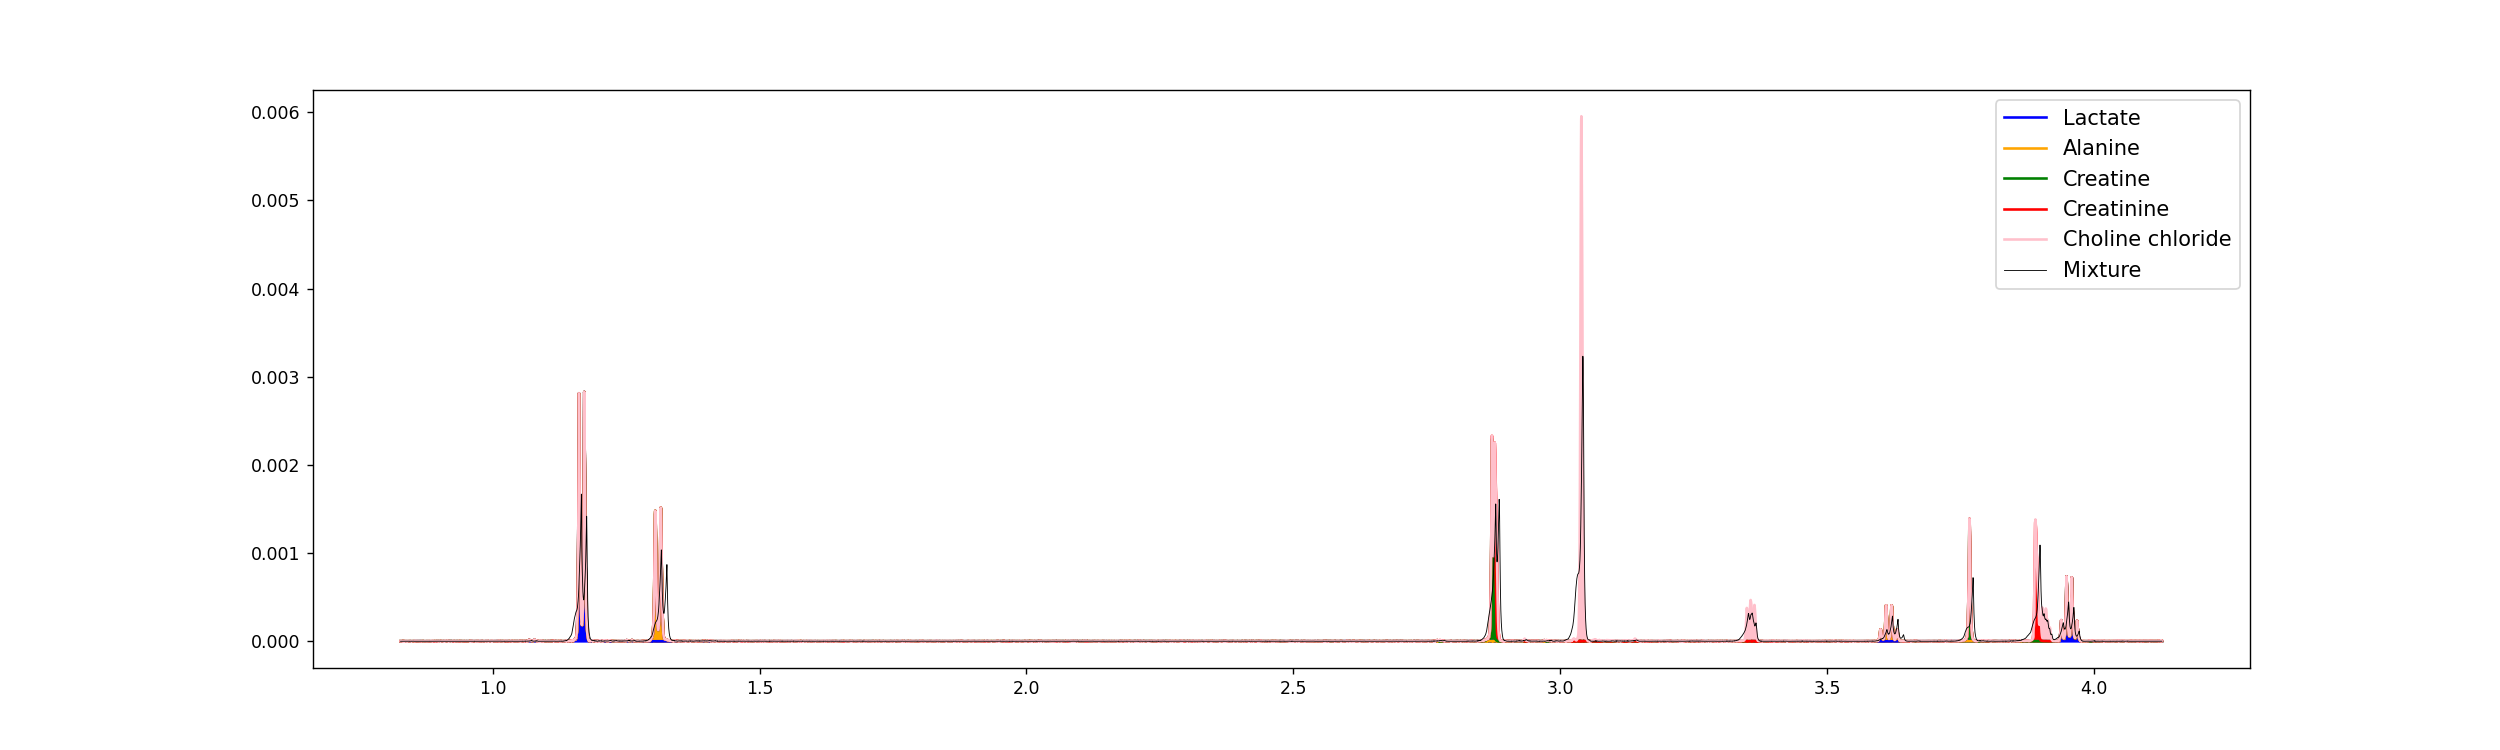

In [72]:
colors = ['blue', 'orange', 'green', 'red', 'pink']
fig, ax = plt.subplots()
fig.set_size_inches(20, 6, forward=True)
# ax.set_xlim(57,59.5)
# ax.set_ylim(-0.0001,0.0042)
for i, name in enumerate(names_matmul):
    ax.plot(ppm, globals()[name], alpha=1.0, color = colors[i], label=official_names[i])
    if i==0:
        ax.fill_between(ppm, 0, globals()[name], color=colors[0], alpha=1.0)
    else:
        predecessor = name[:-1]+str(i)
        ax.fill_between(ppm, globals()[predecessor] , globals()[name], color=colors[i], alpha=1.0)
ax.plot(ppm, mix_ints, color='black', alpha=1.0, label='Mixture', linewidth=0.5)
ax.legend(prop={'size': 12})